# Pytorch Example Problem

- We will build our first regression problem on the California housing dataset. The dataset contains the house prizes (median within a block) in California from the 1990 census together with some parameters of the housing block. The machine learning task will be to predict the median house value based on the other parameters, which thus serve as features

- Before we dive into `Pytorch` - here are some helpful tutorials:
    - `Introduction`: https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html, https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
    - `Training`: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html, https://pytorch.org/tutorials/beginner/pytorch_with_examples.html, https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
    - `Datasets, Dataloaders`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    - `Layer`:  https://pytorch.org/docs/stable/nn.html
    - `Loss`: https://pytorch.org/docs/stable/nn.html#loss-functions
    - `Optimizers`: https://pytorch.org/docs/stable/optim.html

- California Housing Dataset: Information concerning the demography (income, population, house occupancy) in the respective districts, together with the location of the districts (latitude, longitude), and additional general kn regarding the house in the districts (number of rooms and bedrooms, age of the house). These statistics are based on a specific district, why they are reported as average or median values.
  
    - Use the `housing.csv` file (available here: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html or https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv)
    - See also the short description(s) (here: https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv and https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)

- Get familiar with `Pytorch datasets` and `dataloaders`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Do some exploratory data analysis (`descriptive statistics`) on the dataset (`histogram` of every column, `correlation`, `scatter-matrix`)

- Prepare your dataset for machine learning. You will define a `Neural Network` in `Pytorch`, please create appropriate `PyTorch` `datasets` and `dataloaders`

## Exploratory Data Analysis
- Read in `housing.csv` via `pandas` and ignore/remove the last column (`ocean_proximity`) for further processing
- Create `histogram` information for each column
- Check for `NaN, None, NaT` values in the entire data corpus and remove data entries which are affected
- Compute pairwise correlation of columns via `corr()`
- Create a `scatter-matrix` - Interpret the results! What can be observed, e.g. population size and number of bedrooms - Interpret the results!
- Create individual `column`-specific `scatter` plots (`x-axis` = number of data samples, `y-axis` = value range) - Interpret the results!

In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
data = pd.read_csv("housing.csv")

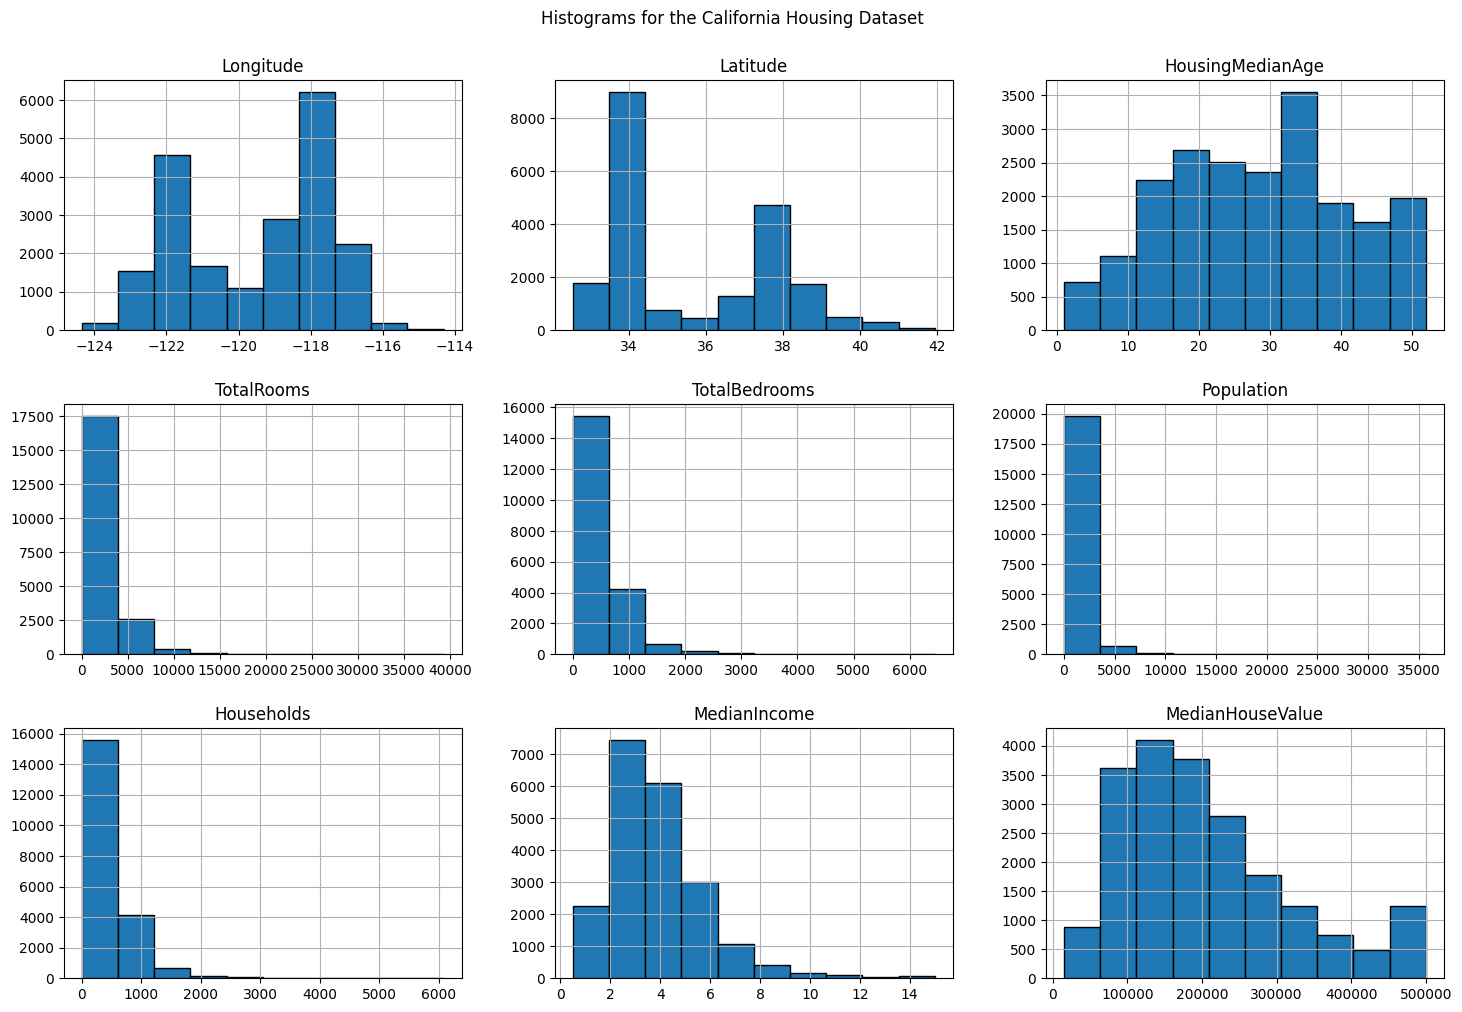

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(data.columns, axes)):
    data[col].hist(ax=ax, bins=10, edgecolor='black')
    ax.set_title(col)

plt.tight_layout(pad=2.0)
plt.suptitle('Histograms for the California Housing Dataset', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

In [6]:
data_cleaned = data.dropna()

In [7]:
correlations = data.corr()

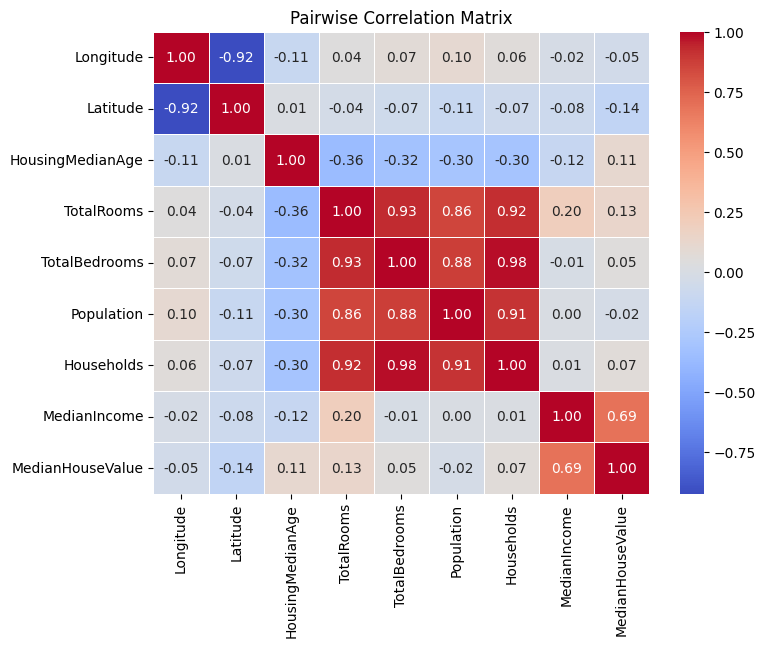

In [8]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
plt.title('Pairwise Correlation Matrix')
plt.show()

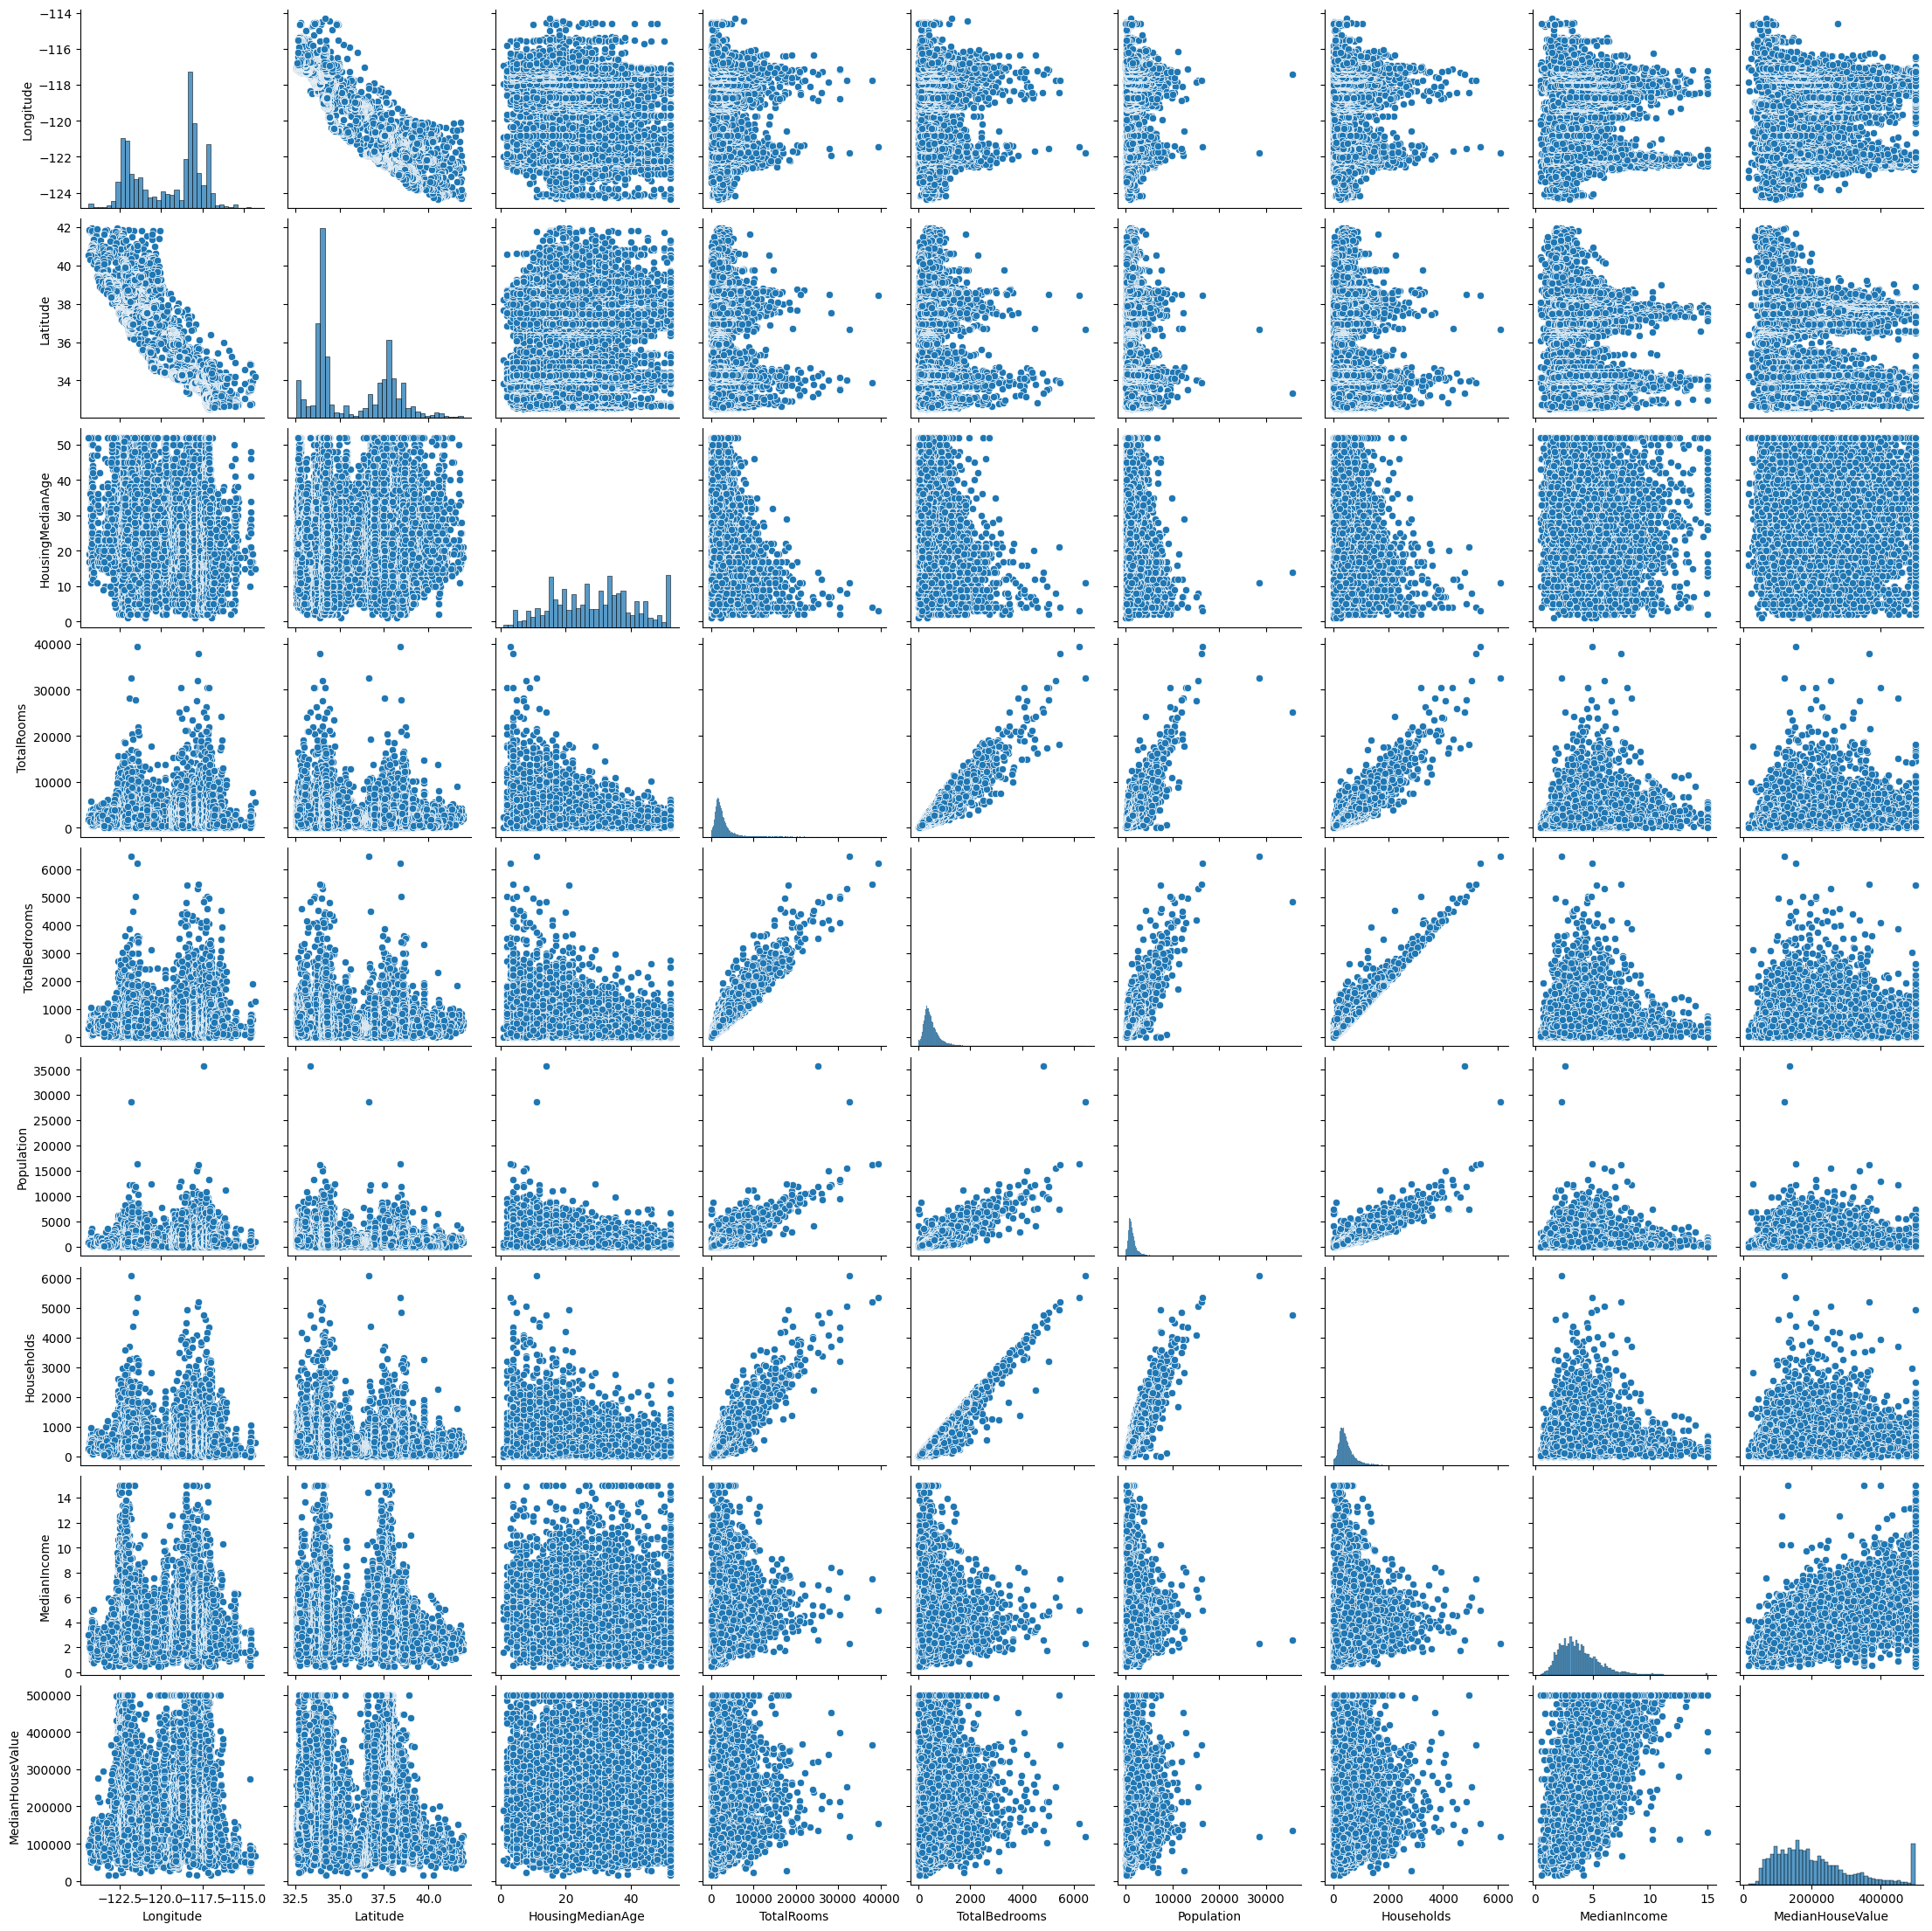

In [7]:
sns.pairplot(data)
plt.show()

## Model Prediction
- **Major Goal:** predicting house values (`MedianHouseValue`) based on all the other given `variables/features` (`Longitude, Latitude, HousingMedianAge, TotalRooms, TotalBedrooms, Population, Households, MedianIncome`)

### Prepare Data: Create Datasets and Dataloaders

- Split your data into `training`, `validation`, and `test` via the `PyTorch` function `train_test_split`

In [9]:
from sklearn.model_selection import train_test_split

#ground truth vs. features
ycol = 'MedianHouseValue'
X = data.drop(columns=[ycol])
y = data[ycol]

#train - test
Xtr_, Xte, ytr_, yte = train_test_split(X, y, test_size=0.1, random_state=42)

#train - validation
Xtr, Xval, ytr, yval = train_test_split(Xtr_, ytr_, test_size=0.2, random_state=43)

- Build your own `Custom Dataset` (inherit `from torch.utils.data import Dataset`)
- Provide an option (`scalers`) to normalize your data (`max val=1` and `min val=0`) - Use `MiinMaxScaler` of `sklearn.preprocessing`
- Provide also two additional options including `transform` and `target_transform`, representing a list of sequentially applied functions in order to compute different types of user-specific transformations (e.g. `transform = [functionA(paraA,...), functionB(paraB,...), functionB(paraC,...), etc.]`)
- Implement/Overwrite the system call methods (`magic methods`) of `__len__` and `__getitem__` - Which operations trigger an underlying function call of those methods?

In [10]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

In [11]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y, scalers=None, scale=True, transform=None, target_transform=None):
        if scale:
            if scalers is None:
                self.mmX = MinMaxScaler()
                self.mmy = MinMaxScaler()
                _X = self.mmX.fit_transform(X.values)
                _y = self.mmy.fit_transform(y.values.reshape(-1, 1))
            else:
                self.mmX = scalers[0]
                self.mmy = scalers[1]
                _X = self.mmX.transform(X.values)
                _y = self.mmy.transform(y.values.reshape(-1, 1))               
        else:
            # no scaling
            _X = X.values
            _y = y.values
            
        self.X = torch.from_numpy(_X).to(torch.float32)
        self.y = torch.from_numpy(_y).to(torch.float32)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx,:]
        target = self.y[idx]
        
        return features, target
    
    def get_scalers(self):
        return self.mmX, self.mmy

- Instantiate your `training, validation, and testing` dataset by calling the constructor of `MyCustomDataset` (`scale=True`, `scalers=None` only for `training` dataset)
- Get and store both scalers `min/max` of the `training set` in two variables (for later processing) and use them for the `scalers` option of your validation and test set
- Report the size of a single input feature vector `x` as well as output feature vector `y`
- Report the overall size of your `training, validation, and test dataset`

In [12]:
custom_train = MyCustomDataset(Xtr, ytr, scalers=None, scale=True)
min_scaler_x_train = custom_train.mmX
min_scaler_y_train = custom_train.mmy

custom_val = MyCustomDataset(Xval, yval, scalers=[min_scaler_x_train, min_scaler_y_train], scale=True)
custom_test = MyCustomDataset(Xte, yte, scalers=[min_scaler_x_train, min_scaler_y_train], scale=True)

In [13]:
print(f'Size of input feature vector: {len(custom_train.X[0])}')
print(f'Size of output feature vector: {len(custom_train.y[0])}')
print(f'Size of training dataset: {len(custom_train)}')
print(f'Size of validation dataset: {len(custom_val)}')
print(f'Size of test dataset: {len(custom_test)}')

Size of input feature vector: 8
Size of output feature vector: 1
Size of training dataset: 14860
Size of validation dataset: 3716
Size of test dataset: 2064


- Use the partition-specific `datasets` (`MyCustomDataset`) to build the corresponding `dataloaders` via `from torch.utils.data import DataLoader`
- Choose a `batch-size` of `16` for `training, validation, and test`, together with the `shuffle=True` option

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(custom_train, batch_size=16, shuffle=True)
validation_loader = DataLoader(custom_val, batch_size=16, shuffle=True)
test_loader = DataLoader(custom_test, batch_size=16, shuffle=True)

## Baseline System - Random Forest Regressor

- Create a `RandomForestRegressor` using `sklearn.ensemble` (`n_estimators=100`) - Check the `Python` documentation what is addressed by the parameter `n_estimators`!
- Train the `RandomForestRegressor` using your `training dataset` (seperate it first into `input feature list` and `ground truth list`)
- Validate/Test the `RandomForestRegressor` using your `validation dataset` and `test dataset` (seperate it first into `input feature list` and `ground truth list`) - compute `inverse transform` before!
- Careful: use the `min-max-scaler` to compute an `inverse_transform` of the `0/1-min-max` normalized values back to its original values before computing the final target metrics. Why re-transform?
- Report the `r2_score` and `root mean squarred error` (`RMSE`) from the `sklearn_metrics` package

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import math

rf = RandomForestRegressor(n_estimators=100)

#train
XX, yy = custom_train[:]

rf.fit(np.array(XX), np.array(yy).ravel())

#predict
XXv, yyv = custom_val[:]
XXt, yyt = custom_train[:]

yval_pred_rf = rf.predict(XXv.numpy())
ytest_pred_rf = rf.predict(XXt.numpy())

#evaluate val
ypredv_rf = (min_scaler_y_train.inverse_transform(yval_pred_rf.reshape(-1, 1)).tolist()) #Normalisierte Daten rücktransformieren
ypredv_rf = np.array(ypredv_rf).ravel()             

ytruev_rf = (min_scaler_y_train.inverse_transform(yyv.numpy().reshape(-1, 1)).tolist())
ytruev_rf = np.array(ytruev_rf).ravel()

#evaluate test
ypredt_rf = (min_scaler_y_train.inverse_transform(ytest_pred_rf.reshape(-1, 1)).tolist())
ypredt_rf = np.array(ypredt_rf).ravel()             

ytruet_rf = (min_scaler_y_train.inverse_transform(yyt.numpy().reshape(-1, 1)).tolist())
ytruet_rf = np.array(ytruet_rf).ravel()

#Report metrics
print("-------------------------------------------------------------------------------")
print ("Baseline System Random Forest Classifier (Validation Set):")
print("-------------------------------------------------------------------------------")
print(f'R2 score for the validation dataset: {r2_score(ytruev_rf, ypredv_rf)}')
print(f'R2 score for the test dataset: {r2_score(ytruet_rf, ypredt_rf)}')
print()
print("-------------------------------------------------------------------------------")
print ("Baseline System Random Forest Classifier (Test Set):")
print("-------------------------------------------------------------------------------")
print(f'RMSE for the validation dataset: {mean_squared_error(ytruev_rf, ypredv_rf, squared=False)}')
print(f'RMSE for the test dataset: {mean_squared_error(ytruet_rf, ypredt_rf, squared=False)}')

-------------------------------------------------------------------------------
Baseline System Random Forest Classifier (Validation Set):
-------------------------------------------------------------------------------
R2 score for the validation dataset: 0.8256938778104259
R2 score for the test dataset: 0.9742967283750914

-------------------------------------------------------------------------------
Baseline System Random Forest Classifier (Test Set):
-------------------------------------------------------------------------------
RMSE for the validation dataset: 49093.08745942937
RMSE for the test dataset: 18408.604787952656


## Neural Network Design

- Design a neural network for this regression task. Familiarize with the key concepts and how these are implemented in Pytorch (see links for documentation and tutorials at the very beginning):
    - Network and layers
    - Nonlinearity (ReLU)
    - Training and validation datasets
    - Optimizer
    - Loss function 

- Build a `CHNetwork` which inherits from `nn.Module` of `torch`
- Defined and implement the `__init__` (constructor) and the `forward path`
- Create a `MLP` (Multi-Layer-Perceptron) with an `input layer`, two `hidden layer`, and an `output layer` with the following dimensional relations/number of neurons: `8 to 512`, `512 to 64`, and `64 to 1`
- After every of those `fully-connected` layer (except the last one, which projects the hidden representation to the final output neuron) a `ReLU` activation function is applied
- Return the final and overall `feature output x` 

In [16]:
import torch
import torch.nn as nn

class CHNetwork(nn.Module):  # inheriting from nn.Module!

    def __init__(self, input_size, output_size):
        super(CHNetwork, self).__init__()

        hidden_size = [512, 64]

        self.linear01 = nn.Linear(input_size, hidden_size[0])
        self.linear02 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear03 = nn.Linear(hidden_size[1], output_size)
        

    def forward(self, input):
        x = torch.relu(self.linear01(input))
        x = torch.relu(self.linear02(x))
        x = self.linear03(x)

        return x

## Training Routine Design

- Implement an entire network training routine, including all of the required parametric options, such as:
    - `_net` - Neural network model
    - `_optimizer_fn`- Type of Optimizer
    - `optim_params` - Parameter of Optimizer (learning rate, beta values, ...)
    - `_scheduler_fn` - Scheduler for learning rate
    - `scheduler_params` - Parameter of Scheduler (learning rate decay gamma, step-size for learning rate patience, verbose, ...)  
    - `_loss_fn` - Loss Function
    - `dataloader_tr` - Dataloader for training set
    - `dataloader_val` - Dataloader for validation set
    - `epochs`- Maximum number of training epochs
    - `apply_scheduler` - Use learning rate scheduling
    - `snapshot_inverval` - Number of epochs 
    - `snap_path` - Path where to store snapshots

In [17]:
import os

"""
Routine to train the neural network.
Args:
    - _net - Neural network model
    - _optimizer_fn- Type of Optimizer (torch.optim function)
    - optim_params - Parameter of Optimizer (learning rate, beta values, ...)
    - _scheduler_fn - Scheduler for learning rate
    - scheduler_params - Parameter of Scheduler (learning rate decay gamma, step-size for learning rate patience, verbose, ...)  
    - _loss_fn - Loss Function (torch.nn loss)
    - dataloader_tr - Dataloader for training set
    - dataloader_val - Dataloader for validation set
    - epochs - Maximum number of training epochs
    - apply_scheduler (default: True) - Use learning rate scheduling
    - snapshot_inverval (default: 300) - Number of epochs 
    - snap_path (default "./") - Path where to store snapshots
"""

def training(_net, 
             _optimizer_fn, 
             optim_params, 
             _scheduler_fn,
             scheduler_params,
             _loss_fn, 
             dataloader_tr, 
             dataloader_val, 
             epochs,
             filename,
             apply_scheduler=True,
             snapshot_interval=300,
             snap_path = "./"):
 
    _optimizer = _optimizer_fn(_net.parameters(), **optim_params)
    _scheduler = _scheduler_fn(_optimizer, **scheduler_params)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs)):
        
        _net.train()
        running_tr_loss = 0
        
        for i, data in enumerate(dataloader_tr):

            _optimizer.zero_grad()
            
            inputs, targets = data
            
            yhats = _net(inputs)
            
            loss = _loss_fn(yhats, targets)
            loss.backward()
            _optimizer.step()
            
            if apply_scheduler:
                _scheduler.step()
            
            running_tr_loss += loss.detach().numpy()
            
        running_tr_loss /= (i+1)

        train_losses.append(running_tr_loss)
        print("Training loss: ", running_tr_loss)
        
        running_val_loss = 0        
        _net.eval()
        
        with torch.no_grad():
            
            for i, vdata in enumerate(dataloader_val):
                vinputs, vtargets = vdata
                vloss = _loss_fn(_net(vinputs), vtargets)
                running_val_loss += vloss.detach().numpy()
            
            running_val_loss /= (i+1)
            val_losses.append(running_val_loss)

            print("Validation loss: ", running_val_loss)

    torch.save(_net.state_dict().copy(), os.path.join(snap_path, filename))
    return train_losses, val_losses

- Train your neural network and evaluate its performance on the validation set by calling the designed training routine `training`
- Get the `number of input features` (size of the input layer)
- Create a new model (`CHNetwork`) with the respective `input` and `output features size`
- Create a loss function (optimization criterion), using `torch.nn`. Use the existing `MSELoss` with the `reduction` option `mean`
- Create a `SGD` optimizer from `torch.optim`
- Create a `Exponential Learning Rate Scheduler` using `torch.optim`
- Define the `parameters` as a dictionary for the `optimizer` (initial `learning rate` of `0.1`) and `scheduler` (`gamma` of `0.99999` and `verbose` not activated)
- Set the `maximum` number of `training epochs` to `500` (try also different values!)
- Call the `training` method (training routine) with all the defined parameters 

In [18]:
#number of input features
number_of_features = X.values.shape[1]

#network
my_net_def = CHNetwork(number_of_features, 1)

#loss function
my_loss_fn = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_fn = torch.optim.SGD

#scheduler
my_scheduler_fn = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params = {
        'lr': 0.1
}

scheduler_params = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max = 500

train_losses_ref, val_losses_ref = training(my_net_def, 
                                          my_optimizer_fn, 
                                          optim_params, 
                                          my_scheduler_fn,
                                          scheduler_params,
                                          my_loss_fn, 
                                          train_loader, 
                                          validation_loader, 
                                          epochs_max,
                                          "snapshot_standard_model",
                                          apply_scheduler=True,
                                          snapshot_interval=500)

## Evaluation and Interpretation

- Define a function `get_metrics` using the model together with a given data partition to compute and return the `R2` and `RMSE`
- Predict the `MedianHouseValue` for each sample (`feature vector x`) in the data partition (accumulate the `model output (prediction)` and `ground truth` for the entire dataset)
- Careful: compute the `inverse_transform` using the `min-max-scaler` before accumlating `prediction` and `ground truth`
- Compute/Return `R2` and `RMSE` based on the inverse transformed min-max prediction `ypred` and ground truth `ytrue`
- Interpret the individual metrics - What is a `R2-Score` and `RMSE` and how the metric should change in order to improve the model quality?

In [19]:
def get_metrics(net, validation_dataloader):
    ytrue = []
    ypred = []
    net.eval()
    for i, vdata in enumerate(validation_dataloader):
        vinputs, vtargets = vdata
        preds = net(vinputs)

        ytrue += (min_scaler_y_train.inverse_transform(vtargets).tolist())
        ypred += (min_scaler_y_train.inverse_transform(preds.detach().numpy()).tolist())

    ytrue = np.array(ytrue).ravel()
    ypred = np.array(ypred).ravel()

    r2 = r2_score(ytrue, ypred)
    rmse = mean_squared_error(ytrue, ypred, squared=False)

    return r2, rmse

- Plot the training loss (`line plot`) using the final and overall `train loss` across all `epochs` from your training routine (`training`)
- Plot the validation loss (`line plot`) in exactly the same way (using the `validation loss`)
- Plot the validation loss (`line plot`) by computing the average across `n=10` windowed validation values (smoothing) via `pandas Series rolling`
- Call the `get_metrics` function, using your trained model, in order to compute the `R2` and `RMSE` metrics (validaton and test). Compare it with the `Random Forest Regressor` result!

NameError: name 'train_losses_ref' is not defined

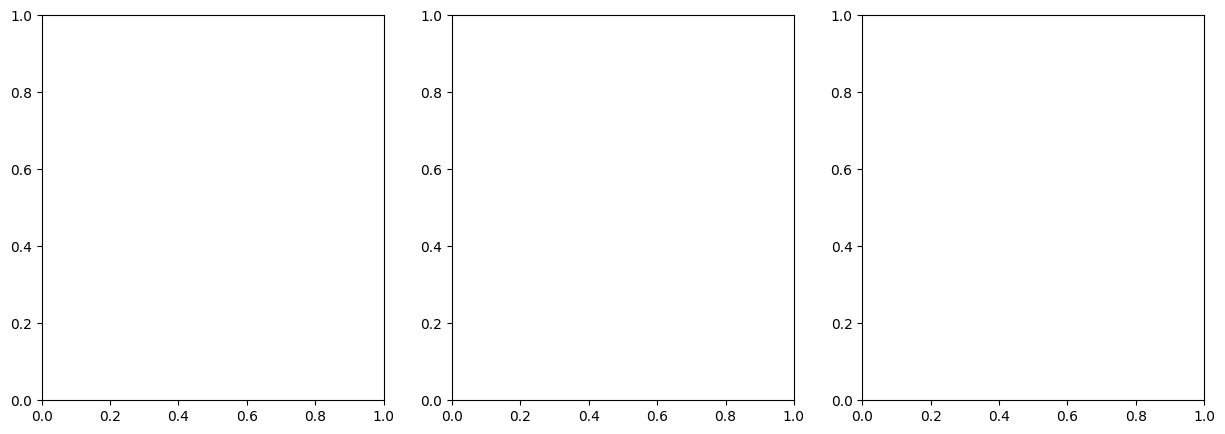

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
epochs = range(1, epochs_max + 1)
#val_loss_smooth = pd.Series(val_losses_ref).rolling(10)

axes[0].plot(epochs, train_losses_ref, color='blue')
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')

axes[1].plot(epochs, val_losses_ref, color='green')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Val Loss')

#axes[1].plot(epochs, val_loss_smooth, color='red')
#axes[1].set_title('Validation Loss')
#axes[1].set_xlabel('Epochs')
#axes[1].set_ylabel('Val Loss')

plt.show()

trained_model = CHNetwork(number_of_features, 1)
trained_model.load_state_dict(torch.load(os.path.join('./', 'snapshot_standard_model')))
trained_model.eval()

r2_net, mse_net = get_metrics(trained_model, validation_loader)

print(f'R2 score net model: {r2_net}')
print(f'MSE net model: {mse_net}')
print()
print(f'R2 random forest: {r2_score(ytruev_rf, ypredv_rf)}')
print(f'RMSE random forest: {mean_squared_error(ytruev_rf, ypredv_rf, squared=False)}')

## Neural Network Improvements and Fine-Tuning:
Try to improve your initial neural network performance by adding additional techniques and perform manual hyperparameter tuning:

- Try different layer architectures (deeper networks)
- Different Optimizers (e.g. `SGD` with `momentum`,  `RMSProp`, `Adam`)
- Early Stopping
- Dropout

**Important:** Once you have realized the additional code extension you can use the above training routine (`training`) to start a new training of your network, together with all the changes. Afterwards you can use the same plotting and metric computation (`get_metrics`) for all the different network alternatives/options.

### Deeper Nerual Network Architecture

Change your initial `CHNetwork` implementation (deeper network and more parameters) to realize the following architectural design:
- Model Design: `Input Layer`, `3x Hidden Layer`, `Output Layer` (use `nn.Linear` ase in the example above)
- Layer Shapes: `8 to 512`, `512 to 256`, `256 to 128`, `128 to 64`, `64 to 1`
- Activation Functions: `relu` activation after each layer, except the final output layer
- Implement the `__init__` and `forward` function (see example above)
- Return `x`
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different architectural designs and activation functions - play around!

In [28]:
import torch
import torch.nn as nn

class CHNetwork2(nn.Module):  # inheriting from nn.Module!

    def __init__(self, input_size, output_size):
        super(CHNetwork2, self).__init__()
        
        self.linear01 = nn.Linear(input_size, 512)
        self.linear02 = nn.Linear(512, 256)
        self.linear03 = nn.Linear(256, 128)
        self.linear04 = nn.Linear(128, 64)
        self.linear05 = nn.Linear(64, 1)
   

    def forward(self, input):
        x = torch.relu(self.linear01(input))
        x = torch.relu(self.linear02(x))
        x = torch.relu(self.linear03(x))
        x = torch.relu(self.linear04(x))
        x = self.linear05(x)
        return x

In [29]:
#number of input features
number_of_features2 = X.values.shape[1]

#network
my_net_def2 = CHNetwork2(number_of_features2, 1)

#loss function
my_loss_fn2 = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_fn2 = torch.optim.SGD

#scheduler
my_scheduler_fn2 = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params2 = {
        'lr': 0.1
}

scheduler_params2 = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max2 = 500

train_losses_ref, val_losses_ref = training(my_net_def2, 
                                          my_optimizer_fn2, 
                                          optim_params2, 
                                          my_scheduler_fn2,
                                          scheduler_params2,
                                          my_loss_fn2, 
                                          train_loader, 
                                          validation_loader, 
                                          epochs_max2,
                                          "snapshot_deeper_architecture",
                                          apply_scheduler=True,
                                          snapshot_interval=500)

  0%|                                           | 1/500 [00:00<07:50,  1.06it/s]

Training loss:  0.034373710826199715
Validation loss:  0.0256440300712274


  0%|▏                                          | 2/500 [00:01<08:02,  1.03it/s]

Training loss:  0.022688941785211567
Validation loss:  0.01943601047132532


  1%|▎                                          | 3/500 [00:02<08:02,  1.03it/s]

Training loss:  0.021022471539882705
Validation loss:  0.018906002342621017


  1%|▎                                          | 4/500 [00:03<07:53,  1.05it/s]

Training loss:  0.020421204059429876
Validation loss:  0.024025133999800028


  1%|▍                                          | 5/500 [00:04<07:49,  1.05it/s]

Training loss:  0.019979066085381147
Validation loss:  0.018144387703852592


  1%|▌                                          | 6/500 [00:05<07:53,  1.04it/s]

Training loss:  0.019545465029086377
Validation loss:  0.026676724677857474


  1%|▌                                          | 7/500 [00:06<08:06,  1.01it/s]

Training loss:  0.019134633148598323
Validation loss:  0.027002871909894272


  2%|▋                                          | 8/500 [00:07<08:11,  1.00it/s]

Training loss:  0.01881027609471781
Validation loss:  0.017585131050938892


  2%|▊                                          | 9/500 [00:08<08:00,  1.02it/s]

Training loss:  0.01852428110865766
Validation loss:  0.020664352868671645


  2%|▊                                         | 10/500 [00:09<07:51,  1.04it/s]

Training loss:  0.01849874017526575
Validation loss:  0.017454575441473927


  2%|▉                                         | 11/500 [00:10<07:44,  1.05it/s]

Training loss:  0.01806686106323394
Validation loss:  0.017126541428843536


  2%|█                                         | 12/500 [00:11<07:39,  1.06it/s]

Training loss:  0.01788925585478336
Validation loss:  0.017883541833913122


  3%|█                                         | 13/500 [00:12<07:36,  1.07it/s]

Training loss:  0.017858535387935227
Validation loss:  0.017300205587013725


  3%|█▏                                        | 14/500 [00:13<07:34,  1.07it/s]

Training loss:  0.017632126566563985
Validation loss:  0.02156473386157384


  3%|█▎                                        | 15/500 [00:14<07:31,  1.07it/s]

Training loss:  0.017465156145630437
Validation loss:  0.016790413146822558


  3%|█▎                                        | 16/500 [00:15<07:29,  1.08it/s]

Training loss:  0.01736712176177302
Validation loss:  0.017507116929847796


  3%|█▍                                        | 17/500 [00:16<07:27,  1.08it/s]

Training loss:  0.017000084904807474
Validation loss:  0.04447725511959438


  4%|█▌                                        | 18/500 [00:17<07:25,  1.08it/s]

Training loss:  0.017209746194672564
Validation loss:  0.017446023579926705


  4%|█▌                                        | 19/500 [00:17<07:24,  1.08it/s]

Training loss:  0.01701487453210301
Validation loss:  0.01614283197239649


  4%|█▋                                        | 20/500 [00:18<07:26,  1.08it/s]

Training loss:  0.016858569358648937
Validation loss:  0.020429308246421456


  4%|█▊                                        | 21/500 [00:19<07:23,  1.08it/s]

Training loss:  0.01673493641042687
Validation loss:  0.01564405089925751


  4%|█▊                                        | 22/500 [00:20<07:22,  1.08it/s]

Training loss:  0.01645306618463156
Validation loss:  0.01680845339870472


  5%|█▉                                        | 23/500 [00:21<07:20,  1.08it/s]

Training loss:  0.01642150684726997
Validation loss:  0.015822638543682422


  5%|██                                        | 24/500 [00:22<07:21,  1.08it/s]

Training loss:  0.016272079577495067
Validation loss:  0.018025936100176283


  5%|██                                        | 25/500 [00:23<07:20,  1.08it/s]

Training loss:  0.016393588775411985
Validation loss:  0.015978372733252595


  5%|██▏                                       | 26/500 [00:24<07:19,  1.08it/s]

Training loss:  0.016102020892282534
Validation loss:  0.015545468570568596


  5%|██▎                                       | 27/500 [00:25<07:15,  1.09it/s]

Training loss:  0.015939978269140353
Validation loss:  0.01650705733016741


  6%|██▎                                       | 28/500 [00:26<07:09,  1.10it/s]

Training loss:  0.01589357595669208
Validation loss:  0.015227580048311741


  6%|██▍                                       | 29/500 [00:27<07:04,  1.11it/s]

Training loss:  0.015964883483772892
Validation loss:  0.015254928428647728


  6%|██▌                                       | 30/500 [00:28<07:01,  1.12it/s]

Training loss:  0.015538283980269069
Validation loss:  0.016971450097171405


  6%|██▌                                       | 31/500 [00:28<06:58,  1.12it/s]

Training loss:  0.015570149944184911
Validation loss:  0.02658254714770634


  6%|██▋                                       | 32/500 [00:29<06:56,  1.12it/s]

Training loss:  0.015622743949508626
Validation loss:  0.014812222954741171


  7%|██▊                                       | 33/500 [00:30<06:54,  1.13it/s]

Training loss:  0.015599888024801053
Validation loss:  0.016535743782216835


  7%|██▊                                       | 34/500 [00:31<06:53,  1.13it/s]

Training loss:  0.015385382649096769
Validation loss:  0.01634898379968695


  7%|██▉                                       | 35/500 [00:32<06:52,  1.13it/s]

Training loss:  0.015184756994334653
Validation loss:  0.014962068891808263


  7%|███                                       | 36/500 [00:33<06:50,  1.13it/s]

Training loss:  0.015379384637983723
Validation loss:  0.018008454458472267


  7%|███                                       | 37/500 [00:34<06:48,  1.13it/s]

Training loss:  0.015078016680232235
Validation loss:  0.014638606522356204


  8%|███▏                                      | 38/500 [00:35<06:47,  1.13it/s]

Training loss:  0.01500065004316723
Validation loss:  0.01482924455057334


  8%|███▎                                      | 39/500 [00:35<06:46,  1.13it/s]

Training loss:  0.014911931715364316
Validation loss:  0.014407932470540633


  8%|███▎                                      | 40/500 [00:36<06:45,  1.13it/s]

Training loss:  0.0151084243089103
Validation loss:  0.014645584470736335


  8%|███▍                                      | 41/500 [00:37<06:44,  1.13it/s]

Training loss:  0.014948195348262177
Validation loss:  0.014272688232490177


  8%|███▌                                      | 42/500 [00:38<06:44,  1.13it/s]

Training loss:  0.014813523478174443
Validation loss:  0.015267932032087074


  9%|███▌                                      | 43/500 [00:39<06:44,  1.13it/s]

Training loss:  0.014742088808394383
Validation loss:  0.014327864361479238


  9%|███▋                                      | 44/500 [00:40<06:43,  1.13it/s]

Training loss:  0.014699609033398498
Validation loss:  0.01415921146022116


  9%|███▊                                      | 45/500 [00:41<06:42,  1.13it/s]

Training loss:  0.014670134953221163
Validation loss:  0.014239541331881682


  9%|███▊                                      | 46/500 [00:42<06:41,  1.13it/s]

Training loss:  0.014477185179545585
Validation loss:  0.014651649939335978


  9%|███▉                                      | 47/500 [00:43<06:41,  1.13it/s]

Training loss:  0.014541244902096656
Validation loss:  0.015197618275904797


 10%|████                                      | 48/500 [00:43<06:39,  1.13it/s]

Training loss:  0.014507357737368255
Validation loss:  0.015930785909454966


 10%|████                                      | 49/500 [00:44<06:38,  1.13it/s]

Training loss:  0.014457809285058233
Validation loss:  0.01518313188301679


 10%|████▏                                     | 50/500 [00:45<06:36,  1.13it/s]

Training loss:  0.01429377951941466
Validation loss:  0.015069534025822522


 10%|████▎                                     | 51/500 [00:46<06:36,  1.13it/s]

Training loss:  0.014256021209397986
Validation loss:  0.014128718830948864


 10%|████▎                                     | 52/500 [00:47<06:35,  1.13it/s]

Training loss:  0.014290608340108405
Validation loss:  0.013985105106695015


 11%|████▍                                     | 53/500 [00:48<06:34,  1.13it/s]

Training loss:  0.014128054441925263
Validation loss:  0.014111816781660933


 11%|████▌                                     | 54/500 [00:49<06:35,  1.13it/s]

Training loss:  0.014116206194601945
Validation loss:  0.018425428067721714


 11%|████▌                                     | 55/500 [00:50<06:49,  1.09it/s]

Training loss:  0.014173415927086085
Validation loss:  0.014664619018387674


 11%|████▋                                     | 56/500 [00:51<06:58,  1.06it/s]

Training loss:  0.014223919988412359
Validation loss:  0.014064554837552328


 11%|████▊                                     | 57/500 [00:52<07:06,  1.04it/s]

Training loss:  0.013992128959522093
Validation loss:  0.013751440998786349


 12%|████▊                                     | 58/500 [00:53<07:05,  1.04it/s]

Training loss:  0.013989418395168365
Validation loss:  0.014155076565360851


 12%|████▉                                     | 59/500 [00:54<07:05,  1.04it/s]

Training loss:  0.013938440023735968
Validation loss:  0.013896219646198428


 12%|█████                                     | 60/500 [00:55<07:11,  1.02it/s]

Training loss:  0.014000244586141047
Validation loss:  0.013709388708779708


 12%|█████                                     | 61/500 [00:56<07:13,  1.01it/s]

Training loss:  0.014008037465753834
Validation loss:  0.013905179293130728


 12%|█████▏                                    | 62/500 [00:57<07:08,  1.02it/s]

Training loss:  0.013871964744158867
Validation loss:  0.013672489015877151


 13%|█████▎                                    | 63/500 [00:58<07:08,  1.02it/s]

Training loss:  0.013856240877013482
Validation loss:  0.013752687481619705


 13%|█████▍                                    | 64/500 [00:59<07:05,  1.02it/s]

Training loss:  0.013707465355472983
Validation loss:  0.014417218978720609


 13%|█████▍                                    | 65/500 [01:00<06:56,  1.04it/s]

Training loss:  0.013765731460261445
Validation loss:  0.014339499931498691


 13%|█████▌                                    | 66/500 [01:00<06:46,  1.07it/s]

Training loss:  0.013769006747822603
Validation loss:  0.013382630892369752


 13%|█████▋                                    | 67/500 [01:01<06:39,  1.08it/s]

Training loss:  0.013687397411245496
Validation loss:  0.01414577047392534


 14%|█████▋                                    | 68/500 [01:02<06:35,  1.09it/s]

Training loss:  0.013724561888961156
Validation loss:  0.013436930690784119


 14%|█████▊                                    | 69/500 [01:03<06:31,  1.10it/s]

Training loss:  0.01363929489431241
Validation loss:  0.01376898941092289


 14%|█████▉                                    | 70/500 [01:04<06:28,  1.11it/s]

Training loss:  0.013627992762980504
Validation loss:  0.014726280577504776


 14%|█████▉                                    | 71/500 [01:05<06:25,  1.11it/s]

Training loss:  0.013493808971209687
Validation loss:  0.014212183048249154


 14%|██████                                    | 72/500 [01:06<06:26,  1.11it/s]

Training loss:  0.013589895912070145
Validation loss:  0.01362948406581635


 15%|██████▏                                   | 73/500 [01:07<06:24,  1.11it/s]

Training loss:  0.01357576786603105
Validation loss:  0.014095448378209712


 15%|██████▏                                   | 74/500 [01:08<06:22,  1.11it/s]

Training loss:  0.013502884076244576
Validation loss:  0.01324683889275009


 15%|██████▎                                   | 75/500 [01:08<06:20,  1.12it/s]

Training loss:  0.01355904096885874
Validation loss:  0.013728009258065164


 15%|██████▍                                   | 76/500 [01:09<06:19,  1.12it/s]

Training loss:  0.01347101013869372
Validation loss:  0.01359353194017235


 15%|██████▍                                   | 77/500 [01:10<06:21,  1.11it/s]

Training loss:  0.013396280540120301
Validation loss:  0.015159324768834744


 16%|██████▌                                   | 78/500 [01:11<06:35,  1.07it/s]

Training loss:  0.01337752742800597
Validation loss:  0.013295728723016915


 16%|██████▋                                   | 79/500 [01:12<06:34,  1.07it/s]

Training loss:  0.013169770168247798
Validation loss:  0.01739528410880159


 16%|██████▋                                   | 80/500 [01:13<06:31,  1.07it/s]

Training loss:  0.013402969722783412
Validation loss:  0.014078686026308702


 16%|██████▊                                   | 81/500 [01:14<06:31,  1.07it/s]

Training loss:  0.013293644482775143
Validation loss:  0.014400675621027599


 16%|██████▉                                   | 82/500 [01:15<06:28,  1.08it/s]

Training loss:  0.013244370871751827
Validation loss:  0.01353256905535356


 17%|██████▉                                   | 83/500 [01:16<06:27,  1.08it/s]

Training loss:  0.013219883231861181
Validation loss:  0.013152565141588194


 17%|███████                                   | 84/500 [01:17<06:26,  1.08it/s]

Training loss:  0.013192459641288129
Validation loss:  0.014603989434882184


 17%|███████▏                                  | 85/500 [01:18<06:24,  1.08it/s]

Training loss:  0.013154592909258704
Validation loss:  0.022709366195943093


 17%|███████▏                                  | 86/500 [01:19<06:23,  1.08it/s]

Training loss:  0.013166557049350682
Validation loss:  0.013212120794998922


 17%|███████▎                                  | 87/500 [01:20<06:22,  1.08it/s]

Training loss:  0.013112334698184009
Validation loss:  0.013635948308355818


 18%|███████▍                                  | 88/500 [01:21<06:21,  1.08it/s]

Training loss:  0.013136066883838504
Validation loss:  0.013312094796412972


 18%|███████▍                                  | 89/500 [01:21<06:20,  1.08it/s]

Training loss:  0.013068018807825082
Validation loss:  0.013229924920634586


 18%|███████▌                                  | 90/500 [01:22<06:19,  1.08it/s]

Training loss:  0.013081318586292818
Validation loss:  0.01357619227869476


 18%|███████▋                                  | 91/500 [01:23<06:17,  1.08it/s]

Training loss:  0.013105914650451836
Validation loss:  0.013266256492277168


 18%|███████▋                                  | 92/500 [01:24<06:16,  1.08it/s]

Training loss:  0.013013615020309184
Validation loss:  0.0155245137436899


 19%|███████▊                                  | 93/500 [01:25<06:16,  1.08it/s]

Training loss:  0.012892165540444861
Validation loss:  0.013279342074586725


 19%|███████▉                                  | 94/500 [01:26<06:16,  1.08it/s]

Training loss:  0.012913659455698782
Validation loss:  0.015041497886748465


 19%|███████▉                                  | 95/500 [01:27<06:16,  1.08it/s]

Training loss:  0.012898319891946685
Validation loss:  0.01347978518428401


 19%|████████                                  | 96/500 [01:28<06:15,  1.07it/s]

Training loss:  0.01292418507396457
Validation loss:  0.013333175419290178


 19%|████████▏                                 | 97/500 [01:29<06:15,  1.07it/s]

Training loss:  0.012890476977554891
Validation loss:  0.01381484652637572


 20%|████████▏                                 | 98/500 [01:30<06:15,  1.07it/s]

Training loss:  0.012896421199150191
Validation loss:  0.013527123775141306


 20%|████████▎                                 | 99/500 [01:31<06:14,  1.07it/s]

Training loss:  0.012801309270068473
Validation loss:  0.013289350757471289


 20%|████████▏                                | 100/500 [01:32<06:12,  1.07it/s]

Training loss:  0.01283655546964482
Validation loss:  0.013506367664720239


 20%|████████▎                                | 101/500 [01:33<06:12,  1.07it/s]

Training loss:  0.01289413199497866
Validation loss:  0.01350866391397453


 20%|████████▎                                | 102/500 [01:34<06:12,  1.07it/s]

Training loss:  0.01272774877443216
Validation loss:  0.013566498861991893


 21%|████████▍                                | 103/500 [01:35<06:11,  1.07it/s]

Training loss:  0.012776548839880974
Validation loss:  0.013005559425601184


 21%|████████▌                                | 104/500 [01:35<06:09,  1.07it/s]

Training loss:  0.012618503215135274
Validation loss:  0.013261166895847656


 21%|████████▌                                | 105/500 [01:36<06:08,  1.07it/s]

Training loss:  0.012699838846132953
Validation loss:  0.013871562581253537


 21%|████████▋                                | 106/500 [01:37<06:06,  1.07it/s]

Training loss:  0.012668030256800458
Validation loss:  0.01313769753598668


 21%|████████▊                                | 107/500 [01:38<06:05,  1.08it/s]

Training loss:  0.012653598445592964
Validation loss:  0.01307299202447957


 22%|████████▊                                | 108/500 [01:39<06:07,  1.07it/s]

Training loss:  0.012597931582536808
Validation loss:  0.012944129225198388


 22%|████████▉                                | 109/500 [01:40<06:08,  1.06it/s]

Training loss:  0.01260372398577057
Validation loss:  0.013280662661518247


 22%|█████████                                | 110/500 [01:41<06:06,  1.06it/s]

Training loss:  0.012677989676679947
Validation loss:  0.014413695545595283


 22%|█████████                                | 111/500 [01:42<06:04,  1.07it/s]

Training loss:  0.012569268830812289
Validation loss:  0.01339704845132618


 22%|█████████▏                               | 112/500 [01:43<06:03,  1.07it/s]

Training loss:  0.01249918765957348
Validation loss:  0.013242844913890306


 23%|█████████▎                               | 113/500 [01:44<06:02,  1.07it/s]

Training loss:  0.012602753304040303
Validation loss:  0.015107434107062643


 23%|█████████▎                               | 114/500 [01:45<06:01,  1.07it/s]

Training loss:  0.012530150273423822
Validation loss:  0.013066954341169463


 23%|█████████▍                               | 115/500 [01:46<06:03,  1.06it/s]

Training loss:  0.012492486680993174
Validation loss:  0.012823873107089729


 23%|█████████▌                               | 116/500 [01:47<06:00,  1.06it/s]

Training loss:  0.012555726179532281
Validation loss:  0.01309286739253499


 23%|█████████▌                               | 117/500 [01:48<05:58,  1.07it/s]

Training loss:  0.012417049736784024
Validation loss:  0.012758135226507204


 24%|█████████▋                               | 118/500 [01:49<05:56,  1.07it/s]

Training loss:  0.012356297976655165
Validation loss:  0.014110227104460285


 24%|█████████▊                               | 119/500 [01:50<05:55,  1.07it/s]

Training loss:  0.012468132829750749
Validation loss:  0.012705005228703306


 24%|█████████▊                               | 120/500 [01:50<05:54,  1.07it/s]

Training loss:  0.012323476359111822
Validation loss:  0.012936512269619293


 24%|█████████▉                               | 121/500 [01:51<05:52,  1.08it/s]

Training loss:  0.012440156015773996
Validation loss:  0.012708734481119803


 24%|██████████                               | 122/500 [01:52<05:51,  1.07it/s]

Training loss:  0.012322992527009307
Validation loss:  0.012817420887804786


 25%|██████████                               | 123/500 [01:53<05:50,  1.07it/s]

Training loss:  0.012297896279971465
Validation loss:  0.013364198189448614


 25%|██████████▏                              | 124/500 [01:54<05:49,  1.08it/s]

Training loss:  0.012246430690241908
Validation loss:  0.01436765909958391


 25%|██████████▎                              | 125/500 [01:55<05:48,  1.08it/s]

Training loss:  0.01232235126617887
Validation loss:  0.015965932516517047


 25%|██████████▎                              | 126/500 [01:56<05:47,  1.08it/s]

Training loss:  0.01216759515208953
Validation loss:  0.015396574220336303


 25%|██████████▍                              | 127/500 [01:57<05:47,  1.07it/s]

Training loss:  0.01223369517696438
Validation loss:  0.012943613931013056


 26%|██████████▍                              | 128/500 [01:58<05:45,  1.08it/s]

Training loss:  0.01220099641542994
Validation loss:  0.01284572919490927


 26%|██████████▌                              | 129/500 [01:59<05:45,  1.07it/s]

Training loss:  0.01217242197669437
Validation loss:  0.012718323665139437


 26%|██████████▋                              | 130/500 [02:00<05:45,  1.07it/s]

Training loss:  0.012144295624166575
Validation loss:  0.012730103549687392


 26%|██████████▋                              | 131/500 [02:01<05:44,  1.07it/s]

Training loss:  0.012188681046677948
Validation loss:  0.012771815094045591


 26%|██████████▊                              | 132/500 [02:02<05:42,  1.08it/s]

Training loss:  0.01212691085987531
Validation loss:  0.012889066575167005


 27%|██████████▉                              | 133/500 [02:03<05:40,  1.08it/s]

Training loss:  0.011996238680899272
Validation loss:  0.012941643498266363


 27%|██████████▉                              | 134/500 [02:03<05:39,  1.08it/s]

Training loss:  0.01207173035522187
Validation loss:  0.012605282471539222


 27%|███████████                              | 135/500 [02:04<05:38,  1.08it/s]

Training loss:  0.01201935536295789
Validation loss:  0.012853895089700978


 27%|███████████▏                             | 136/500 [02:05<05:36,  1.08it/s]

Training loss:  0.012047381592544539
Validation loss:  0.012535020224390304


 27%|███████████▏                             | 137/500 [02:06<05:35,  1.08it/s]

Training loss:  0.012016993068761129
Validation loss:  0.01852179886053752


 28%|███████████▎                             | 138/500 [02:07<05:34,  1.08it/s]

Training loss:  0.011913919543939671
Validation loss:  0.012571384147501075


 28%|███████████▍                             | 139/500 [02:08<05:33,  1.08it/s]

Training loss:  0.01199061958461627
Validation loss:  0.01253624097294226


 28%|███████████▍                             | 140/500 [02:09<05:32,  1.08it/s]

Training loss:  0.01202693494025265
Validation loss:  0.013726097292790404


 28%|███████████▌                             | 141/500 [02:10<05:30,  1.08it/s]

Training loss:  0.011945977603286842
Validation loss:  0.012773405864950701


 28%|███████████▋                             | 142/500 [02:11<05:30,  1.08it/s]

Training loss:  0.011918134509537678
Validation loss:  0.012528187814148646


 29%|███████████▋                             | 143/500 [02:12<05:29,  1.08it/s]

Training loss:  0.011915968834929794
Validation loss:  0.015344798902665213


 29%|███████████▊                             | 144/500 [02:13<05:28,  1.08it/s]

Training loss:  0.011805033719641296
Validation loss:  0.013168882661551045


 29%|███████████▉                             | 145/500 [02:14<05:27,  1.08it/s]

Training loss:  0.011881652926230167
Validation loss:  0.012661777696544264


 29%|███████████▉                             | 146/500 [02:15<05:26,  1.08it/s]

Training loss:  0.011846263646709545
Validation loss:  0.012417388921043968


 29%|████████████                             | 147/500 [02:15<05:27,  1.08it/s]

Training loss:  0.01177809095141489
Validation loss:  0.012462438338000504


 30%|████████████▏                            | 148/500 [02:16<05:26,  1.08it/s]

Training loss:  0.011832787387501107
Validation loss:  0.012580997891156522


 30%|████████████▏                            | 149/500 [02:17<05:24,  1.08it/s]

Training loss:  0.011786953530192127
Validation loss:  0.012356340263614455


 30%|████████████▎                            | 150/500 [02:18<05:22,  1.08it/s]

Training loss:  0.011768242873580258
Validation loss:  0.013071105526680279


 30%|████████████▍                            | 151/500 [02:19<05:21,  1.08it/s]

Training loss:  0.011762289397280154
Validation loss:  0.012526614423601413


 30%|████████████▍                            | 152/500 [02:20<05:21,  1.08it/s]

Training loss:  0.01171650222846757
Validation loss:  0.013339698657417439


 31%|████████████▌                            | 153/500 [02:21<05:20,  1.08it/s]

Training loss:  0.011711469478754826
Validation loss:  0.012618474770225424


 31%|████████████▋                            | 154/500 [02:22<05:19,  1.08it/s]

Training loss:  0.011696250475411764
Validation loss:  0.012327180926032492


 31%|████████████▋                            | 155/500 [02:23<05:18,  1.08it/s]

Training loss:  0.0116673704815439
Validation loss:  0.013967931233626258


 31%|████████████▊                            | 156/500 [02:24<05:17,  1.08it/s]

Training loss:  0.011637543631049397
Validation loss:  0.01247381766090897


 31%|████████████▊                            | 157/500 [02:25<05:16,  1.08it/s]

Training loss:  0.011693375353301415
Validation loss:  0.012387956213805616


 32%|████████████▉                            | 158/500 [02:26<05:15,  1.09it/s]

Training loss:  0.01156896151102522
Validation loss:  0.012614047643428772


 32%|█████████████                            | 159/500 [02:27<05:14,  1.09it/s]

Training loss:  0.01156602094783994
Validation loss:  0.013254032360865482


 32%|█████████████                            | 160/500 [02:27<05:13,  1.09it/s]

Training loss:  0.011627830155203831
Validation loss:  0.014733313516885553


 32%|█████████████▏                           | 161/500 [02:28<05:12,  1.09it/s]

Training loss:  0.011511256111047929
Validation loss:  0.012947236559485672


 32%|█████████████▎                           | 162/500 [02:29<05:13,  1.08it/s]

Training loss:  0.011554997155078926
Validation loss:  0.01215650223379419


 33%|█████████████▎                           | 163/500 [02:30<05:11,  1.08it/s]

Training loss:  0.01155790097851595
Validation loss:  0.01228825190572204


 33%|█████████████▍                           | 164/500 [02:31<05:10,  1.08it/s]

Training loss:  0.011555367940761133
Validation loss:  0.018141855495730056


 33%|█████████████▌                           | 165/500 [02:32<05:09,  1.08it/s]

Training loss:  0.01149217904541858
Validation loss:  0.012382629808126409


 33%|█████████████▌                           | 166/500 [02:33<05:08,  1.08it/s]

Training loss:  0.0114758035643738
Validation loss:  0.01269028252770109


 33%|█████████████▋                           | 167/500 [02:34<05:08,  1.08it/s]

Training loss:  0.01145930040379098
Validation loss:  0.012980807232350719


 34%|█████████████▊                           | 168/500 [02:35<05:06,  1.08it/s]

Training loss:  0.01151089171404811
Validation loss:  0.012173721496847182


 34%|█████████████▊                           | 169/500 [02:36<05:05,  1.08it/s]

Training loss:  0.011457660824308057
Validation loss:  0.013199196746193128


 34%|█████████████▉                           | 170/500 [02:37<05:04,  1.08it/s]

Training loss:  0.011510366516787282
Validation loss:  0.01242783161373849


 34%|██████████████                           | 171/500 [02:38<05:04,  1.08it/s]

Training loss:  0.011436149880838398
Validation loss:  0.012704177673650273


 34%|██████████████                           | 172/500 [02:39<05:04,  1.08it/s]

Training loss:  0.011387456489794069
Validation loss:  0.012578446814758391


 35%|██████████████▏                          | 173/500 [02:39<05:03,  1.08it/s]

Training loss:  0.011400830871059657
Validation loss:  0.012274815838847934


 35%|██████████████▎                          | 174/500 [02:40<05:03,  1.07it/s]

Training loss:  0.01142643523037602
Validation loss:  0.01219767083607758


 35%|██████████████▎                          | 175/500 [02:41<05:02,  1.08it/s]

Training loss:  0.011405099687954477
Validation loss:  0.012474389396040288


 35%|██████████████▍                          | 176/500 [02:42<05:00,  1.08it/s]

Training loss:  0.011314149417406183
Validation loss:  0.013732007720163931


 35%|██████████████▌                          | 177/500 [02:43<04:59,  1.08it/s]

Training loss:  0.011311816911872745
Validation loss:  0.012231092019178484


 36%|██████████████▌                          | 178/500 [02:44<05:05,  1.05it/s]

Training loss:  0.011331744655712123
Validation loss:  0.01269894069692224


 36%|██████████████▋                          | 179/500 [02:45<05:13,  1.02it/s]

Training loss:  0.011319373264874706
Validation loss:  0.012492489893101316


 36%|██████████████▊                          | 180/500 [02:46<05:18,  1.00it/s]

Training loss:  0.01127326491138967
Validation loss:  0.012199415795329174


 36%|██████████████▊                          | 181/500 [02:47<05:10,  1.03it/s]

Training loss:  0.011244261711765687
Validation loss:  0.01284136319315149


 36%|██████████████▉                          | 182/500 [02:48<05:05,  1.04it/s]

Training loss:  0.011195526865964598
Validation loss:  0.012197759182815932


 37%|███████████████                          | 183/500 [02:49<05:01,  1.05it/s]

Training loss:  0.011204917782083539
Validation loss:  0.012145305490580911


 37%|███████████████                          | 184/500 [02:50<04:57,  1.06it/s]

Training loss:  0.011265834688937815
Validation loss:  0.012010556200765025


 37%|███████████████▏                         | 185/500 [02:51<04:54,  1.07it/s]

Training loss:  0.011157554032459487
Validation loss:  0.012225344868540731


 37%|███████████████▎                         | 186/500 [02:52<04:52,  1.07it/s]

Training loss:  0.011214561407294914
Validation loss:  0.011983309583408687


 37%|███████████████▎                         | 187/500 [02:53<04:51,  1.08it/s]

Training loss:  0.011125398105420414
Validation loss:  0.012297311888671931


 38%|███████████████▍                         | 188/500 [02:54<04:49,  1.08it/s]

Training loss:  0.011191778582449605
Validation loss:  0.012202536859629524


 38%|███████████████▍                         | 189/500 [02:55<04:47,  1.08it/s]

Training loss:  0.011130109288633488
Validation loss:  0.01208655946776111


 38%|███████████████▌                         | 190/500 [02:56<04:45,  1.08it/s]

Training loss:  0.011160484968135244
Validation loss:  0.012292331391885524


 38%|███████████████▋                         | 191/500 [02:56<04:44,  1.09it/s]

Training loss:  0.011119774412173293
Validation loss:  0.012018122571388604


 38%|███████████████▋                         | 192/500 [02:57<04:43,  1.09it/s]

Training loss:  0.011137921452839069
Validation loss:  0.012168009812412024


 39%|███████████████▊                         | 193/500 [02:58<04:42,  1.09it/s]

Training loss:  0.01107154973678339
Validation loss:  0.012131475856979358


 39%|███████████████▉                         | 194/500 [02:59<04:42,  1.08it/s]

Training loss:  0.011134153705346423
Validation loss:  0.014330837385960787


 39%|███████████████▉                         | 195/500 [03:00<04:41,  1.08it/s]

Training loss:  0.011090045076428008
Validation loss:  0.011994188008909893


 39%|████████████████                         | 196/500 [03:01<04:41,  1.08it/s]

Training loss:  0.011067356843480277
Validation loss:  0.012271022321176696


 39%|████████████████▏                        | 197/500 [03:02<04:39,  1.08it/s]

Training loss:  0.011064682577148209
Validation loss:  0.012012016001185443


 40%|████████████████▏                        | 198/500 [03:03<04:38,  1.08it/s]

Training loss:  0.011097347638639947
Validation loss:  0.011919893191471824


 40%|████████████████▎                        | 199/500 [03:04<04:37,  1.08it/s]

Training loss:  0.011045239083453876
Validation loss:  0.0129744833856901


 40%|████████████████▍                        | 200/500 [03:05<04:36,  1.08it/s]

Training loss:  0.01105072134223529
Validation loss:  0.012389036335146989


 40%|████████████████▍                        | 201/500 [03:06<04:35,  1.08it/s]

Training loss:  0.010941067523552572
Validation loss:  0.012953130479366418


 40%|████████████████▌                        | 202/500 [03:07<04:34,  1.08it/s]

Training loss:  0.010960702047396584
Validation loss:  0.011972892844585838


 41%|████████████████▋                        | 203/500 [03:08<04:34,  1.08it/s]

Training loss:  0.01098153965842917
Validation loss:  0.011902035737626031


 41%|████████████████▋                        | 204/500 [03:08<04:33,  1.08it/s]

Training loss:  0.010936501731798333
Validation loss:  0.012044076766826756


 41%|████████████████▊                        | 205/500 [03:09<04:32,  1.08it/s]

Training loss:  0.010965716293276126
Validation loss:  0.012062682494892871


 41%|████████████████▉                        | 206/500 [03:10<04:31,  1.08it/s]

Training loss:  0.010867312514454736
Validation loss:  0.011934808881097981


 41%|████████████████▉                        | 207/500 [03:11<04:34,  1.07it/s]

Training loss:  0.01095172110869799
Validation loss:  0.014503988230505024


 42%|█████████████████                        | 208/500 [03:12<04:37,  1.05it/s]

Training loss:  0.010939934561745863
Validation loss:  0.012980502599434599


 42%|█████████████████▏                       | 209/500 [03:13<04:34,  1.06it/s]

Training loss:  0.010903180629366847
Validation loss:  0.012066418451932558


 42%|█████████████████▏                       | 210/500 [03:14<04:32,  1.07it/s]

Training loss:  0.010855929316392426
Validation loss:  0.011936830586549934


 42%|█████████████████▎                       | 211/500 [03:15<04:30,  1.07it/s]

Training loss:  0.010925698383541856
Validation loss:  0.012063771073582539


 42%|█████████████████▍                       | 212/500 [03:16<04:28,  1.07it/s]

Training loss:  0.010880483996470944
Validation loss:  0.01281817964989644


 43%|█████████████████▍                       | 213/500 [03:17<04:27,  1.07it/s]

Training loss:  0.010883032139270407
Validation loss:  0.012418218349734153


 43%|█████████████████▌                       | 214/500 [03:18<04:26,  1.07it/s]

Training loss:  0.0108312679315838
Validation loss:  0.01189721904519162


 43%|█████████████████▋                       | 215/500 [03:19<04:27,  1.07it/s]

Training loss:  0.010884745512784242
Validation loss:  0.012190405756051256


 43%|█████████████████▋                       | 216/500 [03:20<04:25,  1.07it/s]

Training loss:  0.010806740286551512
Validation loss:  0.012510367473807234


 43%|█████████████████▊                       | 217/500 [03:21<04:24,  1.07it/s]

Training loss:  0.010837948130593064
Validation loss:  0.012104407326586129


 44%|█████████████████▉                       | 218/500 [03:22<04:22,  1.07it/s]

Training loss:  0.010792189677204812
Validation loss:  0.012776122947599212


 44%|█████████████████▉                       | 219/500 [03:22<04:22,  1.07it/s]

Training loss:  0.010812020024527325
Validation loss:  0.012334375974998006


 44%|██████████████████                       | 220/500 [03:23<04:21,  1.07it/s]

Training loss:  0.010730436006465683
Validation loss:  0.011867009890225792


 44%|██████████████████                       | 221/500 [03:24<04:20,  1.07it/s]

Training loss:  0.010769549160629343
Validation loss:  0.011987661693021335


 44%|██████████████████▏                      | 222/500 [03:25<04:18,  1.07it/s]

Training loss:  0.010780455530117356
Validation loss:  0.011850712767926088


 45%|██████████████████▎                      | 223/500 [03:26<04:17,  1.07it/s]

Training loss:  0.010785809084805646
Validation loss:  0.011969969937649792


 45%|██████████████████▎                      | 224/500 [03:27<04:16,  1.07it/s]

Training loss:  0.010784082659805922
Validation loss:  0.012352154754070253


 45%|██████████████████▍                      | 225/500 [03:28<04:15,  1.08it/s]

Training loss:  0.010749259265891573
Validation loss:  0.011780707855097342


 45%|██████████████████▌                      | 226/500 [03:29<04:15,  1.07it/s]

Training loss:  0.01072435902792006
Validation loss:  0.011979047017663622


 45%|██████████████████▌                      | 227/500 [03:30<04:14,  1.07it/s]

Training loss:  0.010708398218126317
Validation loss:  0.011855118550248284


 46%|██████████████████▋                      | 228/500 [03:31<04:13,  1.07it/s]

Training loss:  0.010676265247963144
Validation loss:  0.011979882683317166


 46%|██████████████████▊                      | 229/500 [03:32<04:12,  1.07it/s]

Training loss:  0.01065745138058457
Validation loss:  0.01216374440398467


 46%|██████████████████▊                      | 230/500 [03:33<04:12,  1.07it/s]

Training loss:  0.010641206185327415
Validation loss:  0.011703190237859288


 46%|██████████████████▉                      | 231/500 [03:34<04:10,  1.07it/s]

Training loss:  0.010627457103115558
Validation loss:  0.011821488661455718


 46%|███████████████████                      | 232/500 [03:35<04:10,  1.07it/s]

Training loss:  0.010652447559327425
Validation loss:  0.011877345044641503


 47%|███████████████████                      | 233/500 [03:36<04:08,  1.07it/s]

Training loss:  0.010621913253736709
Validation loss:  0.011963831373718228


 47%|███████████████████▏                     | 234/500 [03:36<04:07,  1.07it/s]

Training loss:  0.010644837825577125
Validation loss:  0.011900104513359875


 47%|███████████████████▎                     | 235/500 [03:37<04:06,  1.07it/s]

Training loss:  0.010597514801015085
Validation loss:  0.013085191885545019


 47%|███████████████████▎                     | 236/500 [03:38<04:06,  1.07it/s]

Training loss:  0.010619846123884221
Validation loss:  0.011628172292909685


 47%|███████████████████▍                     | 237/500 [03:39<04:05,  1.07it/s]

Training loss:  0.010603329747718777
Validation loss:  0.01245524474447633


 48%|███████████████████▌                     | 238/500 [03:40<04:04,  1.07it/s]

Training loss:  0.01059497539450257
Validation loss:  0.01172077473075141


 48%|███████████████████▌                     | 239/500 [03:41<04:03,  1.07it/s]

Training loss:  0.010568009758497457
Validation loss:  0.01163677728930768


 48%|███████████████████▋                     | 240/500 [03:42<04:02,  1.07it/s]

Training loss:  0.010588644358877842
Validation loss:  0.011688141184239428


 48%|███████████████████▊                     | 241/500 [03:43<04:01,  1.07it/s]

Training loss:  0.010575066360572816
Validation loss:  0.011714031766948206


 48%|███████████████████▊                     | 242/500 [03:44<04:00,  1.07it/s]

Training loss:  0.01054340070807771
Validation loss:  0.012197021337509826


 49%|███████████████████▉                     | 243/500 [03:45<03:59,  1.07it/s]

Training loss:  0.010542909825893381
Validation loss:  0.011916664341072924


 49%|████████████████████                     | 244/500 [03:46<03:58,  1.07it/s]

Training loss:  0.010546335160147812
Validation loss:  0.01171786754587945


 49%|████████████████████                     | 245/500 [03:47<03:57,  1.07it/s]

Training loss:  0.010490974124152097
Validation loss:  0.011704641247923633


 49%|████████████████████▏                    | 246/500 [03:48<03:56,  1.07it/s]

Training loss:  0.010527131009713593
Validation loss:  0.011770926634261441


 49%|████████████████████▎                    | 247/500 [03:49<03:55,  1.07it/s]

Training loss:  0.010513887186038465
Validation loss:  0.01172420087264443


 50%|████████████████████▎                    | 248/500 [03:50<03:57,  1.06it/s]

Training loss:  0.010476192621743773
Validation loss:  0.012034429031895881


 50%|████████████████████▍                    | 249/500 [03:50<03:55,  1.07it/s]

Training loss:  0.010497608241365483
Validation loss:  0.012190446103703182


 50%|████████████████████▌                    | 250/500 [03:51<03:53,  1.07it/s]

Training loss:  0.010546626194317066
Validation loss:  0.011734685671211983


 50%|████████████████████▌                    | 251/500 [03:52<03:52,  1.07it/s]

Training loss:  0.010479646113593897
Validation loss:  0.011783412782587271


 50%|████████████████████▋                    | 252/500 [03:53<03:51,  1.07it/s]

Training loss:  0.01045365828145556
Validation loss:  0.011682846329110982


 51%|████████████████████▋                    | 253/500 [03:54<03:50,  1.07it/s]

Training loss:  0.010485050403432814
Validation loss:  0.01157647426601883


 51%|████████████████████▊                    | 254/500 [03:55<03:49,  1.07it/s]

Training loss:  0.010452637570460032
Validation loss:  0.011655601828714808


 51%|████████████████████▉                    | 255/500 [03:56<03:48,  1.07it/s]

Training loss:  0.010448278778556442
Validation loss:  0.012581298315883595


 51%|████████████████████▉                    | 256/500 [03:57<03:47,  1.07it/s]

Training loss:  0.010462891729498448
Validation loss:  0.011543242830399408


 51%|█████████████████████                    | 257/500 [03:58<03:46,  1.07it/s]

Training loss:  0.01040393475553901
Validation loss:  0.0117000644040282


 52%|█████████████████████▏                   | 258/500 [03:59<03:46,  1.07it/s]

Training loss:  0.010454594108075067
Validation loss:  0.011662332398033513


 52%|█████████████████████▏                   | 259/500 [04:00<03:45,  1.07it/s]

Training loss:  0.01040084675917817
Validation loss:  0.011612075861631353


 52%|█████████████████████▎                   | 260/500 [04:01<03:44,  1.07it/s]

Training loss:  0.010356457730172757
Validation loss:  0.01179560020969693


 52%|█████████████████████▍                   | 261/500 [04:02<03:44,  1.07it/s]

Training loss:  0.010423077417129552
Validation loss:  0.011626705704676587


 52%|█████████████████████▍                   | 262/500 [04:03<03:44,  1.06it/s]

Training loss:  0.010368735817199888
Validation loss:  0.01182821494888898


 53%|█████████████████████▌                   | 263/500 [04:04<03:43,  1.06it/s]

Training loss:  0.01040253819510806
Validation loss:  0.011842568310041605


 53%|█████████████████████▋                   | 264/500 [04:04<03:41,  1.07it/s]

Training loss:  0.010373335744207174
Validation loss:  0.011883001644144338


 53%|█████████████████████▋                   | 265/500 [04:05<03:39,  1.07it/s]

Training loss:  0.010364034631168239
Validation loss:  0.011843362684729368


 53%|█████████████████████▊                   | 266/500 [04:06<03:38,  1.07it/s]

Training loss:  0.010362975957624983
Validation loss:  0.011568148704865236


 53%|█████████████████████▉                   | 267/500 [04:07<03:41,  1.05it/s]

Training loss:  0.010374759854092207
Validation loss:  0.01214321051892133


 54%|█████████████████████▉                   | 268/500 [04:08<03:44,  1.03it/s]

Training loss:  0.010334413110171279
Validation loss:  0.01163801195024005


 54%|██████████████████████                   | 269/500 [04:09<03:44,  1.03it/s]

Training loss:  0.010357027347334955
Validation loss:  0.011632250087303729


 54%|██████████████████████▏                  | 270/500 [04:10<03:40,  1.04it/s]

Training loss:  0.010352330371365051
Validation loss:  0.011780989213442918


 54%|██████████████████████▏                  | 271/500 [04:11<03:38,  1.05it/s]

Training loss:  0.010334888369457012
Validation loss:  0.011646416235131575


 54%|██████████████████████▎                  | 272/500 [04:12<03:35,  1.06it/s]

Training loss:  0.01032479409759
Validation loss:  0.011568883587826092


 55%|██████████████████████▍                  | 273/500 [04:13<03:33,  1.06it/s]

Training loss:  0.010324584341490695
Validation loss:  0.011589721442288179


 55%|██████████████████████▍                  | 274/500 [04:14<03:33,  1.06it/s]

Training loss:  0.010316356209676164
Validation loss:  0.01158074562611706


 55%|██████████████████████▌                  | 275/500 [04:15<03:30,  1.07it/s]

Training loss:  0.01035893845634557
Validation loss:  0.011590701084216266


 55%|██████████████████████▋                  | 276/500 [04:16<03:32,  1.06it/s]

Training loss:  0.010286145936547347
Validation loss:  0.011556868381446523


 55%|██████████████████████▋                  | 277/500 [04:17<03:32,  1.05it/s]

Training loss:  0.010281808166067939
Validation loss:  0.011656552256392755


 56%|██████████████████████▊                  | 278/500 [04:18<03:36,  1.02it/s]

Training loss:  0.010246133213309899
Validation loss:  0.012056574387807608


 56%|██████████████████████▉                  | 279/500 [04:19<03:42,  1.00s/it]

Training loss:  0.010236583355439784
Validation loss:  0.01163937541648202


 56%|██████████████████████▉                  | 280/500 [04:20<03:40,  1.00s/it]

Training loss:  0.010271919102145336
Validation loss:  0.01179536710725098


 56%|███████████████████████                  | 281/500 [04:21<03:34,  1.02it/s]

Training loss:  0.010250266754222317
Validation loss:  0.011605909541389174


 56%|███████████████████████                  | 282/500 [04:22<03:30,  1.04it/s]

Training loss:  0.01024284239376437
Validation loss:  0.011438656026495485


 57%|███████████████████████▏                 | 283/500 [04:23<03:27,  1.05it/s]

Training loss:  0.010242905014743918
Validation loss:  0.011564456671876073


 57%|███████████████████████▎                 | 284/500 [04:24<03:24,  1.06it/s]

Training loss:  0.010238133457968507
Validation loss:  0.011438161962617653


 57%|███████████████████████▎                 | 285/500 [04:25<03:22,  1.06it/s]

Training loss:  0.010200676559375356
Validation loss:  0.011513966378254232


 57%|███████████████████████▍                 | 286/500 [04:26<03:20,  1.07it/s]

Training loss:  0.010205390190818939
Validation loss:  0.011687308817186548


 57%|███████████████████████▌                 | 287/500 [04:26<03:19,  1.07it/s]

Training loss:  0.010203716511922348
Validation loss:  0.011476440830336077


 58%|███████████████████████▌                 | 288/500 [04:27<03:17,  1.07it/s]

Training loss:  0.01020522598268422
Validation loss:  0.011596718088567833


 58%|███████████████████████▋                 | 289/500 [04:28<03:18,  1.06it/s]

Training loss:  0.010224541380802978
Validation loss:  0.011686455705223102


 58%|███████████████████████▊                 | 290/500 [04:29<03:16,  1.07it/s]

Training loss:  0.010184160944107476
Validation loss:  0.01147206806899508


 58%|███████████████████████▊                 | 291/500 [04:30<03:14,  1.07it/s]

Training loss:  0.010188828288367974
Validation loss:  0.011536001854340342


 58%|███████████████████████▉                 | 292/500 [04:31<03:12,  1.08it/s]

Training loss:  0.01018373916362712
Validation loss:  0.011417883996404067


 59%|████████████████████████                 | 293/500 [04:32<03:11,  1.08it/s]

Training loss:  0.010177160206349092
Validation loss:  0.011397490970382682


 59%|████████████████████████                 | 294/500 [04:33<03:10,  1.08it/s]

Training loss:  0.010171162030951343
Validation loss:  0.011453247611119127


 59%|████████████████████████▏                | 295/500 [04:34<03:09,  1.08it/s]

Training loss:  0.010171903505073248
Validation loss:  0.011418940092221126


 59%|████████████████████████▎                | 296/500 [04:35<03:08,  1.08it/s]

Training loss:  0.010130110841000852
Validation loss:  0.011439805056464103


 59%|████████████████████████▎                | 297/500 [04:36<03:07,  1.08it/s]

Training loss:  0.010150526449248692
Validation loss:  0.011646694683094105


 60%|████████████████████████▍                | 298/500 [04:37<03:06,  1.08it/s]

Training loss:  0.010151108833124102
Validation loss:  0.012173507847251618


 60%|████████████████████████▌                | 299/500 [04:38<03:07,  1.07it/s]

Training loss:  0.010153404180616124
Validation loss:  0.011608038581268215


 60%|████████████████████████▌                | 300/500 [04:39<03:06,  1.07it/s]

Training loss:  0.01015694588320019
Validation loss:  0.011633114701400755


 60%|████████████████████████▋                | 301/500 [04:39<03:05,  1.08it/s]

Training loss:  0.010077919849731927
Validation loss:  0.011591409454461939


 60%|████████████████████████▊                | 302/500 [04:40<03:03,  1.08it/s]

Training loss:  0.010119019544270367
Validation loss:  0.011587275111200408


 61%|████████████████████████▊                | 303/500 [04:41<03:02,  1.08it/s]

Training loss:  0.010116536543174248
Validation loss:  0.011640981185477819


 61%|████████████████████████▉                | 304/500 [04:42<03:01,  1.08it/s]

Training loss:  0.01011592917674621
Validation loss:  0.011397920691811923


 61%|█████████████████████████                | 305/500 [04:43<03:00,  1.08it/s]

Training loss:  0.010113610430025125
Validation loss:  0.011412901577016124


 61%|█████████████████████████                | 306/500 [04:44<02:59,  1.08it/s]

Training loss:  0.010106541262488448
Validation loss:  0.01145775488511831


 61%|█████████████████████████▏               | 307/500 [04:45<02:58,  1.08it/s]

Training loss:  0.01010120121398249
Validation loss:  0.011572465889131881


 62%|█████████████████████████▎               | 308/500 [04:46<02:57,  1.08it/s]

Training loss:  0.010089509760303296
Validation loss:  0.01143827195586077


 62%|█████████████████████████▎               | 309/500 [04:47<02:56,  1.08it/s]

Training loss:  0.010070114069446858
Validation loss:  0.011522436912707153


 62%|█████████████████████████▍               | 310/500 [04:48<02:55,  1.08it/s]

Training loss:  0.010056290429424339
Validation loss:  0.01161131608877491


 62%|█████████████████████████▌               | 311/500 [04:49<02:54,  1.08it/s]

Training loss:  0.010104142368768129
Validation loss:  0.011482545144680103


 62%|█████████████████████████▌               | 312/500 [04:50<02:53,  1.08it/s]

Training loss:  0.01006716214354973
Validation loss:  0.011410519867923607


 63%|█████████████████████████▋               | 313/500 [04:51<02:52,  1.08it/s]

Training loss:  0.010080730296677406
Validation loss:  0.01159619616420516


 63%|█████████████████████████▋               | 314/500 [04:51<02:51,  1.08it/s]

Training loss:  0.010073395200205046
Validation loss:  0.01162636129169569


 63%|█████████████████████████▊               | 315/500 [04:52<02:50,  1.08it/s]

Training loss:  0.010060683316355661
Validation loss:  0.011536045857833082


 63%|█████████████████████████▉               | 316/500 [04:53<02:50,  1.08it/s]

Training loss:  0.010083605171420859
Validation loss:  0.01162499698406573


 63%|█████████████████████████▉               | 317/500 [04:54<02:49,  1.08it/s]

Training loss:  0.010024444782676374
Validation loss:  0.01141193146765424


 64%|██████████████████████████               | 318/500 [04:55<02:48,  1.08it/s]

Training loss:  0.01003831884331512
Validation loss:  0.011692022684913593


 64%|██████████████████████████▏              | 319/500 [04:56<02:47,  1.08it/s]

Training loss:  0.010036145602212568
Validation loss:  0.01152142181232084


 64%|██████████████████████████▏              | 320/500 [04:57<02:46,  1.08it/s]

Training loss:  0.010018984790048306
Validation loss:  0.011392485517249022


 64%|██████████████████████████▎              | 321/500 [04:58<02:45,  1.08it/s]

Training loss:  0.010026943192699977
Validation loss:  0.011589431892900603


 64%|██████████████████████████▍              | 322/500 [04:59<02:44,  1.08it/s]

Training loss:  0.01001246065279545
Validation loss:  0.011755502410532803


 65%|██████████████████████████▍              | 323/500 [05:00<02:43,  1.08it/s]

Training loss:  0.010001097261816447
Validation loss:  0.01157508020453123


 65%|██████████████████████████▌              | 324/500 [05:01<02:42,  1.08it/s]

Training loss:  0.010022833591740101
Validation loss:  0.01147149223434567


 65%|██████████████████████████▋              | 325/500 [05:02<02:41,  1.08it/s]

Training loss:  0.009985231782386904
Validation loss:  0.011688813757523096


 65%|██████████████████████████▋              | 326/500 [05:03<02:41,  1.07it/s]

Training loss:  0.0100070689774777
Validation loss:  0.011664544198214367


 65%|██████████████████████████▊              | 327/500 [05:04<02:40,  1.08it/s]

Training loss:  0.010005098806801418
Validation loss:  0.011419101781111865


 66%|██████████████████████████▉              | 328/500 [05:04<02:39,  1.08it/s]

Training loss:  0.010007561432083405
Validation loss:  0.011393109210087345


 66%|██████████████████████████▉              | 329/500 [05:05<02:37,  1.08it/s]

Training loss:  0.009989002273972893
Validation loss:  0.011437510344591551


 66%|███████████████████████████              | 330/500 [05:06<02:37,  1.08it/s]

Training loss:  0.009977605180194315
Validation loss:  0.0115394555451948


 66%|███████████████████████████▏             | 331/500 [05:07<02:36,  1.08it/s]

Training loss:  0.009980668381720669
Validation loss:  0.01152427500721403


 66%|███████████████████████████▏             | 332/500 [05:08<02:34,  1.08it/s]

Training loss:  0.009973620966556046
Validation loss:  0.011353975525645483


 67%|███████████████████████████▎             | 333/500 [05:09<02:33,  1.08it/s]

Training loss:  0.00998880865931535
Validation loss:  0.01159233190399063


 67%|███████████████████████████▍             | 334/500 [05:10<02:33,  1.08it/s]

Training loss:  0.009958081012561645
Validation loss:  0.01136958762621627


 67%|███████████████████████████▍             | 335/500 [05:11<02:32,  1.08it/s]

Training loss:  0.009989256404547784
Validation loss:  0.0114079959632613


 67%|███████████████████████████▌             | 336/500 [05:12<02:33,  1.07it/s]

Training loss:  0.009957469594278909
Validation loss:  0.011401757696351683


 67%|███████████████████████████▋             | 337/500 [05:13<02:32,  1.07it/s]

Training loss:  0.009963560723990354
Validation loss:  0.011441827652268432


 68%|███████████████████████████▋             | 338/500 [05:14<02:30,  1.07it/s]

Training loss:  0.009941401281890302
Validation loss:  0.011504761652837111


 68%|███████████████████████████▊             | 339/500 [05:15<02:29,  1.07it/s]

Training loss:  0.00993269292221167
Validation loss:  0.011356854724374005


 68%|███████████████████████████▉             | 340/500 [05:16<02:28,  1.08it/s]

Training loss:  0.009934184185692398
Validation loss:  0.011428302589128426


 68%|███████████████████████████▉             | 341/500 [05:16<02:27,  1.08it/s]

Training loss:  0.009942922007469952
Validation loss:  0.011401120787126696


 68%|████████████████████████████             | 342/500 [05:17<02:26,  1.08it/s]

Training loss:  0.00997060577757807
Validation loss:  0.0125052025361794


 69%|████████████████████████████▏            | 343/500 [05:18<02:26,  1.07it/s]

Training loss:  0.009937015679751126
Validation loss:  0.011549436805525979


 69%|████████████████████████████▏            | 344/500 [05:19<02:25,  1.07it/s]

Training loss:  0.009919686902207157
Validation loss:  0.01134698256818266


 69%|████████████████████████████▎            | 345/500 [05:20<02:23,  1.08it/s]

Training loss:  0.009918130341259636
Validation loss:  0.011789646112587895


 69%|████████████████████████████▎            | 346/500 [05:21<02:22,  1.08it/s]

Training loss:  0.009917125989686982
Validation loss:  0.011399125126230454


 69%|████████████████████████████▍            | 347/500 [05:22<02:21,  1.08it/s]

Training loss:  0.009911370611162124
Validation loss:  0.011675061007997605


 70%|████████████████████████████▌            | 348/500 [05:23<02:21,  1.07it/s]

Training loss:  0.009913904722343901
Validation loss:  0.01130681794562453


 70%|████████████████████████████▌            | 349/500 [05:24<02:20,  1.07it/s]

Training loss:  0.00989747160030138
Validation loss:  0.011369065724836877


 70%|████████████████████████████▋            | 350/500 [05:25<02:19,  1.08it/s]

Training loss:  0.00992351227522145
Validation loss:  0.01136907754873641


 70%|████████████████████████████▊            | 351/500 [05:26<02:18,  1.08it/s]

Training loss:  0.009899060205036154
Validation loss:  0.011373514841138806


 70%|████████████████████████████▊            | 352/500 [05:27<02:18,  1.07it/s]

Training loss:  0.009912553105495301
Validation loss:  0.011356722875278395


 71%|████████████████████████████▉            | 353/500 [05:28<02:16,  1.07it/s]

Training loss:  0.009903362353617553
Validation loss:  0.011350644772868332


 71%|█████████████████████████████            | 354/500 [05:29<02:16,  1.07it/s]

Training loss:  0.009881337155614036
Validation loss:  0.011418546510504583


 71%|█████████████████████████████            | 355/500 [05:30<02:15,  1.07it/s]

Training loss:  0.009895135522860156
Validation loss:  0.011340608817820994


 71%|█████████████████████████████▏           | 356/500 [05:30<02:14,  1.07it/s]

Training loss:  0.009882316661600637
Validation loss:  0.011419261235128209


 71%|█████████████████████████████▎           | 357/500 [05:31<02:13,  1.07it/s]

Training loss:  0.00987290055929624
Validation loss:  0.011517762196502076


 72%|█████████████████████████████▎           | 358/500 [05:32<02:12,  1.08it/s]

Training loss:  0.00987303865506074
Validation loss:  0.011335827244341757


 72%|█████████████████████████████▍           | 359/500 [05:33<02:11,  1.07it/s]

Training loss:  0.009855783825180823
Validation loss:  0.01133221486341528


 72%|█████████████████████████████▌           | 360/500 [05:34<02:10,  1.07it/s]

Training loss:  0.009860337814752242
Validation loss:  0.01140790842693347


 72%|█████████████████████████████▌           | 361/500 [05:35<02:09,  1.08it/s]

Training loss:  0.00989119887496851
Validation loss:  0.011462308997548158


 72%|█████████████████████████████▋           | 362/500 [05:36<02:08,  1.07it/s]

Training loss:  0.009873376132301841
Validation loss:  0.011321783659364149


 73%|█████████████████████████████▊           | 363/500 [05:37<02:07,  1.07it/s]

Training loss:  0.009852216689796283
Validation loss:  0.011420899929174985


 73%|█████████████████████████████▊           | 364/500 [05:38<02:06,  1.08it/s]

Training loss:  0.00985191712660697
Validation loss:  0.011390627740558573


 73%|█████████████████████████████▉           | 365/500 [05:39<02:05,  1.08it/s]

Training loss:  0.009850972354616589
Validation loss:  0.011297991413866917


 73%|██████████████████████████████           | 366/500 [05:40<02:05,  1.07it/s]

Training loss:  0.0098420637243691
Validation loss:  0.011331359448127225


 73%|██████████████████████████████           | 367/500 [05:41<02:04,  1.07it/s]

Training loss:  0.009841975002861367
Validation loss:  0.011281795240638881


 74%|██████████████████████████████▏          | 368/500 [05:42<02:02,  1.08it/s]

Training loss:  0.00983351170545518
Validation loss:  0.011265119619651542


 74%|██████████████████████████████▎          | 369/500 [05:43<02:01,  1.08it/s]

Training loss:  0.009848861988439386
Validation loss:  0.01127883078992095


 74%|██████████████████████████████▎          | 370/500 [05:43<02:00,  1.08it/s]

Training loss:  0.009844341926728811
Validation loss:  0.011426277669514389


 74%|██████████████████████████████▍          | 371/500 [05:44<02:00,  1.07it/s]

Training loss:  0.009841518689824651
Validation loss:  0.011362360381669177


 74%|██████████████████████████████▌          | 372/500 [05:45<01:59,  1.07it/s]

Training loss:  0.009833974059620037
Validation loss:  0.011303305597436242


 75%|██████████████████████████████▌          | 373/500 [05:46<01:57,  1.08it/s]

Training loss:  0.00982908678062629
Validation loss:  0.011225293684239168


 75%|██████████████████████████████▋          | 374/500 [05:47<01:56,  1.08it/s]

Training loss:  0.009804266993035597
Validation loss:  0.011395902445343975


 75%|██████████████████████████████▊          | 375/500 [05:48<01:55,  1.08it/s]

Training loss:  0.009801132393578835
Validation loss:  0.01131009332417978


 75%|██████████████████████████████▊          | 376/500 [05:49<01:54,  1.08it/s]

Training loss:  0.009837212581869186
Validation loss:  0.01129468730321082


 75%|██████████████████████████████▉          | 377/500 [05:50<01:53,  1.08it/s]

Training loss:  0.009809575071563369
Validation loss:  0.011339887555952428


 76%|██████████████████████████████▉          | 378/500 [05:51<01:53,  1.08it/s]

Training loss:  0.009823813925001498
Validation loss:  0.011203368837433536


 76%|███████████████████████████████          | 379/500 [05:52<01:51,  1.08it/s]

Training loss:  0.009807717415355787
Validation loss:  0.011328359769533345


 76%|███████████████████████████████▏         | 380/500 [05:53<01:50,  1.08it/s]

Training loss:  0.009784613482466627
Validation loss:  0.011260573068721611


 76%|███████████████████████████████▏         | 381/500 [05:54<01:50,  1.08it/s]

Training loss:  0.009786043477027133
Validation loss:  0.01125457959375524


 76%|███████████████████████████████▎         | 382/500 [05:55<01:49,  1.08it/s]

Training loss:  0.009776567937620786
Validation loss:  0.011483655101319878


 77%|███████████████████████████████▍         | 383/500 [05:55<01:48,  1.08it/s]

Training loss:  0.009803174963683107
Validation loss:  0.011393138238972316


 77%|███████████████████████████████▍         | 384/500 [05:56<01:47,  1.08it/s]

Training loss:  0.00978115040145261
Validation loss:  0.011339316689189475


 77%|███████████████████████████████▌         | 385/500 [05:57<01:46,  1.08it/s]

Training loss:  0.009780238095677955
Validation loss:  0.011560239286018063


 77%|███████████████████████████████▋         | 386/500 [05:58<01:45,  1.08it/s]

Training loss:  0.009779996106945443
Validation loss:  0.0112598715884643


 77%|███████████████████████████████▋         | 387/500 [05:59<01:44,  1.08it/s]

Training loss:  0.00978323293697446
Validation loss:  0.011263163312005534


 78%|███████████████████████████████▊         | 388/500 [06:00<01:43,  1.08it/s]

Training loss:  0.009788686175383548
Validation loss:  0.011337401958925913


 78%|███████████████████████████████▉         | 389/500 [06:01<01:42,  1.08it/s]

Training loss:  0.009769021908114028
Validation loss:  0.0113511373495779


 78%|███████████████████████████████▉         | 390/500 [06:02<01:41,  1.08it/s]

Training loss:  0.009783245787772362
Validation loss:  0.011404497942651418


 78%|████████████████████████████████         | 391/500 [06:03<01:40,  1.08it/s]

Training loss:  0.009777421243070244
Validation loss:  0.011230799312805238


 78%|████████████████████████████████▏        | 392/500 [06:04<01:40,  1.08it/s]

Training loss:  0.009772756746097943
Validation loss:  0.011446639997864645


 79%|████████████████████████████████▏        | 393/500 [06:05<01:39,  1.08it/s]

Training loss:  0.00977296821722426
Validation loss:  0.011272052090611037


 79%|████████████████████████████████▎        | 394/500 [06:06<01:38,  1.08it/s]

Training loss:  0.009772050901204829
Validation loss:  0.011245282052600428


 79%|████████████████████████████████▍        | 395/500 [06:07<01:37,  1.08it/s]

Training loss:  0.009743818752211995
Validation loss:  0.011330348213179268


 79%|████████████████████████████████▍        | 396/500 [06:08<01:36,  1.08it/s]

Training loss:  0.009762241599321429
Validation loss:  0.011425707115523933


 79%|████████████████████████████████▌        | 397/500 [06:08<01:35,  1.07it/s]

Training loss:  0.009766442503602684
Validation loss:  0.011350208987849624


 80%|████████████████████████████████▋        | 398/500 [06:09<01:34,  1.08it/s]

Training loss:  0.009757924291623036
Validation loss:  0.011357098304198919


 80%|████████████████████████████████▋        | 399/500 [06:10<01:33,  1.08it/s]

Training loss:  0.009757662566295506
Validation loss:  0.01152194805579188


 80%|████████████████████████████████▊        | 400/500 [06:11<01:32,  1.08it/s]

Training loss:  0.009747701426501816
Validation loss:  0.011324870977960448


 80%|████████████████████████████████▉        | 401/500 [06:12<01:31,  1.08it/s]

Training loss:  0.009750282689397684
Validation loss:  0.011229772963101452


 80%|████████████████████████████████▉        | 402/500 [06:13<01:31,  1.08it/s]

Training loss:  0.009738894360665277
Validation loss:  0.011280181036153887


 81%|█████████████████████████████████        | 403/500 [06:14<01:29,  1.08it/s]

Training loss:  0.009753469987025542
Validation loss:  0.011317407897205888


 81%|█████████████████████████████████▏       | 404/500 [06:15<01:28,  1.08it/s]

Training loss:  0.009746778264653791
Validation loss:  0.011238054265947654


 81%|█████████████████████████████████▏       | 405/500 [06:16<01:27,  1.08it/s]

Training loss:  0.009735026898186361
Validation loss:  0.011284383322619893


 81%|█████████████████████████████████▎       | 406/500 [06:17<01:26,  1.08it/s]

Training loss:  0.009731843610433511
Validation loss:  0.011286242476308743


 81%|█████████████████████████████████▎       | 407/500 [06:18<01:26,  1.08it/s]

Training loss:  0.009744935517627404
Validation loss:  0.011225234926978023


 82%|█████████████████████████████████▍       | 408/500 [06:19<01:25,  1.08it/s]

Training loss:  0.009737290248131445
Validation loss:  0.011333425860560215


 82%|█████████████████████████████████▌       | 409/500 [06:20<01:24,  1.08it/s]

Training loss:  0.0097201169830365
Validation loss:  0.01119685830956109


 82%|█████████████████████████████████▌       | 410/500 [06:21<01:23,  1.08it/s]

Training loss:  0.009731164475087381
Validation loss:  0.011203854700276636


 82%|█████████████████████████████████▋       | 411/500 [06:21<01:22,  1.08it/s]

Training loss:  0.009728092775493158
Validation loss:  0.011284792792279865


 82%|█████████████████████████████████▊       | 412/500 [06:22<01:21,  1.08it/s]

Training loss:  0.009724453378962985
Validation loss:  0.011395594411401694


 83%|█████████████████████████████████▊       | 413/500 [06:23<01:20,  1.08it/s]

Training loss:  0.009715506022889267
Validation loss:  0.0112364658263468


 83%|█████████████████████████████████▉       | 414/500 [06:24<01:19,  1.08it/s]

Training loss:  0.009714794211240989
Validation loss:  0.011237761696756622


 83%|██████████████████████████████████       | 415/500 [06:25<01:18,  1.08it/s]

Training loss:  0.009707545865549174
Validation loss:  0.011229541381549234


 83%|██████████████████████████████████       | 416/500 [06:26<01:17,  1.08it/s]

Training loss:  0.009717648872199385
Validation loss:  0.011358769233298564


 83%|██████████████████████████████████▏      | 417/500 [06:27<01:16,  1.08it/s]

Training loss:  0.00972473515266306
Validation loss:  0.01124981785834619


 84%|██████████████████████████████████▎      | 418/500 [06:28<01:15,  1.08it/s]

Training loss:  0.009728164386016239
Validation loss:  0.011233898523001823


 84%|██████████████████████████████████▎      | 419/500 [06:29<01:14,  1.08it/s]

Training loss:  0.009713527311789488
Validation loss:  0.011195464848137018


 84%|██████████████████████████████████▍      | 420/500 [06:30<01:14,  1.08it/s]

Training loss:  0.009703185007806198
Validation loss:  0.011199195569485043


 84%|██████████████████████████████████▌      | 421/500 [06:31<01:13,  1.08it/s]

Training loss:  0.009712807009341465
Validation loss:  0.011227024130547188


 84%|██████████████████████████████████▌      | 422/500 [06:32<01:12,  1.08it/s]

Training loss:  0.00970132510023406
Validation loss:  0.01126963767730691


 85%|██████████████████████████████████▋      | 423/500 [06:33<01:11,  1.08it/s]

Training loss:  0.009689336997570632
Validation loss:  0.011205010850566076


 85%|██████████████████████████████████▊      | 424/500 [06:33<01:10,  1.07it/s]

Training loss:  0.00970588626645293
Validation loss:  0.011251926581503207


 85%|██████████████████████████████████▊      | 425/500 [06:34<01:09,  1.08it/s]

Training loss:  0.009696897428429638
Validation loss:  0.011470354268079536


 85%|██████████████████████████████████▉      | 426/500 [06:35<01:08,  1.08it/s]

Training loss:  0.009700090585419843
Validation loss:  0.01121083609040331


 85%|███████████████████████████████████      | 427/500 [06:36<01:07,  1.07it/s]

Training loss:  0.009696800392562177
Validation loss:  0.0112107005310065


 86%|███████████████████████████████████      | 428/500 [06:37<01:07,  1.07it/s]

Training loss:  0.00969075275857234
Validation loss:  0.011325846568085733


 86%|███████████████████████████████████▏     | 429/500 [06:38<01:06,  1.07it/s]

Training loss:  0.009694083488022004
Validation loss:  0.011230848546743458


 86%|███████████████████████████████████▎     | 430/500 [06:39<01:05,  1.07it/s]

Training loss:  0.00970731674359191
Validation loss:  0.01127016509917081


 86%|███████████████████████████████████▎     | 431/500 [06:40<01:04,  1.07it/s]

Training loss:  0.009692220177839283
Validation loss:  0.011314594657500095


 86%|███████████████████████████████████▍     | 432/500 [06:41<01:03,  1.07it/s]

Training loss:  0.009684483276891137
Validation loss:  0.011273899071154388


 87%|███████████████████████████████████▌     | 433/500 [06:42<01:02,  1.07it/s]

Training loss:  0.009685963055918914
Validation loss:  0.01123441376847259


 87%|███████████████████████████████████▌     | 434/500 [06:43<01:01,  1.07it/s]

Training loss:  0.009670091939682043
Validation loss:  0.01129589797459271


 87%|███████████████████████████████████▋     | 435/500 [06:44<01:02,  1.04it/s]

Training loss:  0.009679625847211971
Validation loss:  0.011195179139705606


 87%|███████████████████████████████████▊     | 436/500 [06:45<01:02,  1.02it/s]

Training loss:  0.009671657963227822
Validation loss:  0.01130173629641437


 87%|███████████████████████████████████▊     | 437/500 [06:46<01:01,  1.03it/s]

Training loss:  0.009677427614847573
Validation loss:  0.01121145242109671


 88%|███████████████████████████████████▉     | 438/500 [06:47<01:00,  1.03it/s]

Training loss:  0.009668777897664264
Validation loss:  0.011164426630714612


 88%|███████████████████████████████████▉     | 439/500 [06:48<00:58,  1.04it/s]

Training loss:  0.009667511757857199
Validation loss:  0.011166418530846359


 88%|████████████████████████████████████     | 440/500 [06:49<00:57,  1.04it/s]

Training loss:  0.00966389628856035
Validation loss:  0.011346640109280404


 88%|████████████████████████████████████▏    | 441/500 [06:50<00:56,  1.05it/s]

Training loss:  0.009659662869943363
Validation loss:  0.011648250748243487


 88%|████████████████████████████████████▏    | 442/500 [06:51<00:55,  1.05it/s]

Training loss:  0.009656569197427068
Validation loss:  0.01127859707641947


 89%|████████████████████████████████████▎    | 443/500 [06:51<00:54,  1.05it/s]

Training loss:  0.009661233681617495
Validation loss:  0.011247526230730212


 89%|████████████████████████████████████▍    | 444/500 [06:52<00:53,  1.05it/s]

Training loss:  0.009660775412389843
Validation loss:  0.011174129862528167


 89%|████████████████████████████████████▍    | 445/500 [06:53<00:52,  1.05it/s]

Training loss:  0.009665036919242045
Validation loss:  0.011318788066798174


 89%|████████████████████████████████████▌    | 446/500 [06:54<00:52,  1.03it/s]

Training loss:  0.009651858742655615
Validation loss:  0.011181355230690105


 89%|████████████████████████████████████▋    | 447/500 [06:55<00:51,  1.02it/s]

Training loss:  0.00964852359481216
Validation loss:  0.011242037936805272


 90%|████████████████████████████████████▋    | 448/500 [06:56<00:51,  1.01it/s]

Training loss:  0.009648885293207076
Validation loss:  0.011276719110913958


 90%|████████████████████████████████████▊    | 449/500 [06:57<00:50,  1.02it/s]

Training loss:  0.009655371841155514
Validation loss:  0.011237745364636278


 90%|████████████████████████████████████▉    | 450/500 [06:58<00:49,  1.02it/s]

Training loss:  0.00964788602882108
Validation loss:  0.011396219918420419


 90%|████████████████████████████████████▉    | 451/500 [06:59<00:48,  1.00it/s]

Training loss:  0.009630983061933102
Validation loss:  0.011439068669597159


 90%|█████████████████████████████████████    | 452/500 [07:00<00:47,  1.01it/s]

Training loss:  0.009648054818757103
Validation loss:  0.011243973319546635


 91%|█████████████████████████████████████▏   | 453/500 [07:01<00:47,  1.01s/it]

Training loss:  0.009650036949635283
Validation loss:  0.011217261825452355


 91%|█████████████████████████████████████▏   | 454/500 [07:02<00:45,  1.02it/s]

Training loss:  0.009637355227755188
Validation loss:  0.011223044813023041


 91%|█████████████████████████████████████▎   | 455/500 [07:03<00:43,  1.03it/s]

Training loss:  0.009649488539234469
Validation loss:  0.011319554737637164


 91%|█████████████████████████████████████▍   | 456/500 [07:04<00:42,  1.03it/s]

Training loss:  0.00964280213136627
Validation loss:  0.01120265733746436


 91%|█████████████████████████████████████▍   | 457/500 [07:05<00:41,  1.03it/s]

Training loss:  0.009637709420557316
Validation loss:  0.011171664106819475


 92%|█████████████████████████████████████▌   | 458/500 [07:06<00:40,  1.05it/s]

Training loss:  0.009630819934117532
Validation loss:  0.011195638600752844


 92%|█████████████████████████████████████▋   | 459/500 [07:07<00:38,  1.06it/s]

Training loss:  0.009627172474667182
Validation loss:  0.011170795233320653


 92%|█████████████████████████████████████▋   | 460/500 [07:08<00:37,  1.06it/s]

Training loss:  0.009635473428588798
Validation loss:  0.011195303291150333


 92%|█████████████████████████████████████▊   | 461/500 [07:09<00:36,  1.07it/s]

Training loss:  0.009632200001667788
Validation loss:  0.011200483159417919


 92%|█████████████████████████████████████▉   | 462/500 [07:10<00:36,  1.04it/s]

Training loss:  0.00963138738368659
Validation loss:  0.011189248468806815


 93%|█████████████████████████████████████▉   | 463/500 [07:11<00:35,  1.04it/s]

Training loss:  0.009621085140483697
Validation loss:  0.011149074398121066


 93%|██████████████████████████████████████   | 464/500 [07:12<00:34,  1.05it/s]

Training loss:  0.009634448010604769
Validation loss:  0.011207183084526607


 93%|██████████████████████████████████████▏  | 465/500 [07:13<00:33,  1.03it/s]

Training loss:  0.009613275945996634
Validation loss:  0.011239308870873162


 93%|██████████████████████████████████████▏  | 466/500 [07:14<00:32,  1.05it/s]

Training loss:  0.0096374607014152
Validation loss:  0.011180592147241718


 93%|██████████████████████████████████████▎  | 467/500 [07:15<00:31,  1.06it/s]

Training loss:  0.009619549383355186
Validation loss:  0.011237606270310705


 94%|██████████████████████████████████████▍  | 468/500 [07:16<00:30,  1.05it/s]

Training loss:  0.009625520085488858
Validation loss:  0.011175692810920814


 94%|██████████████████████████████████████▍  | 469/500 [07:17<00:29,  1.06it/s]

Training loss:  0.009622316357009995
Validation loss:  0.011198366090331563


 94%|██████████████████████████████████████▌  | 470/500 [07:18<00:28,  1.05it/s]

Training loss:  0.009620670260023426
Validation loss:  0.011229640347563338


 94%|██████████████████████████████████████▌  | 471/500 [07:19<00:27,  1.04it/s]

Training loss:  0.00961291744031385
Validation loss:  0.011179507087492444


 94%|██████████████████████████████████████▋  | 472/500 [07:19<00:26,  1.05it/s]

Training loss:  0.009620078313237095
Validation loss:  0.011232814338865646


 95%|██████████████████████████████████████▊  | 473/500 [07:20<00:25,  1.06it/s]

Training loss:  0.009613493217087167
Validation loss:  0.011260186251584649


 95%|██████████████████████████████████████▊  | 474/500 [07:21<00:24,  1.07it/s]

Training loss:  0.009619228274183522
Validation loss:  0.01128336470429246


 95%|██████████████████████████████████████▉  | 475/500 [07:22<00:23,  1.07it/s]

Training loss:  0.009604823007925029
Validation loss:  0.011245741608828434


 95%|███████████████████████████████████████  | 476/500 [07:23<00:22,  1.08it/s]

Training loss:  0.009615626258563062
Validation loss:  0.011145783685719347


 95%|███████████████████████████████████████  | 477/500 [07:24<00:21,  1.08it/s]

Training loss:  0.009618264396045361
Validation loss:  0.01121372413070065


 96%|███████████████████████████████████████▏ | 478/500 [07:25<00:20,  1.07it/s]

Training loss:  0.009618190994743855
Validation loss:  0.011232265832837943


 96%|███████████████████████████████████████▎ | 479/500 [07:26<00:19,  1.05it/s]

Training loss:  0.009597323509083561
Validation loss:  0.011268665099740349


 96%|███████████████████████████████████████▎ | 480/500 [07:27<00:19,  1.01it/s]

Training loss:  0.009600437827525106
Validation loss:  0.011369009326360001


 96%|███████████████████████████████████████▍ | 481/500 [07:28<00:18,  1.02it/s]

Training loss:  0.009605449632630233
Validation loss:  0.011171849728801763


 96%|███████████████████████████████████████▌ | 482/500 [07:29<00:17,  1.02it/s]

Training loss:  0.00959765974610675
Validation loss:  0.01116072452954884


 97%|███████████████████████████████████████▌ | 483/500 [07:30<00:16,  1.03it/s]

Training loss:  0.009598471233706453
Validation loss:  0.01118174952538804


 97%|███████████████████████████████████████▋ | 484/500 [07:31<00:15,  1.04it/s]

Training loss:  0.009589817123630448
Validation loss:  0.011273028654777825


 97%|███████████████████████████████████████▊ | 485/500 [07:32<00:14,  1.05it/s]

Training loss:  0.009592466217248156
Validation loss:  0.011176475248791182


 97%|███████████████████████████████████████▊ | 486/500 [07:33<00:13,  1.04it/s]

Training loss:  0.00960132393966438
Validation loss:  0.011174511748002323


 97%|███████████████████████████████████████▉ | 487/500 [07:34<00:12,  1.04it/s]

Training loss:  0.00960159773772444
Validation loss:  0.011223599651444687


 98%|████████████████████████████████████████ | 488/500 [07:35<00:11,  1.02it/s]

Training loss:  0.00959475630775507
Validation loss:  0.011152827437235594


 98%|████████████████████████████████████████ | 489/500 [07:36<00:10,  1.02it/s]

Training loss:  0.009602586851045248
Validation loss:  0.011223814547133868


 98%|████████████████████████████████████████▏| 490/500 [07:37<00:09,  1.02it/s]

Training loss:  0.00959103736240493
Validation loss:  0.01140960350396839


 98%|████████████████████████████████████████▎| 491/500 [07:38<00:08,  1.03it/s]

Training loss:  0.009596926898122098
Validation loss:  0.01118031466907378


 98%|████████████████████████████████████████▎| 492/500 [07:39<00:07,  1.03it/s]

Training loss:  0.009591941413217986
Validation loss:  0.01126973026695905


 99%|████████████████████████████████████████▍| 493/500 [07:40<00:07,  1.02s/it]

Training loss:  0.00958477596093703
Validation loss:  0.011164984847678775


 99%|████████████████████████████████████████▌| 494/500 [07:41<00:06,  1.06s/it]

Training loss:  0.009590486156783267
Validation loss:  0.011208561769198993


 99%|████████████████████████████████████████▌| 495/500 [07:42<00:05,  1.04s/it]

Training loss:  0.009590203163416532
Validation loss:  0.011194342437056352


 99%|████████████████████████████████████████▋| 496/500 [07:43<00:04,  1.03s/it]

Training loss:  0.009592899065767992
Validation loss:  0.011174689968368397


 99%|████████████████████████████████████████▊| 497/500 [07:44<00:03,  1.01s/it]

Training loss:  0.009579465839502064
Validation loss:  0.011243459690650005


100%|████████████████████████████████████████▊| 498/500 [07:45<00:01,  1.00it/s]

Training loss:  0.009588635172464346
Validation loss:  0.011196507412796368


100%|████████████████████████████████████████▉| 499/500 [07:46<00:00,  1.00it/s]

Training loss:  0.009582643040575677
Validation loss:  0.01128834813069792


100%|█████████████████████████████████████████| 500/500 [07:47<00:00,  1.07it/s]

Training loss:  0.009571586134046541
Validation loss:  0.011170848676447192


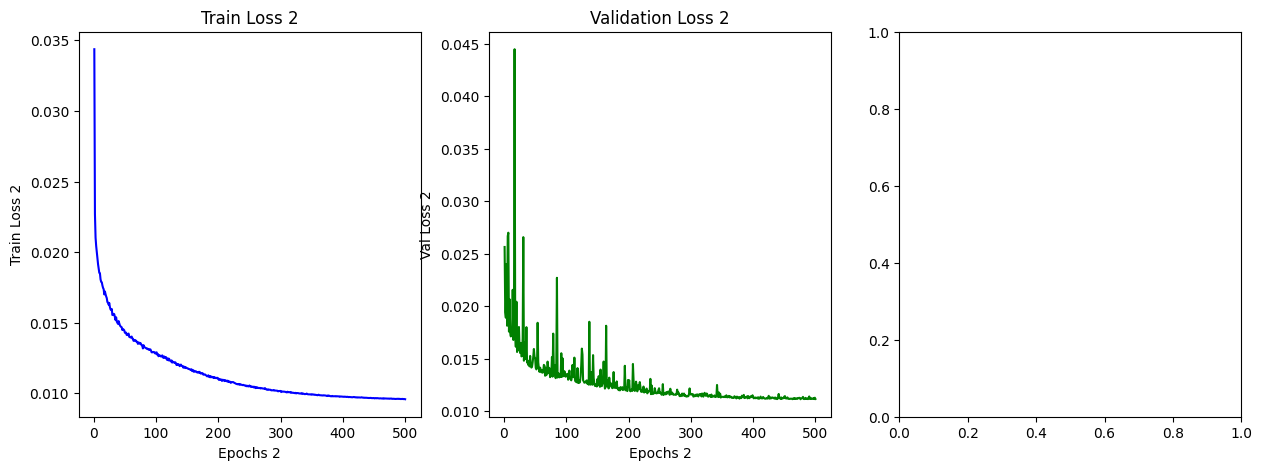

R2 score net model 2: 0.8097650288766642
MSE net model 2: 51287.22557634116

R2 random forest 2: 0.8271114226764336
MSE random forest 2: 48893.05512538962


In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
epochs = range(1, epochs_max2 + 1)
#val_loss_smooth = pd.Series(val_losses_ref).rolling(10)

axes[0].plot(epochs, train_losses_ref, color='blue')
axes[0].set_title('Train Loss deeper Arch')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')

axes[1].plot(epochs, val_losses_ref, color='green')
axes[1].set_title('Validation Loss Deeper Arch')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Val Loss')

axes[2].plot(pd.Series(val_losses_ref)).rolling(10).mean()..

#axes[1].plot(epochs, val_loss_smooth, color='red')
#axes[1].set_title('Validation Loss')
#axes[1].set_xlabel('Epochs')
#axes[1].set_ylabel('Val Loss')

plt.show()

trained_model = CHNetwork2(number_of_features2, 1)
trained_model.load_state_dict(torch.load(os.path.join('./', 'snapshot_deeper_architecture')))
trained_model.eval()

r2_net, mse_net = get_metrics(trained_model, validation_loader)

print(f'R2 score net model 2: {r2_net}')
print(f'MSE net model 2: {mse_net}')
print()
print(f'R2 random forest 2: {r2_score(ytruev_rf, ypredv_rf)}')
print(f'MSE random forest 2: {mean_squared_error(ytruev_rf, ypredv_rf, squared=False)}')

### Different Optimizer

- Different Optimizers, e.g. `SGD` with `Momentum`,  `RMSProp`, `Adam` and/or hyperparameter options (e.g. `momentum`, etc.)
- Hyperparamter tuning: in practice iterate across the full range of meaningful momentum values to identify the best fitting one
- Using the `SGD` optimizer with momentum
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different opimizers and/or parametric variations - play around!

In [31]:
#Dauert mir jetz zu lang tbh, basically für alle optimizer nochmal ein Modell trainieren und schauen was dabei rauskommt.

### Early Stopping

- Get yourself familiar with `early stopping` in neural networks
  
Build your own `EarlyStoppingCriterion` by implementing the code skeleton below:
- The constructor gets three different argurments as input:
    - `patience` - the number of epochs after the model stops training in case there was no improvement on the validation loss
    - `mode` - distinguish between two possible types: `min` (minimization of your target metric, e.g. loss) and `max` (maximizing your target metric, e.g. accuracy)
    - `min_delta (default: 0)` - provide the option for a `min_delta` (minimum value) the new/updated target metric (loss, accurarcy, f1-score, etc.) must have improved at least to consider it as an improvement
- Implement the `step` function, which takes as input the current/updated score of your target metric `cur_score` and return a boolean (`True`or `False`), in case the ealry stopping criterion is activated (no improvment for more than `patience`, your choase number of epochs, e.g. 15 epochs) or not (improvements of your metrics are still made). Reset your internal counter, whenever the metric gets improved (start from `0` and count until your `patience` criterion)
- Last step: integrate the `early stopping criterion` into your trainings routine (`training`), by calling the `step` Function, together with the `validation score` and stop the training when the `early stopping` is `True`
- In addition: further extend the given training routine (`training`) so that during training the current best state of the model (`_net.state_dict()`), i.e. the best result on the validation set, is memorized with the corresponding parameters of the model and is stored once the early stopping criterion is active or the `max number of epochs` is reached (Idea: save your best model on the validation set as snapshot)
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different architectural designs, dropout strategies, and activation functions - play around!

In [32]:
class EarlyStoppingCriterion(object):

    def __init__(self, patience, min_delta=0.0, curr_epoch_count=0):
        self.patience=patience
        self.min_delta=min_delta
        self.curr_epoch_count=curr_epoch_count
        
        return
        
    def step(self, cur_score, prev_score):
        if (prev_score - cur_score) < self.min_delta:
            if self.curr_epoch_count == self.patience:
                return True
            else:
                self.curr_epoch_count += 1
        else:
            self.curr_epoch_count = 0
            return False
        

In [46]:
import os

"""
Routine to train the neural network.
Args:
    - _net - Neural network model
    - _optimizer_fn- Type of Optimizer (torch.optim function)
    - optim_params - Parameter of Optimizer (learning rate, beta values, ...)
    - _scheduler_fn - Scheduler for learning rate
    - scheduler_params - Parameter of Scheduler (learning rate decay gamma, step-size for learning rate patience, verbose, ...)  
    - _loss_fn - Loss Function (torch.nn loss)
    - dataloader_tr - Dataloader for training set
    - dataloader_val - Dataloader for validation set
    - epochs - Maximum number of training epochs
    - apply_scheduler (default: True) - Use learning rate scheduling
    - snapshot_inverval (default: 300) - Number of epochs 
    - snap_path (default "./") - Path where to store snapshots
"""

def training_early_stopping(
             _net, 
             _optimizer_fn, 
             optim_params, 
             _scheduler_fn,
             scheduler_params,
             _loss_fn, 
             dataloader_tr, 
             dataloader_val, 
             epochs,
             early_stopping_criterion,
             filename,
             apply_scheduler=True,
             snapshot_interval=300,
             snap_path = "./",
    ):
 
    _optimizer = _optimizer_fn(_net.parameters(), **optim_params)
    _scheduler = _scheduler_fn(_optimizer, **scheduler_params)
    
    train_losses = []
    val_losses = []

    epoch_ret = None
    
    for epoch in tqdm(range(epochs)):
        epoch_ret = epoch
        
        _net.train()
        running_tr_loss = 0
        
        for i, data in enumerate(dataloader_tr):

            _optimizer.zero_grad()
            
            inputs, targets = data
            
            yhats = _net(inputs)
            
            loss = _loss_fn(yhats, targets)
            loss.backward()
            _optimizer.step()
            
            if apply_scheduler:
                _scheduler.step()
            
            running_tr_loss += loss.detach().numpy()
            
        running_tr_loss /= (i+1)

        train_losses.append(running_tr_loss)
        print("Training loss: ", running_tr_loss)
        
        running_val_loss = 0        
        _net.eval()
        
        with torch.no_grad():
            
            for i, vdata in enumerate(dataloader_val):
                vinputs, vtargets = vdata
                vloss = _loss_fn(_net(vinputs), vtargets)
                running_val_loss += vloss.detach().numpy()
            
            running_val_loss /= (i+1)
            previous_val_loss = None

            if len(val_losses) < 1:
                previous_val_loss = 0
            else:
                previous_val_loss = val_losses[len(val_losses) - 1]

            stop = early_stopping_criterion.step(running_val_loss, previous_val_loss)

            if stop:
                filename = filename
                torch.save(_net.state_dict().copy(), os.path.join(snap_path, filename))
                return train_losses, val_losses, epoch_ret

            val_losses.append(running_val_loss)
            print("Validation loss: ", running_val_loss)

    torch.save(_net.state_dict().copy(), os.path.join(snap_path, filename))
    return train_losses, val_losses, epoch_ret

In [48]:
#number of input features
number_of_features2 = X.values.shape[1]

#network
my_net_def2 = CHNetwork2(number_of_features2, 1)

#loss function
my_loss_fn2 = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_sgd = torch.optim.SGD

#scheduler
my_scheduler_fn2 = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params_sgd = {
    'lr': 0.01, 
    'momentum': 0.9
}

scheduler_params2 = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max2 = 500

#early stopping criterion
early_stopping = EarlyStoppingCriterion(15, min_delta = 0.0007)

train_losses_early_stop, val_losses_early_stop, stop_epoch = training_early_stopping(my_net_def2, 
                                          my_optimizer_fn2, 
                                          optim_params2, 
                                          my_scheduler_fn2,
                                          scheduler_params2,
                                          my_loss_fn2, 
                                          train_loader, 
                                          validation_loader, 
                                          epochs_max2,
                                          early_stopping,
                                          "snapshot_early_stopping",
                                          apply_scheduler=True,
                                          snapshot_interval=500)

  0%|                                           | 1/500 [00:01<08:26,  1.01s/it]

Training loss:  0.03245690127882798
Validation loss:  0.037580111471720266


  0%|▏                                          | 2/500 [00:02<08:21,  1.01s/it]

Training loss:  0.022290393222921374
Validation loss:  0.019335114003394934


  1%|▎                                          | 3/500 [00:02<08:12,  1.01it/s]

Training loss:  0.020850745032253735
Validation loss:  0.019916475063006


  1%|▎                                          | 4/500 [00:04<08:24,  1.02s/it]

Training loss:  0.020389481387988326
Validation loss:  0.019606229776212777


  1%|▍                                          | 5/500 [00:05<08:30,  1.03s/it]

Training loss:  0.0195817135510499
Validation loss:  0.019106591350195105


  1%|▌                                          | 6/500 [00:06<08:37,  1.05s/it]

Training loss:  0.019561181368959908
Validation loss:  0.018099930003493258


  1%|▌                                          | 7/500 [00:07<08:31,  1.04s/it]

Training loss:  0.01920618945998375
Validation loss:  0.01762928608844912


  2%|▋                                          | 8/500 [00:08<08:32,  1.04s/it]

Training loss:  0.01896294074226271
Validation loss:  0.027913040807270823


  2%|▊                                          | 9/500 [00:09<08:23,  1.03s/it]

Training loss:  0.018857510841629028
Validation loss:  0.018210898888948904


  2%|▊                                         | 10/500 [00:10<08:15,  1.01s/it]

Training loss:  0.018776424122880043
Validation loss:  0.019471215352000342


  2%|▉                                         | 11/500 [00:11<08:08,  1.00it/s]

Training loss:  0.01828192213532165
Validation loss:  0.017471802803635788


  2%|█                                         | 12/500 [00:12<08:11,  1.01s/it]

Training loss:  0.01806178839879253
Validation loss:  0.02538764265729634


  3%|█                                         | 13/500 [00:13<08:06,  1.00it/s]

Training loss:  0.017908007351619435
Validation loss:  0.017227878795073332


  3%|█▏                                        | 14/500 [00:14<08:01,  1.01it/s]

Training loss:  0.017971649307324537
Validation loss:  0.021480199193398074


  3%|█▎                                        | 15/500 [00:15<08:01,  1.01it/s]

Training loss:  0.0176675758485966
Validation loss:  0.016844011035791796


  3%|█▎                                        | 16/500 [00:16<08:05,  1.00s/it]

Training loss:  0.017548404942518272
Validation loss:  0.02196557546442159


  3%|█▍                                        | 17/500 [00:17<08:02,  1.00it/s]

Training loss:  0.017413359940396892
Validation loss:  0.016526856501646692


  4%|█▌                                        | 18/500 [00:18<08:02,  1.00s/it]

Training loss:  0.01723232294434824
Validation loss:  0.018109611214574252


  4%|█▌                                        | 19/500 [00:19<07:57,  1.01it/s]

Training loss:  0.01706107226034989
Validation loss:  0.02048750202743089


  4%|█▋                                        | 20/500 [00:20<07:56,  1.01it/s]

Training loss:  0.01699938298156936
Validation loss:  0.01920039030871166


  4%|█▊                                        | 21/500 [00:21<07:52,  1.01it/s]

Training loss:  0.01689536616144014
Validation loss:  0.02015943020830019


  4%|█▊                                        | 22/500 [00:22<07:48,  1.02it/s]

Training loss:  0.016789169771049425
Validation loss:  0.018634786965253527


  5%|█▉                                        | 23/500 [00:23<07:46,  1.02it/s]

Training loss:  0.01660740324804826
Validation loss:  0.02182176043659193


  5%|██                                        | 24/500 [00:24<07:40,  1.03it/s]

Training loss:  0.016667206354381115
Validation loss:  0.015806402882177367


  5%|██                                        | 25/500 [00:24<07:38,  1.03it/s]

Training loss:  0.016424481353102968
Validation loss:  0.015592957893786192


  5%|██▏                                       | 26/500 [00:26<07:59,  1.01s/it]

Training loss:  0.016493011180529985
Validation loss:  0.016330893848954735


  5%|██▎                                       | 27/500 [00:27<08:06,  1.03s/it]

Training loss:  0.016076797378235433
Validation loss:  0.019882880710864782


  6%|██▎                                       | 28/500 [00:28<08:04,  1.03s/it]

Training loss:  0.016093895433017476
Validation loss:  0.015865117396415877


  6%|██▍                                       | 29/500 [00:29<08:06,  1.03s/it]

Training loss:  0.01594268136436723
Validation loss:  0.01565474956875963


  6%|██▌                                       | 30/500 [00:30<08:05,  1.03s/it]

Training loss:  0.01593462746205416
Validation loss:  0.015524469065188146


  6%|██▌                                       | 31/500 [00:31<08:14,  1.05s/it]

Training loss:  0.01588117185878829
Validation loss:  0.016982923891363355


  6%|██▋                                       | 32/500 [00:32<08:04,  1.04s/it]

Training loss:  0.01568683481372219
Validation loss:  0.01812829335256132


  7%|██▊                                       | 33/500 [00:33<07:57,  1.02s/it]

Training loss:  0.01570191754397121
Validation loss:  0.015831792353384614


  7%|██▊                                       | 34/500 [00:34<08:01,  1.03s/it]

Training loss:  0.015442796543729768
Validation loss:  0.017561359339005957


  7%|██▉                                       | 35/500 [00:35<07:51,  1.01s/it]

Training loss:  0.015372025077125966
Validation loss:  0.014775217236958987


  7%|███                                       | 36/500 [00:36<07:43,  1.00it/s]

Training loss:  0.015318842098744439
Validation loss:  0.016626916774308765


  7%|███                                       | 37/500 [00:37<07:51,  1.02s/it]

Training loss:  0.015273543984997131
Validation loss:  0.01880069806284467


  8%|███▏                                      | 38/500 [00:38<07:50,  1.02s/it]

Training loss:  0.015350364385958685
Validation loss:  0.015312551979431203


  8%|███▎                                      | 39/500 [00:39<07:43,  1.01s/it]

Training loss:  0.015139540831710787
Validation loss:  0.0168403225487234


  8%|███▎                                      | 40/500 [00:40<07:47,  1.02s/it]

Training loss:  0.014848721297723477
Validation loss:  0.014643888344964244


  8%|███▍                                      | 41/500 [00:41<08:00,  1.05s/it]

Training loss:  0.014919899981739591
Validation loss:  0.014688756792554273


  8%|███▌                                      | 42/500 [00:42<08:00,  1.05s/it]

Training loss:  0.014858631870034677
Validation loss:  0.01500391838332646


  9%|███▌                                      | 43/500 [00:43<07:47,  1.02s/it]

Training loss:  0.014751781031300901
Validation loss:  0.014624972948644614


  9%|███▋                                      | 44/500 [00:44<07:38,  1.01s/it]

Training loss:  0.014728591283778304
Validation loss:  0.016826287575481786


  9%|███▊                                      | 45/500 [00:45<07:50,  1.03s/it]

Training loss:  0.014741907482445481
Validation loss:  0.014260864167078498


  9%|███▊                                      | 46/500 [00:46<07:46,  1.03s/it]

Training loss:  0.014571964498398779
Validation loss:  0.014102930512355217


  9%|███▉                                      | 47/500 [00:47<07:45,  1.03s/it]

Training loss:  0.014589259298207525
Validation loss:  0.01628063510815601


 10%|████                                      | 48/500 [00:48<07:36,  1.01s/it]

Training loss:  0.014510815219544636
Validation loss:  0.013868554811045335


 10%|████                                      | 49/500 [00:49<07:35,  1.01s/it]

Training loss:  0.014384439754659717
Validation loss:  0.016260286979976835


 10%|████▏                                     | 50/500 [00:50<07:25,  1.01it/s]

Training loss:  0.01428604200487381
Validation loss:  0.017037011565072983


 10%|████▎                                     | 51/500 [00:51<07:18,  1.02it/s]

Training loss:  0.014234537648466146
Validation loss:  0.015255477274428301


 10%|████▎                                     | 52/500 [00:52<07:20,  1.02it/s]

Training loss:  0.014314239043431643
Validation loss:  0.014325270140463638


 11%|████▍                                     | 53/500 [00:53<07:32,  1.01s/it]

Training loss:  0.014171784092292222
Validation loss:  0.014007889862520053


 11%|████▌                                     | 54/500 [00:54<07:31,  1.01s/it]

Training loss:  0.014357410731952963
Validation loss:  0.021080155814937895


 11%|████▌                                     | 55/500 [00:55<07:28,  1.01s/it]

Training loss:  0.01412038909611207
Validation loss:  0.014625978993867472


 11%|████▋                                     | 56/500 [00:56<07:30,  1.02s/it]

Training loss:  0.014112492236815016
Validation loss:  0.014337087310890591


 11%|████▊                                     | 57/500 [00:57<07:35,  1.03s/it]

Training loss:  0.014029908839831745
Validation loss:  0.013841399865009114


 12%|████▊                                     | 58/500 [00:58<07:34,  1.03s/it]

Training loss:  0.013992903647223534
Validation loss:  0.013981905688887438


 12%|████▉                                     | 59/500 [00:59<07:31,  1.02s/it]

Training loss:  0.014052215645684228
Validation loss:  0.013761169439013808


 12%|█████                                     | 60/500 [01:00<07:39,  1.04s/it]

Training loss:  0.013869881411774768
Validation loss:  0.013687779711231654


 12%|█████                                     | 61/500 [01:02<07:55,  1.08s/it]

Training loss:  0.013818167321949364
Validation loss:  0.014034971217085235


 12%|█████▏                                    | 62/500 [01:03<08:05,  1.11s/it]

Training loss:  0.013868868658248941
Validation loss:  0.016286372139154584


 13%|█████▎                                    | 63/500 [01:04<07:47,  1.07s/it]

Training loss:  0.013804276875572117
Validation loss:  0.015102574471863937


 13%|█████▍                                    | 64/500 [01:05<07:31,  1.04s/it]

Training loss:  0.013744806723450626
Validation loss:  0.013489946269314304


 13%|█████▍                                    | 65/500 [01:06<07:27,  1.03s/it]

Training loss:  0.013764774082208492
Validation loss:  0.014322837463943807


 13%|█████▌                                    | 66/500 [01:07<07:25,  1.03s/it]

Training loss:  0.013583329035168708
Validation loss:  0.01369731976298911


 13%|█████▋                                    | 67/500 [01:08<07:24,  1.03s/it]

Training loss:  0.013780322130889791
Validation loss:  0.013734695754441644


 14%|█████▋                                    | 68/500 [01:09<07:38,  1.06s/it]

Training loss:  0.013759662121017058
Validation loss:  0.01450403316082361


 14%|█████▊                                    | 69/500 [01:10<07:47,  1.09s/it]

Training loss:  0.013567980760317476
Validation loss:  0.014195185305566682


 14%|█████▉                                    | 70/500 [01:11<07:52,  1.10s/it]

Training loss:  0.013597588407590512
Validation loss:  0.01342888910607175


 14%|█████▉                                    | 71/500 [01:12<07:36,  1.06s/it]

Training loss:  0.01353976955756132
Validation loss:  0.013812092536572734


 14%|██████                                    | 72/500 [01:13<07:21,  1.03s/it]

Training loss:  0.013516164573001704
Validation loss:  0.013735497657153676


 15%|██████▏                                   | 73/500 [01:14<07:20,  1.03s/it]

Training loss:  0.013402504972768677
Validation loss:  0.013925489708210408


 15%|██████▏                                   | 74/500 [01:15<07:35,  1.07s/it]

Training loss:  0.013465660606286378
Validation loss:  0.01391615283119896


 15%|██████▎                                   | 75/500 [01:16<07:39,  1.08s/it]

Training loss:  0.01334479480465038
Validation loss:  0.013738406271485875


 15%|██████▍                                   | 76/500 [01:17<07:35,  1.07s/it]

Training loss:  0.013390185172590392
Validation loss:  0.013788973363995745


 15%|██████▍                                   | 77/500 [01:18<07:24,  1.05s/it]

Training loss:  0.013316906377221022
Validation loss:  0.013471464081887204


 16%|██████▌                                   | 78/500 [01:19<07:14,  1.03s/it]

Training loss:  0.01321195931558821
Validation loss:  0.014395915415505738


 16%|██████▋                                   | 79/500 [01:20<07:11,  1.03s/it]

Training loss:  0.013271591517837683
Validation loss:  0.013377878379752227


 16%|██████▋                                   | 80/500 [01:21<07:07,  1.02s/it]

Training loss:  0.013381228360434667
Validation loss:  0.014970855531082869


 16%|██████▊                                   | 81/500 [01:22<07:00,  1.00s/it]

Training loss:  0.01323564723735541
Validation loss:  0.014855391297953068


 16%|██████▉                                   | 82/500 [01:23<07:06,  1.02s/it]

Training loss:  0.013355464939443059
Validation loss:  0.013260856779919769


 17%|██████▉                                   | 83/500 [01:25<07:20,  1.06s/it]

Training loss:  0.01316797086894833
Validation loss:  0.01829139375259756


 17%|███████                                   | 84/500 [01:26<07:26,  1.07s/it]

Training loss:  0.013240931063902487
Validation loss:  0.013659580980923203


 17%|███████▏                                  | 85/500 [01:27<07:19,  1.06s/it]

Training loss:  0.013156852893059144
Validation loss:  0.014463711199710393


 17%|███████▏                                  | 86/500 [01:28<07:12,  1.04s/it]

Training loss:  0.013036239652396194
Validation loss:  0.013300224504125796


 17%|███████▎                                  | 87/500 [01:29<07:02,  1.02s/it]

Training loss:  0.013054215811158905
Validation loss:  0.013599879895296955


 18%|███████▍                                  | 88/500 [01:30<06:56,  1.01s/it]

Training loss:  0.013075904289372787
Validation loss:  0.014948407725666853


 18%|███████▍                                  | 89/500 [01:31<06:54,  1.01s/it]

Training loss:  0.012932089284594713
Validation loss:  0.013738603644920393


 18%|███████▌                                  | 90/500 [01:32<06:59,  1.02s/it]

Training loss:  0.013070817285671478
Validation loss:  0.013118203022405345


 18%|███████▋                                  | 91/500 [01:33<07:02,  1.03s/it]

Training loss:  0.012943129094048886
Validation loss:  0.013377929433117034


 18%|███████▋                                  | 92/500 [01:34<06:54,  1.02s/it]

Training loss:  0.013002068959968515
Validation loss:  0.014365824367131541


 19%|███████▊                                  | 93/500 [01:35<06:57,  1.03s/it]

Training loss:  0.012955483119579912
Validation loss:  0.013911632591131035


 19%|███████▉                                  | 94/500 [01:36<06:59,  1.03s/it]

Training loss:  0.012920901334199921
Validation loss:  0.013601044152939269


 19%|███████▉                                  | 95/500 [01:37<06:46,  1.00s/it]

Training loss:  0.012866546286107618
Validation loss:  0.014310441556478582


 19%|████████                                  | 96/500 [01:38<06:41,  1.01it/s]

Training loss:  0.012848134179157481
Validation loss:  0.014820134629947114


 19%|████████▏                                 | 97/500 [01:39<06:38,  1.01it/s]

Training loss:  0.01293680080590094
Validation loss:  0.021693910130343597


 20%|████████▏                                 | 98/500 [01:40<06:37,  1.01it/s]

Training loss:  0.012844144608660032
Validation loss:  0.014579167023956648


 20%|████████▎                                 | 99/500 [01:41<06:51,  1.03s/it]

Training loss:  0.012825531810592254
Validation loss:  0.015546102042293952


 20%|████████▏                                | 100/500 [01:42<06:55,  1.04s/it]

Training loss:  0.012857060985859238
Validation loss:  0.013296545985806334


 20%|████████▎                                | 101/500 [01:43<07:04,  1.06s/it]

Training loss:  0.012773322180152617
Validation loss:  0.01308666280962431


 20%|████████▎                                | 102/500 [01:44<07:03,  1.06s/it]

Training loss:  0.012812021111496057
Validation loss:  0.014471040892738513


 21%|████████▍                                | 103/500 [01:45<06:51,  1.04s/it]

Training loss:  0.012746157836789552
Validation loss:  0.014968646386470406


 21%|████████▌                                | 104/500 [01:46<07:01,  1.06s/it]

Training loss:  0.012671408280945784
Validation loss:  0.013503558065366527


 21%|████████▌                                | 105/500 [01:47<07:03,  1.07s/it]

Training loss:  0.012591244941837965
Validation loss:  0.0129429096333051


 21%|████████▋                                | 106/500 [01:48<07:02,  1.07s/it]

Training loss:  0.012643145779759269
Validation loss:  0.01339936152484284


 21%|████████▊                                | 107/500 [01:49<06:52,  1.05s/it]

Training loss:  0.012602340015612815
Validation loss:  0.01288949993494978


 22%|████████▊                                | 108/500 [01:50<06:45,  1.03s/it]

Training loss:  0.012576931191305554
Validation loss:  0.014973993020435963


 22%|████████▉                                | 109/500 [01:51<06:51,  1.05s/it]

Training loss:  0.012621358532731225
Validation loss:  0.016234723834097065


 22%|█████████                                | 110/500 [01:52<06:39,  1.02s/it]

Training loss:  0.012462606087910458
Validation loss:  0.012773906383883257


 22%|█████████                                | 111/500 [01:53<06:35,  1.02s/it]

Training loss:  0.012551946866258866
Validation loss:  0.012887501347682124


 22%|█████████▏                               | 112/500 [01:54<06:30,  1.01s/it]

Training loss:  0.012555828110732949
Validation loss:  0.012993462832420744


 23%|█████████▎                               | 113/500 [01:55<06:32,  1.01s/it]

Training loss:  0.012498834463005808
Validation loss:  0.01310047738417951


 23%|█████████▎                               | 114/500 [01:56<06:34,  1.02s/it]

Training loss:  0.012473336989621444
Validation loss:  0.013024611378592227


 23%|█████████▍                               | 115/500 [01:57<06:27,  1.01s/it]

Training loss:  0.01244904775326857
Validation loss:  0.014589148191855061


 23%|█████████▌                               | 116/500 [01:58<06:21,  1.01it/s]

Training loss:  0.012420970692165974
Validation loss:  0.01346599096442321


 23%|█████████▌                               | 117/500 [01:59<06:23,  1.00s/it]

Training loss:  0.012379745325470589
Validation loss:  0.012711874478148864


 24%|█████████▋                               | 118/500 [02:00<06:28,  1.02s/it]

Training loss:  0.012370100495504743
Validation loss:  0.013094559483741742


 24%|█████████▊                               | 119/500 [02:01<06:27,  1.02s/it]

Training loss:  0.012338217654500048
Validation loss:  0.013087669982526915


 24%|█████████▊                               | 120/500 [02:02<06:19,  1.00it/s]

Training loss:  0.012381491475097987
Validation loss:  0.012743501255464593


 24%|█████████▉                               | 121/500 [02:04<06:28,  1.02s/it]

Training loss:  0.012295052598769885
Validation loss:  0.013154509992442642


 24%|██████████                               | 122/500 [02:05<06:23,  1.01s/it]

Training loss:  0.012341973841099111
Validation loss:  0.013758783500497689


 25%|██████████                               | 123/500 [02:06<06:27,  1.03s/it]

Training loss:  0.012314682795322301
Validation loss:  0.013834551306513374


 25%|██████████▏                              | 124/500 [02:07<06:19,  1.01s/it]

Training loss:  0.01229545896806713
Validation loss:  0.013601545168010942


 25%|██████████▎                              | 125/500 [02:08<06:19,  1.01s/it]

Training loss:  0.012230112413480774
Validation loss:  0.012635700185803194


 25%|██████████▎                              | 126/500 [02:09<06:15,  1.00s/it]

Training loss:  0.012267536524682234
Validation loss:  0.013518937837178599


 25%|██████████▍                              | 127/500 [02:10<06:12,  1.00it/s]

Training loss:  0.01223129725880195
Validation loss:  0.013015292385541095


 26%|██████████▍                              | 128/500 [02:11<06:08,  1.01it/s]

Training loss:  0.01223878182628191
Validation loss:  0.012851880762382318


 26%|██████████▌                              | 129/500 [02:12<06:11,  1.00s/it]

Training loss:  0.012199175689320317
Validation loss:  0.014680000036043543


 26%|██████████▋                              | 130/500 [02:13<06:13,  1.01s/it]

Training loss:  0.012148452581977122
Validation loss:  0.012815883623480061


 26%|██████████▋                              | 131/500 [02:14<06:09,  1.00s/it]

Training loss:  0.012105482277802249
Validation loss:  0.012973105925626957


 26%|██████████▊                              | 132/500 [02:15<06:18,  1.03s/it]

Training loss:  0.01211683123622619
Validation loss:  0.012904275690860919


 27%|██████████▉                              | 133/500 [02:16<06:22,  1.04s/it]

Training loss:  0.01219413092082208
Validation loss:  0.012593224569215827


 27%|██████████▉                              | 134/500 [02:17<06:19,  1.04s/it]

Training loss:  0.012116618016614419
Validation loss:  0.01299120565324766


 27%|███████████                              | 135/500 [02:18<06:09,  1.01s/it]

Training loss:  0.012043667185011013
Validation loss:  0.012812874841507796


 27%|███████████▏                             | 136/500 [02:19<06:03,  1.00it/s]

Training loss:  0.012087899136163528
Validation loss:  0.013680645996652736


 27%|███████████▏                             | 137/500 [02:20<06:04,  1.00s/it]

Training loss:  0.012012991629038667
Validation loss:  0.012687732020888654


 28%|███████████▎                             | 138/500 [02:21<06:13,  1.03s/it]

Training loss:  0.011971714529579763
Validation loss:  0.012588109549278866


 28%|███████████▍                             | 139/500 [02:22<06:18,  1.05s/it]

Training loss:  0.012012224580889089
Validation loss:  0.012658087538691166


 28%|███████████▍                             | 140/500 [02:23<06:16,  1.05s/it]

Training loss:  0.01201455349546724
Validation loss:  0.01269456154622873


 28%|███████████▌                             | 141/500 [02:24<06:18,  1.05s/it]

Training loss:  0.011965564608501733
Validation loss:  0.012692771070584847


 28%|███████████▋                             | 142/500 [02:25<06:11,  1.04s/it]

Training loss:  0.011964408078168762
Validation loss:  0.014494898586879712


 29%|███████████▋                             | 143/500 [02:26<06:00,  1.01s/it]

Training loss:  0.011926317564562661
Validation loss:  0.012583308347077169


 29%|███████████▊                             | 144/500 [02:27<05:52,  1.01it/s]

Training loss:  0.01183458444395727
Validation loss:  0.012581501559298406


 29%|███████████▉                             | 145/500 [02:28<05:46,  1.02it/s]

Training loss:  0.011892311410092227
Validation loss:  0.0124721760954508


 29%|███████████▉                             | 146/500 [02:29<05:42,  1.03it/s]

Training loss:  0.011833524334082026
Validation loss:  0.012735375545443288


 29%|████████████                             | 147/500 [02:30<05:39,  1.04it/s]

Training loss:  0.011809562077666598
Validation loss:  0.013851042751966308


 30%|████████████▏                            | 148/500 [02:31<05:36,  1.05it/s]

Training loss:  0.011824127442561354
Validation loss:  0.015196658580967668


 30%|████████████▏                            | 149/500 [02:32<05:33,  1.05it/s]

Training loss:  0.011787346260726403
Validation loss:  0.01332352438425973


 30%|████████████▎                            | 150/500 [02:33<05:34,  1.05it/s]

Training loss:  0.011801756176141676
Validation loss:  0.012428932039061154


 30%|████████████▍                            | 151/500 [02:33<05:32,  1.05it/s]

Training loss:  0.011775895943779967
Validation loss:  0.01254863330201034


 30%|████████████▍                            | 152/500 [02:34<05:31,  1.05it/s]

Training loss:  0.011797725915231124
Validation loss:  0.012497235518228662


 31%|████████████▌                            | 153/500 [02:35<05:30,  1.05it/s]

Training loss:  0.011700799955988446
Validation loss:  0.01261053512536405


 31%|████████████▋                            | 154/500 [02:36<05:28,  1.05it/s]

Training loss:  0.011672461978450569
Validation loss:  0.012679382490669676


 31%|████████████▋                            | 155/500 [02:37<05:26,  1.06it/s]

Training loss:  0.011663517213087685
Validation loss:  0.0123154170528382


 31%|████████████▊                            | 156/500 [02:38<05:25,  1.06it/s]

Training loss:  0.011753166947549909
Validation loss:  0.012462967515587326


 31%|████████████▊                            | 157/500 [02:39<05:24,  1.06it/s]

Training loss:  0.011664692092367595
Validation loss:  0.012329764569242178


 32%|████████████▉                            | 158/500 [02:40<05:23,  1.06it/s]

Training loss:  0.011623189810651432
Validation loss:  0.012974399022054519


 32%|█████████████                            | 159/500 [02:41<05:22,  1.06it/s]

Training loss:  0.011624085412268498
Validation loss:  0.012644669311840584


 32%|█████████████                            | 160/500 [02:42<05:21,  1.06it/s]

Training loss:  0.01161152482848811
Validation loss:  0.013377258116918988


 32%|█████████████▏                           | 161/500 [02:43<05:20,  1.06it/s]

Training loss:  0.011639210505414036
Validation loss:  0.01386013418803783


 32%|█████████████▎                           | 162/500 [02:44<05:19,  1.06it/s]

Training loss:  0.011626329859197381
Validation loss:  0.012828312150968135


 33%|█████████████▎                           | 163/500 [02:45<05:20,  1.05it/s]

Training loss:  0.011587772495965439
Validation loss:  0.01231406168870292


 33%|█████████████▍                           | 164/500 [02:46<05:18,  1.05it/s]

Training loss:  0.01155100947028413
Validation loss:  0.015318697902010235


 33%|█████████████▌                           | 165/500 [02:47<05:17,  1.05it/s]

Training loss:  0.011518063805135221
Validation loss:  0.012301465611337272


 33%|█████████████▌                           | 166/500 [02:48<05:16,  1.05it/s]

Training loss:  0.011521533832848232
Validation loss:  0.012300071174622606


 33%|█████████████▋                           | 167/500 [02:49<05:14,  1.06it/s]

Training loss:  0.01148459823592591
Validation loss:  0.01229544540631381


 34%|█████████████▊                           | 168/500 [02:50<05:13,  1.06it/s]

Training loss:  0.0114466286799695
Validation loss:  0.012260328003509138


 34%|█████████████▊                           | 169/500 [02:51<05:12,  1.06it/s]

Training loss:  0.011488802968253721
Validation loss:  0.012370694139892387


 34%|█████████████▉                           | 170/500 [02:51<05:10,  1.06it/s]

Training loss:  0.011426751108251641
Validation loss:  0.012318534048098287


 34%|██████████████                           | 171/500 [02:52<05:10,  1.06it/s]

Training loss:  0.011427348673612328
Validation loss:  0.012253870223269122


 34%|██████████████                           | 172/500 [02:53<05:09,  1.06it/s]

Training loss:  0.011462229824814428
Validation loss:  0.012194921027733084


 35%|██████████████▏                          | 173/500 [02:54<05:12,  1.05it/s]

Training loss:  0.011382387227399336
Validation loss:  0.012194796665691543


 35%|██████████████▎                          | 174/500 [02:55<05:11,  1.05it/s]

Training loss:  0.011429368401125708
Validation loss:  0.012402384071271115


 35%|██████████████▎                          | 175/500 [02:56<05:09,  1.05it/s]

Training loss:  0.011389231813802867
Validation loss:  0.012676999933693894


 35%|██████████████▍                          | 176/500 [02:57<05:07,  1.05it/s]

Training loss:  0.011295668749475553
Validation loss:  0.012491342448729367


 35%|██████████████▌                          | 177/500 [02:58<05:06,  1.05it/s]

Training loss:  0.011333215968438752
Validation loss:  0.012204689225042038


 36%|██████████████▌                          | 178/500 [02:59<05:04,  1.06it/s]

Training loss:  0.011339158274131086
Validation loss:  0.01235185157309802


 36%|██████████████▋                          | 179/500 [03:00<05:04,  1.06it/s]

Training loss:  0.011341249887541786
Validation loss:  0.014214641550483877


 36%|██████████████▊                          | 180/500 [03:01<05:06,  1.04it/s]

Training loss:  0.011358248449078049
Validation loss:  0.013701811205004162


 36%|██████████████▊                          | 181/500 [03:02<05:08,  1.03it/s]

Training loss:  0.011228221444692764
Validation loss:  0.012244576024183357


 36%|██████████████▉                          | 182/500 [03:03<05:08,  1.03it/s]

Training loss:  0.011263350014293124
Validation loss:  0.013460883914688882


 37%|███████████████                          | 183/500 [03:04<05:07,  1.03it/s]

Training loss:  0.011252070120480653
Validation loss:  0.012450018369536768


 37%|███████████████                          | 184/500 [03:05<05:07,  1.03it/s]

Training loss:  0.011266221789055703
Validation loss:  0.012122063162085068


 37%|███████████████▏                         | 185/500 [03:06<05:07,  1.02it/s]

Training loss:  0.011227686960521817
Validation loss:  0.013552653173568295


 37%|███████████████▎                         | 186/500 [03:07<05:13,  1.00it/s]

Training loss:  0.011233299173639267
Validation loss:  0.012490302441210003


 37%|███████████████▎                         | 187/500 [03:08<05:10,  1.01it/s]

Training loss:  0.011214716552703594
Validation loss:  0.012346019799013666


 38%|███████████████▍                         | 188/500 [03:09<05:14,  1.01s/it]

Training loss:  0.011194707651094276
Validation loss:  0.012379104344478045


 38%|███████████████▍                         | 189/500 [03:10<05:11,  1.00s/it]

Training loss:  0.011160385690677602
Validation loss:  0.012298747195658382


 38%|███████████████▌                         | 190/500 [03:11<05:06,  1.01it/s]

Training loss:  0.011180953037086975
Validation loss:  0.012209517893265501


 38%|███████████████▋                         | 191/500 [03:12<05:11,  1.01s/it]

Training loss:  0.011098295881661543
Validation loss:  0.012022655366824005


 38%|███████████████▋                         | 192/500 [03:13<05:22,  1.05s/it]

Training loss:  0.011125077397374093
Validation loss:  0.012112176160192188


 39%|███████████████▊                         | 193/500 [03:14<05:31,  1.08s/it]

Training loss:  0.011119694668680341
Validation loss:  0.012129852836032282


 39%|███████████████▉                         | 194/500 [03:15<05:19,  1.04s/it]

Training loss:  0.011059930346068095
Validation loss:  0.014766809424633247


 39%|███████████████▉                         | 195/500 [03:16<05:18,  1.04s/it]

Training loss:  0.011158182983591438
Validation loss:  0.012002090196017287


 39%|████████████████                         | 196/500 [03:17<05:09,  1.02s/it]

Training loss:  0.011095950008917348
Validation loss:  0.011978566932867685


 39%|████████████████▏                        | 197/500 [03:18<05:06,  1.01s/it]

Training loss:  0.01105035758871521
Validation loss:  0.01195310356691


 40%|████████████████▏                        | 198/500 [03:19<05:01,  1.00it/s]

Training loss:  0.0111023620148445
Validation loss:  0.012155645589899799


 40%|████████████████▎                        | 199/500 [03:20<05:03,  1.01s/it]

Training loss:  0.01106070844277106
Validation loss:  0.01215345030220809


 40%|████████████████▍                        | 200/500 [03:21<04:59,  1.00it/s]

Training loss:  0.01103720415282826
Validation loss:  0.012294970108535893


 40%|████████████████▍                        | 201/500 [03:22<04:57,  1.01it/s]

Training loss:  0.010994736363598025
Validation loss:  0.012195126593708512


 40%|████████████████▌                        | 202/500 [03:23<04:57,  1.00it/s]

Training loss:  0.010993445748127436
Validation loss:  0.012134303468231576


 41%|████████████████▋                        | 203/500 [03:24<04:53,  1.01it/s]

Training loss:  0.011022700665496587
Validation loss:  0.012613758232940165


 41%|████████████████▋                        | 204/500 [03:25<05:00,  1.01s/it]

Training loss:  0.010996668862451603
Validation loss:  0.012015773113337326


 41%|████████████████▊                        | 205/500 [03:26<05:09,  1.05s/it]

Training loss:  0.010934168099830744
Validation loss:  0.011878771437112193


 41%|████████████████▉                        | 206/500 [03:27<05:13,  1.07s/it]

Training loss:  0.010964491827146775
Validation loss:  0.012789178021100266


 41%|████████████████▉                        | 207/500 [03:28<05:08,  1.05s/it]

Training loss:  0.010942520707067747
Validation loss:  0.012344402229601254


 42%|█████████████████                        | 208/500 [03:29<05:01,  1.03s/it]

Training loss:  0.01096923578315263
Validation loss:  0.01209291271503631


 42%|█████████████████▏                       | 209/500 [03:31<05:05,  1.05s/it]

Training loss:  0.010931481139529376
Validation loss:  0.011922239928502318


 42%|█████████████████▏                       | 210/500 [03:32<04:56,  1.02s/it]

Training loss:  0.01095916618544416
Validation loss:  0.012768764659370668


 42%|█████████████████▏                       | 210/500 [03:33<04:54,  1.01s/it]

Training loss:  0.010926964908810202


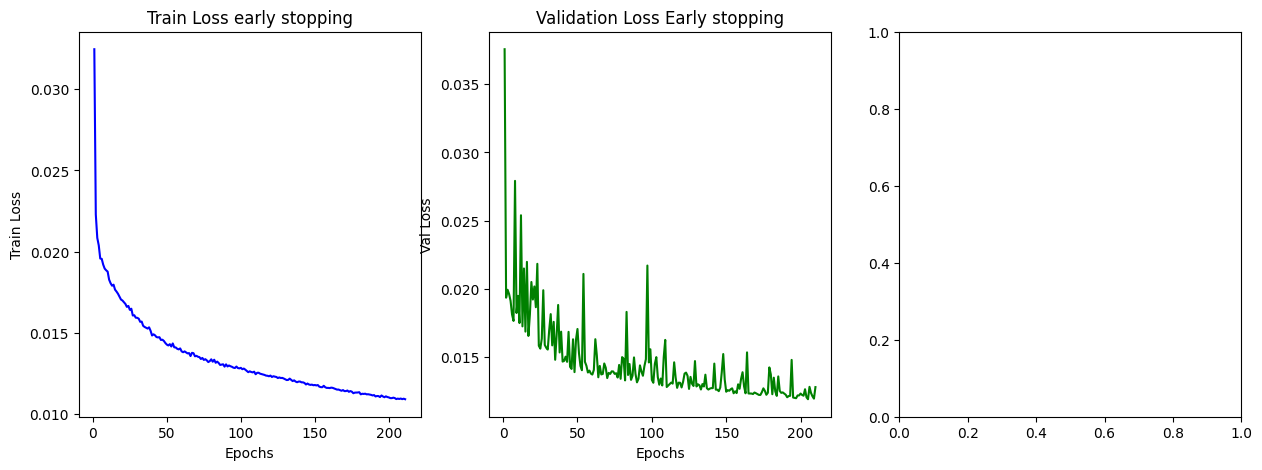

R2 score net early stopping: 0.7921508806212577
MSE net early topping: 53609.05135557855

R2 random forest 2: 0.8271114226764336
MSE random forest 2: 48893.05512538962


In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
epochs_train = range(1, (stop_epoch + 2))
epochs_val = range(1, (stop_epoch + 1))
#val_loss_smooth = pd.Series(val_losses_ref).rolling(10)

axes[0].plot(epochs_train, train_losses_early_stop, color='blue')
axes[0].set_title('Train Loss early stopping')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')

axes[1].plot(epochs_val, val_losses_early_stop, color='green')
axes[1].set_title('Validation Loss Early stopping')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Val Loss')

#axes[1].plot(epochs, val_loss_smooth, color='red')
#axes[1].set_title('Validation Loss')
#axes[1].set_xlabel('Epochs')
#axes[1].set_ylabel('Val Loss')

plt.show()

trained_model = CHNetwork2(number_of_features2, 1)
trained_model.load_state_dict(torch.load(os.path.join('./', 'snapshot_early_stopping')))
trained_model.eval()

r2_net, mse_net = get_metrics(trained_model, validation_loader)

print(f'R2 score net early stopping: {r2_net}')
print(f'MSE net early topping: {mse_net}')
print()
print(f'R2 random forest 2: {r2_score(ytruev_rf, ypredv_rf)}')
print(f'MSE random forest 2: {mean_squared_error(ytruev_rf, ypredv_rf, squared=False)}')

### Dropout

- Get yourself familiar with `dropout` in neural networks: see https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

Change your initial `CHNetwork` implementation to also integrate dropout (same network depth, but more parameters) and realize the following architectural design:
- Model Design: `Dropout Layer`, `Input Layer`, `Dropout Layer before every of the 3x Hidden Layer`, `Output Layer`
- Specific `dropout_rate_input` for the `input layer` and `dropout_rate` for all the remaining `hidden layer` 
- Layer Shapes: `8 to 1024`, `1024 to 1024`, `1024 to 512`, `512 to 64`, `64 to 1`
- Activation Functions: `relu` activation after each `linear layer` (fully-connected), except the final output layer
- Implement the `__init__` and `forward` function (see example above)
- Return `x`
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different architectural designs, dropout strategies, and activation functions - play around!

In [64]:
# Solution
import torch
import torch.nn as nn

class CHNetworkDropout(nn.Module):

    def __init__(self, input_size, output_size, dropout_rate=0.5, dropout_rate_input=0):
        super(CHNetworkDropout, self).__init__()
        self.dropout_input = nn.Dropout(p=dropout_rate_input)
        self.dropout_general = nn.Dropout(p=dropout_rate)
        self.linear01 = nn.Linear(8, 1024)
        self.linear02 = nn.Linear(1024, 1024)
        self.linear03 = nn.Linear(1024, 512)
        self.linear04 = nn.Linear(512, 64)
        self.linear05 = nn.Linear(64, 1)

       
    def forward(self, input):
        x = torch.relu(self.linear01(input))
        x = self.dropout_input(x)
        
        x = torch.relu(self.linear02(x))
        x = self.dropout_general(x)
        
        x = torch.relu(self.linear03(x))
        x = self.dropout_general(x)
        
        x = torch.relu(self.linear04(x))
        x = self.dropout_general(x)
        
        x = self.linear05(x)
        return x
        

In [66]:
#number of input features
number_of_features2 = X.values.shape[1]

#network
my_net_def2 = CHNetworkDropout(number_of_features2, 1)

#loss function
my_loss_fn2 = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_sgd = torch.optim.SGD

#scheduler
my_scheduler_fn2 = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params_sgd = {
    'lr': 0.01, 
    'momentum': 0.9
}

scheduler_params2 = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max2 = 500

train_losses_early_stop, val_losses_early_stop = training(my_net_def2, 
                                          my_optimizer_fn2, 
                                          optim_params2, 
                                          my_scheduler_fn2,
                                          scheduler_params2,
                                          my_loss_fn2, 
                                          train_loader, 
                                          validation_loader, 
                                          epochs_max2,
                                          "snapshot_dropout",
                                          apply_scheduler=True,
                                          snapshot_interval=500)

  0%|                                           | 1/500 [00:02<24:55,  3.00s/it]

Training loss:  0.03657022764779972
Validation loss:  0.022899654356147214


  0%|▏                                          | 2/500 [00:06<26:42,  3.22s/it]

Training loss:  0.025862807011987666
Validation loss:  0.020973101227300426


  1%|▎                                          | 3/500 [00:09<25:50,  3.12s/it]

Training loss:  0.02441890101350515
Validation loss:  0.02021613823201971


  1%|▎                                          | 4/500 [00:12<25:15,  3.06s/it]

Training loss:  0.023986831645253722
Validation loss:  0.020165007723327487


  1%|▍                                          | 5/500 [00:15<24:53,  3.02s/it]

Training loss:  0.022780215505769214
Validation loss:  0.01928109200191664


  1%|▌                                          | 6/500 [00:18<24:42,  3.00s/it]

Training loss:  0.022629062291254783
Validation loss:  0.019490818470084936


  1%|▌                                          | 7/500 [00:21<24:33,  2.99s/it]

Training loss:  0.022475559828578382
Validation loss:  0.019218738568555004


  2%|▋                                          | 8/500 [00:24<24:26,  2.98s/it]

Training loss:  0.02195222084124776
Validation loss:  0.019509475584273815


  2%|▊                                          | 9/500 [00:27<24:17,  2.97s/it]

Training loss:  0.021609488687707578
Validation loss:  0.021067101602310657


  2%|▊                                         | 10/500 [00:30<24:13,  2.97s/it]

Training loss:  0.021529621369204412
Validation loss:  0.021315999651855346


  2%|▉                                         | 11/500 [00:33<24:06,  2.96s/it]

Training loss:  0.02120862265425234
Validation loss:  0.019973568506378984


  2%|█                                         | 12/500 [00:35<24:02,  2.96s/it]

Training loss:  0.02097436337730776
Validation loss:  0.018901771245236496


  3%|█                                         | 13/500 [00:38<23:59,  2.96s/it]

Training loss:  0.020892565279990533
Validation loss:  0.019179098114227404


  3%|█▏                                        | 14/500 [00:41<23:56,  2.96s/it]

Training loss:  0.020611948540446273
Validation loss:  0.02036306005402952


  3%|█▎                                        | 15/500 [00:44<23:53,  2.95s/it]

Training loss:  0.020482285615894845
Validation loss:  0.017705338236640004


  3%|█▎                                        | 16/500 [00:47<23:50,  2.95s/it]

Training loss:  0.020331467435904752
Validation loss:  0.019058985719577183


  3%|█▍                                        | 17/500 [00:50<23:46,  2.95s/it]

Training loss:  0.020203126625251124
Validation loss:  0.017592136241503603


  4%|█▌                                        | 18/500 [00:53<23:40,  2.95s/it]

Training loss:  0.020009990464755614
Validation loss:  0.01745557226240635


  4%|█▌                                        | 19/500 [00:56<23:37,  2.95s/it]

Training loss:  0.019954615403407837
Validation loss:  0.017645796290259058


  4%|█▋                                        | 20/500 [00:59<23:33,  2.94s/it]

Training loss:  0.019916725980039723
Validation loss:  0.017737353168619803


  4%|█▊                                        | 21/500 [01:02<23:28,  2.94s/it]

Training loss:  0.019806878295134597
Validation loss:  0.01930231402244403


  4%|█▊                                        | 22/500 [01:05<23:26,  2.94s/it]

Training loss:  0.01969963586984445
Validation loss:  0.018042291706435926


  5%|█▉                                        | 23/500 [01:08<23:23,  2.94s/it]

Training loss:  0.019603464486021287
Validation loss:  0.01757567983256581


  5%|██                                        | 24/500 [01:11<23:20,  2.94s/it]

Training loss:  0.01964206444836383
Validation loss:  0.020741432260166327


  5%|██                                        | 25/500 [01:14<23:17,  2.94s/it]

Training loss:  0.019532245056266596
Validation loss:  0.017239402355066633


  5%|██▏                                       | 26/500 [01:17<23:26,  2.97s/it]

Training loss:  0.019328965417252788
Validation loss:  0.017421861110722782


  5%|██▎                                       | 27/500 [01:20<23:31,  2.99s/it]

Training loss:  0.019194976014382855
Validation loss:  0.017459880990761158


  6%|██▎                                       | 28/500 [01:23<23:32,  2.99s/it]

Training loss:  0.01919277364676828
Validation loss:  0.01704634198631148


  6%|██▍                                       | 29/500 [01:26<23:33,  3.00s/it]

Training loss:  0.01911939661779448
Validation loss:  0.01743835807466168


  6%|██▌                                       | 30/500 [01:29<23:32,  3.01s/it]

Training loss:  0.018873553129867424
Validation loss:  0.016850920929673403


  6%|██▌                                       | 31/500 [01:32<23:30,  3.01s/it]

Training loss:  0.019041848632349635
Validation loss:  0.017367408325088256


  6%|██▋                                       | 32/500 [01:35<23:38,  3.03s/it]

Training loss:  0.01894567361145618
Validation loss:  0.016869861276844283


  7%|██▊                                       | 33/500 [01:38<23:32,  3.02s/it]

Training loss:  0.01892392036371711
Validation loss:  0.016626505087261677


  7%|██▊                                       | 34/500 [01:41<23:28,  3.02s/it]

Training loss:  0.018716159354859263
Validation loss:  0.01657154391291891


  7%|██▉                                       | 35/500 [01:44<23:22,  3.02s/it]

Training loss:  0.018725944280451958
Validation loss:  0.016252229157075797


  7%|███                                       | 36/500 [01:47<23:22,  3.02s/it]

Training loss:  0.018319486541898102
Validation loss:  0.016620390259065213


  7%|███                                       | 37/500 [01:50<23:16,  3.02s/it]

Training loss:  0.018285188813662746
Validation loss:  0.016024014047175135


  8%|███▏                                      | 38/500 [01:53<23:10,  3.01s/it]

Training loss:  0.018679102068963442
Validation loss:  0.016683777380542823


  8%|███▎                                      | 39/500 [01:56<23:05,  3.01s/it]

Training loss:  0.018403014151852647
Validation loss:  0.01617131798624065


  8%|███▎                                      | 40/500 [01:59<23:02,  3.00s/it]

Training loss:  0.01827388294507319
Validation loss:  0.0164520940213772


  8%|███▍                                      | 41/500 [02:02<22:57,  3.00s/it]

Training loss:  0.01835317900193809
Validation loss:  0.016086601816085788


  8%|███▌                                      | 42/500 [02:05<22:53,  3.00s/it]

Training loss:  0.01815970493287582
Validation loss:  0.01727124887354704


  9%|███▌                                      | 43/500 [02:08<22:49,  3.00s/it]

Training loss:  0.018198661525223498
Validation loss:  0.016961262339542225


  9%|███▋                                      | 44/500 [02:11<22:48,  3.00s/it]

Training loss:  0.01817178396699575
Validation loss:  0.016524296517727712


  9%|███▊                                      | 45/500 [02:14<22:47,  3.00s/it]

Training loss:  0.017715557960821447
Validation loss:  0.01623645622099354


  9%|███▊                                      | 46/500 [02:17<22:44,  3.01s/it]

Training loss:  0.01810967300134331
Validation loss:  0.015778434235011046


  9%|███▉                                      | 47/500 [02:20<22:43,  3.01s/it]

Training loss:  0.017819765598069078
Validation loss:  0.015809562307074986


 10%|████                                      | 48/500 [02:23<22:39,  3.01s/it]

Training loss:  0.017865097513612847
Validation loss:  0.016892863723325498


 10%|████                                      | 49/500 [02:26<22:37,  3.01s/it]

Training loss:  0.01800549570726686
Validation loss:  0.015999640673878622


 10%|████▏                                     | 50/500 [02:29<22:35,  3.01s/it]

Training loss:  0.017766525080694193
Validation loss:  0.015990104375391112


 10%|████▎                                     | 51/500 [02:32<22:32,  3.01s/it]

Training loss:  0.017634495061474367
Validation loss:  0.017422538243689827


 10%|████▎                                     | 52/500 [02:35<22:29,  3.01s/it]

Training loss:  0.017596032125354055
Validation loss:  0.01550234529557498


 11%|████▍                                     | 53/500 [02:38<22:23,  3.01s/it]

Training loss:  0.017639744428584937
Validation loss:  0.015575630655272388


 11%|████▌                                     | 54/500 [02:41<22:19,  3.00s/it]

Training loss:  0.01752041079894919
Validation loss:  0.016078781593359143


 11%|████▌                                     | 55/500 [02:44<22:15,  3.00s/it]

Training loss:  0.017688481024375226
Validation loss:  0.01580391658266183


 11%|████▋                                     | 56/500 [02:47<22:10,  3.00s/it]

Training loss:  0.01732083906287245
Validation loss:  0.015366700286037677


 11%|████▊                                     | 57/500 [02:50<22:07,  3.00s/it]

Training loss:  0.017429703946322588
Validation loss:  0.015181401998300282


 12%|████▊                                     | 58/500 [02:53<22:02,  2.99s/it]

Training loss:  0.017211179296106133
Validation loss:  0.016948908022824723


 12%|████▉                                     | 59/500 [02:56<22:03,  3.00s/it]

Training loss:  0.01716343102103502
Validation loss:  0.015684555566473964


 12%|█████                                     | 60/500 [02:59<21:59,  3.00s/it]

Training loss:  0.01746850399113991
Validation loss:  0.015610661255715358


 12%|█████                                     | 61/500 [03:02<21:55,  3.00s/it]

Training loss:  0.01705937985224555
Validation loss:  0.015157038826583345


 12%|█████▏                                    | 62/500 [03:05<21:52,  3.00s/it]

Training loss:  0.017286456355211536
Validation loss:  0.01511796536183888


 13%|█████▎                                    | 63/500 [03:08<21:49,  3.00s/it]

Training loss:  0.017178295277945288
Validation loss:  0.01804203568266249


 13%|█████▍                                    | 64/500 [03:11<21:47,  3.00s/it]

Training loss:  0.01720172977746656
Validation loss:  0.01484460499569326


 13%|█████▍                                    | 65/500 [03:14<21:43,  3.00s/it]

Training loss:  0.017108739644692023
Validation loss:  0.015370319428545914


 13%|█████▌                                    | 66/500 [03:17<21:40,  3.00s/it]

Training loss:  0.017028749558775896
Validation loss:  0.015189622878596635


 13%|█████▋                                    | 67/500 [03:20<21:38,  3.00s/it]

Training loss:  0.01703747952797032
Validation loss:  0.015009093804828535


 14%|█████▋                                    | 68/500 [03:23<21:34,  3.00s/it]

Training loss:  0.01693184456243646
Validation loss:  0.015114506262918144


 14%|█████▊                                    | 69/500 [03:26<21:30,  3.00s/it]

Training loss:  0.01680969750554781
Validation loss:  0.015320049793171685


 14%|█████▉                                    | 70/500 [03:29<21:26,  2.99s/it]

Training loss:  0.016953747324290634
Validation loss:  0.015135703174709123


 14%|█████▉                                    | 71/500 [03:32<21:25,  3.00s/it]

Training loss:  0.01686429378122444
Validation loss:  0.014769604593483419


 14%|██████                                    | 72/500 [03:35<21:38,  3.03s/it]

Training loss:  0.016898772870997454
Validation loss:  0.01495699169435998


 15%|██████▏                                   | 73/500 [03:38<21:30,  3.02s/it]

Training loss:  0.016762329078509008
Validation loss:  0.014940752435971228


 15%|██████▏                                   | 74/500 [03:41<21:23,  3.01s/it]

Training loss:  0.016790186380566497
Validation loss:  0.01518145355579839


 15%|██████▎                                   | 75/500 [03:44<21:21,  3.02s/it]

Training loss:  0.016724411749047405
Validation loss:  0.014890469035109736


 15%|██████▍                                   | 76/500 [03:47<21:16,  3.01s/it]

Training loss:  0.016716437877694182
Validation loss:  0.01470548859617549


 15%|██████▍                                   | 77/500 [03:50<21:13,  3.01s/it]

Training loss:  0.016700342935394692
Validation loss:  0.01505938686466428


 16%|██████▌                                   | 78/500 [03:53<21:08,  3.01s/it]

Training loss:  0.01647109190950449
Validation loss:  0.014915957706410821


 16%|██████▋                                   | 79/500 [03:56<21:04,  3.00s/it]

Training loss:  0.0165883776704471
Validation loss:  0.015079147994814066


 16%|██████▋                                   | 80/500 [03:59<21:01,  3.00s/it]

Training loss:  0.01660778586987298
Validation loss:  0.014912584576707797


 16%|██████▊                                   | 81/500 [04:02<21:00,  3.01s/it]

Training loss:  0.01631653450646982
Validation loss:  0.015070369337233734


 16%|██████▉                                   | 82/500 [04:05<20:58,  3.01s/it]

Training loss:  0.016353891492020278
Validation loss:  0.014359269919205666


 17%|██████▉                                   | 83/500 [04:08<20:53,  3.01s/it]

Training loss:  0.016334008861687014
Validation loss:  0.01663556996165363


 17%|███████                                   | 84/500 [04:11<20:51,  3.01s/it]

Training loss:  0.016514031146327185
Validation loss:  0.01443047239145368


 17%|███████▏                                  | 85/500 [04:14<20:50,  3.01s/it]

Training loss:  0.016351407345567816
Validation loss:  0.014681501640806319


 17%|███████▏                                  | 86/500 [04:17<20:47,  3.01s/it]

Training loss:  0.016532249755223067
Validation loss:  0.014619410301802496


 17%|███████▎                                  | 87/500 [04:20<20:44,  3.01s/it]

Training loss:  0.01651230630559087
Validation loss:  0.014579969256428817


 18%|███████▍                                  | 88/500 [04:23<20:40,  3.01s/it]

Training loss:  0.016290064714648497
Validation loss:  0.014314323538802404


 18%|███████▍                                  | 89/500 [04:26<20:37,  3.01s/it]

Training loss:  0.016177334661687755
Validation loss:  0.014479627266182472


 18%|███████▌                                  | 90/500 [04:29<20:33,  3.01s/it]

Training loss:  0.016101962132369387
Validation loss:  0.014413667906699262


 18%|███████▋                                  | 91/500 [04:32<20:32,  3.01s/it]

Training loss:  0.01635381475076444
Validation loss:  0.014510176419340427


 18%|███████▋                                  | 92/500 [04:35<20:29,  3.01s/it]

Training loss:  0.016100625208788525
Validation loss:  0.01447024928154064


 19%|███████▊                                  | 93/500 [04:38<20:27,  3.02s/it]

Training loss:  0.01618656540486011
Validation loss:  0.014223358770752478


 19%|███████▉                                  | 94/500 [04:41<20:23,  3.01s/it]

Training loss:  0.01595177142720457
Validation loss:  0.014205921509267179


 19%|███████▉                                  | 95/500 [04:44<20:19,  3.01s/it]

Training loss:  0.01583081358954495
Validation loss:  0.014300727897499541


 19%|████████                                  | 96/500 [04:47<20:16,  3.01s/it]

Training loss:  0.016349592110777696
Validation loss:  0.01421874051697776


 19%|████████▏                                 | 97/500 [04:50<20:14,  3.01s/it]

Training loss:  0.01594781536740262
Validation loss:  0.014620958764481762


 20%|████████▏                                 | 98/500 [04:53<20:15,  3.02s/it]

Training loss:  0.016112120405533246
Validation loss:  0.014525969178004134


 20%|████████▎                                 | 99/500 [04:56<20:10,  3.02s/it]

Training loss:  0.01595454367551355
Validation loss:  0.014166297352085362


 20%|████████▏                                | 100/500 [04:59<20:07,  3.02s/it]

Training loss:  0.01601746131288062
Validation loss:  0.013945648657525749


 20%|████████▎                                | 101/500 [05:02<20:02,  3.01s/it]

Training loss:  0.015956319408166445
Validation loss:  0.014116734612529274


 20%|████████▎                                | 102/500 [05:06<20:11,  3.04s/it]

Training loss:  0.015857765981897438
Validation loss:  0.01427974649844891


 21%|████████▍                                | 103/500 [05:09<21:16,  3.21s/it]

Training loss:  0.016029601955267054
Validation loss:  0.014207686769252428


 21%|████████▌                                | 104/500 [05:13<21:28,  3.25s/it]

Training loss:  0.01591629734344528
Validation loss:  0.014428693336502613
Training loss:  0.015888348303232002


 21%|████████▌                                | 105/500 [05:16<21:21,  3.24s/it]

Validation loss:  0.014107311400285094


 21%|████████▋                                | 106/500 [05:19<20:59,  3.20s/it]

Training loss:  0.015745021603586488
Validation loss:  0.01417056783582104


 21%|████████▊                                | 107/500 [05:22<20:32,  3.14s/it]

Training loss:  0.01579456039705886
Validation loss:  0.014749953493799678


 22%|████████▊                                | 108/500 [05:25<20:12,  3.09s/it]

Training loss:  0.015754297445102147
Validation loss:  0.014098167422431413


 22%|████████▉                                | 109/500 [05:28<19:57,  3.06s/it]

Training loss:  0.015752654787818666
Validation loss:  0.014393862582695203


 22%|█████████                                | 110/500 [05:31<19:46,  3.04s/it]

Training loss:  0.015677504460763415
Validation loss:  0.013829780320832786


 22%|█████████                                | 111/500 [05:34<19:45,  3.05s/it]

Training loss:  0.015590685037785762
Validation loss:  0.013861031500350828


 22%|█████████▏                               | 112/500 [05:37<19:38,  3.04s/it]

Training loss:  0.01590925180408362
Validation loss:  0.013776594877858594


 23%|█████████▎                               | 113/500 [05:40<19:30,  3.03s/it]

Training loss:  0.015649678546231564
Validation loss:  0.013910390335722734


 23%|█████████▎                               | 114/500 [05:43<19:23,  3.01s/it]

Training loss:  0.01570968483439351
Validation loss:  0.01457098465664672


 23%|█████████▍                               | 115/500 [05:46<19:18,  3.01s/it]

Training loss:  0.01562906661851831
Validation loss:  0.013816628798986326


 23%|█████████▌                               | 116/500 [05:49<19:13,  3.00s/it]

Training loss:  0.01552453369881649
Validation loss:  0.014138112896893477


 23%|█████████▌                               | 117/500 [05:52<19:08,  3.00s/it]

Training loss:  0.01570541087580109
Validation loss:  0.013906549712315266


 24%|█████████▋                               | 118/500 [05:55<19:04,  3.00s/it]

Training loss:  0.015471089391470901
Validation loss:  0.014592657664634863


 24%|█████████▊                               | 119/500 [05:58<18:59,  2.99s/it]

Training loss:  0.015591868989879368
Validation loss:  0.013811570436337987


 24%|█████████▊                               | 120/500 [06:01<18:56,  2.99s/it]

Training loss:  0.01554840842519553
Validation loss:  0.013886146624362728


 24%|█████████▉                               | 121/500 [06:04<18:53,  2.99s/it]

Training loss:  0.015547857697265157
Validation loss:  0.015051935995277417


 24%|██████████                               | 122/500 [06:07<18:54,  3.00s/it]

Training loss:  0.01547252856429558
Validation loss:  0.013621802134998941


 25%|██████████                               | 123/500 [06:10<18:50,  3.00s/it]

Training loss:  0.015523998130441707
Validation loss:  0.014789656083431304


 25%|██████████▏                              | 124/500 [06:13<18:45,  2.99s/it]

Training loss:  0.015564981212667054
Validation loss:  0.013542994936776263


 25%|██████████▎                              | 125/500 [06:16<18:42,  2.99s/it]

Training loss:  0.01555404731045418
Validation loss:  0.01405828488319153


 25%|██████████▎                              | 126/500 [06:19<18:38,  2.99s/it]

Training loss:  0.015515817963744767
Validation loss:  0.015083053998665108


 25%|██████████▍                              | 127/500 [06:22<18:36,  2.99s/it]

Training loss:  0.015436238854616254
Validation loss:  0.013658112925257485


 26%|██████████▍                              | 128/500 [06:25<18:33,  2.99s/it]

Training loss:  0.015509690589144169
Validation loss:  0.013704353320919968


 26%|██████████▌                              | 129/500 [06:28<18:29,  2.99s/it]

Training loss:  0.015397529386433064
Validation loss:  0.014894940691516444


 26%|██████████▋                              | 130/500 [06:31<18:27,  2.99s/it]

Training loss:  0.015443069012224097
Validation loss:  0.014380536921514206


 26%|██████████▋                              | 131/500 [06:34<18:29,  3.01s/it]

Training loss:  0.015183563865230001
Validation loss:  0.013703740353779987


 26%|██████████▊                              | 132/500 [06:37<18:24,  3.00s/it]

Training loss:  0.015203412436249598
Validation loss:  0.013602750274940302


 27%|██████████▉                              | 133/500 [06:40<18:21,  3.00s/it]

Training loss:  0.015393912174540449
Validation loss:  0.013704523903841368


 27%|██████████▉                              | 134/500 [06:43<18:17,  3.00s/it]

Training loss:  0.015164885066441623
Validation loss:  0.0135690198787548


 27%|███████████                              | 135/500 [06:46<18:12,  2.99s/it]

Training loss:  0.015339583494079944
Validation loss:  0.013805459557269008


 27%|███████████▏                             | 136/500 [06:49<18:09,  2.99s/it]

Training loss:  0.015244137802897111
Validation loss:  0.013534533041789169


 27%|███████████▏                             | 137/500 [06:52<18:06,  2.99s/it]

Training loss:  0.01539095993247986
Validation loss:  0.016130824977044385


 28%|███████████▎                             | 138/500 [06:55<18:03,  2.99s/it]

Training loss:  0.015228873137805703
Validation loss:  0.01403475429487011


 28%|███████████▍                             | 139/500 [06:58<17:59,  2.99s/it]

Training loss:  0.015331963070170037
Validation loss:  0.013711751430183489


 28%|███████████▍                             | 140/500 [07:01<17:57,  2.99s/it]

Training loss:  0.015151380580840923
Validation loss:  0.013452064496756816


 28%|███████████▌                             | 141/500 [07:04<17:53,  2.99s/it]

Training loss:  0.015185544110405529
Validation loss:  0.014252442938011827


 28%|███████████▋                             | 142/500 [07:07<17:50,  2.99s/it]

Training loss:  0.014865639115021081
Validation loss:  0.013714888818609995


 29%|███████████▋                             | 143/500 [07:10<17:47,  2.99s/it]

Training loss:  0.015144039051200237
Validation loss:  0.01377591310251832


 29%|███████████▊                             | 144/500 [07:13<17:48,  3.00s/it]

Training loss:  0.015301950132039218
Validation loss:  0.01434938736507757


 29%|███████████▉                             | 145/500 [07:16<17:44,  3.00s/it]

Training loss:  0.015218503702034928
Validation loss:  0.013645388078056436


 29%|███████████▉                             | 146/500 [07:19<17:41,  3.00s/it]

Training loss:  0.015337109307591093
Validation loss:  0.013477709918790557


 29%|████████████                             | 147/500 [07:22<17:39,  3.00s/it]

Training loss:  0.015226546864940578
Validation loss:  0.013374332992096187


 30%|████████████▏                            | 148/500 [07:25<17:35,  3.00s/it]

Training loss:  0.014999028044653528
Validation loss:  0.013804104880633656


 30%|████████████▏                            | 149/500 [07:28<17:32,  3.00s/it]

Training loss:  0.015219415530744856
Validation loss:  0.01331540655700466


 30%|████████████▎                            | 150/500 [07:31<17:30,  3.00s/it]

Training loss:  0.015077036580389648
Validation loss:  0.01442274648512318
Training loss:  0.014971969209599386


 30%|████████████▍                            | 151/500 [07:34<17:31,  3.01s/it]

Validation loss:  0.013283346603772415


 30%|████████████▍                            | 152/500 [07:37<17:30,  3.02s/it]

Training loss:  0.014990465881691922
Validation loss:  0.01501884283258104


 31%|████████████▌                            | 153/500 [07:40<17:25,  3.01s/it]

Training loss:  0.015036281825201656
Validation loss:  0.01332310732861765


 31%|████████████▋                            | 154/500 [07:43<17:20,  3.01s/it]

Training loss:  0.014953462640199493
Validation loss:  0.013354066911237434


 31%|████████████▋                            | 155/500 [07:46<17:16,  3.00s/it]

Training loss:  0.014940009789242618
Validation loss:  0.013421283705088074


 31%|████████████▊                            | 156/500 [07:49<17:15,  3.01s/it]

Training loss:  0.015107806472496738
Validation loss:  0.014191368864069777


 31%|████████████▊                            | 157/500 [07:52<17:11,  3.01s/it]

Training loss:  0.014962343340669433
Validation loss:  0.013266335337926422


 32%|████████████▉                            | 158/500 [07:55<17:07,  3.00s/it]

Training loss:  0.014955851404784313
Validation loss:  0.013582391364603852


 32%|█████████████                            | 159/500 [07:58<17:02,  3.00s/it]

Training loss:  0.014787889689465723
Validation loss:  0.013300912900400136


 32%|█████████████                            | 160/500 [08:01<16:58,  3.00s/it]

Training loss:  0.014882687443167581
Validation loss:  0.013511458965160289


 32%|█████████████▏                           | 161/500 [08:04<16:55,  3.00s/it]

Training loss:  0.014825052533231563
Validation loss:  0.01407752394008694


 32%|█████████████▎                           | 162/500 [08:07<16:52,  3.00s/it]

Training loss:  0.014925473713264897
Validation loss:  0.013349088175669953


 33%|█████████████▎                           | 163/500 [08:10<16:49,  2.99s/it]

Training loss:  0.015109244515503826
Validation loss:  0.013513611040034136


 33%|█████████████▍                           | 164/500 [08:13<16:46,  3.00s/it]

Training loss:  0.014908467065562985
Validation loss:  0.013325707900014111


 33%|█████████████▌                           | 165/500 [08:16<16:43,  3.00s/it]

Training loss:  0.014884235027980008
Validation loss:  0.013866147177809521


 33%|█████████████▌                           | 166/500 [08:19<16:40,  2.99s/it]

Training loss:  0.014741698415564981
Validation loss:  0.013511613200222794


 33%|█████████████▋                           | 167/500 [08:22<16:37,  2.99s/it]

Training loss:  0.014820216572968805
Validation loss:  0.013443483881124738


 34%|█████████████▊                           | 168/500 [08:25<16:46,  3.03s/it]

Training loss:  0.014724784026441713
Validation loss:  0.01381136353883109


 34%|█████████████▊                           | 169/500 [08:28<16:49,  3.05s/it]

Training loss:  0.014817099993952237
Validation loss:  0.013474567589457967


 34%|█████████████▉                           | 170/500 [08:31<16:59,  3.09s/it]

Training loss:  0.014787733351081947
Validation loss:  0.013603030873838285


 34%|██████████████                           | 171/500 [08:34<16:50,  3.07s/it]

Training loss:  0.014601156974423865
Validation loss:  0.014471214185189056
Training loss:  0.014582201974332108


 34%|██████████████                           | 172/500 [08:38<17:45,  3.25s/it]

Validation loss:  0.013216935423934281
Training loss:  0.014667585411934088


 35%|██████████████▏                          | 173/500 [08:42<18:48,  3.45s/it]

Validation loss:  0.013099813934759329


 35%|██████████████▎                          | 174/500 [08:45<18:52,  3.48s/it]

Training loss:  0.014695361220509424
Validation loss:  0.013639364516474467
Training loss:  0.014806764232660408


 35%|██████████████▎                          | 175/500 [08:49<18:45,  3.46s/it]

Validation loss:  0.013381690881115108


 35%|██████████████▍                          | 176/500 [08:52<18:24,  3.41s/it]

Training loss:  0.014744240544115838
Validation loss:  0.013103967662421036
Training loss:  0.01464503176011089


 35%|██████████████▌                          | 177/500 [08:55<18:23,  3.42s/it]

Validation loss:  0.013484366983574986


 36%|██████████████▌                          | 178/500 [08:58<17:46,  3.31s/it]

Training loss:  0.014766319859642595
Validation loss:  0.014102871816549371


 36%|██████████████▋                          | 179/500 [09:02<17:13,  3.22s/it]

Training loss:  0.014677878050183711
Validation loss:  0.015711338943781836


 36%|██████████████▊                          | 180/500 [09:05<16:49,  3.15s/it]

Training loss:  0.014669591354319486
Validation loss:  0.01331661568051244


 36%|██████████████▊                          | 181/500 [09:08<16:31,  3.11s/it]

Training loss:  0.01460269504551053
Validation loss:  0.013326844024619831


 36%|██████████████▉                          | 182/500 [09:11<16:19,  3.08s/it]

Training loss:  0.014509620568018298
Validation loss:  0.01319870595018831


 37%|███████████████                          | 183/500 [09:14<16:10,  3.06s/it]

Training loss:  0.014366197653928825
Validation loss:  0.013287025948990408


 37%|███████████████                          | 184/500 [09:17<16:03,  3.05s/it]

Training loss:  0.014486607449355789
Validation loss:  0.013192733052254619


 37%|███████████████▏                         | 185/500 [09:20<15:58,  3.04s/it]

Training loss:  0.014667689589110872
Validation loss:  0.0131090546462509


 37%|███████████████▎                         | 186/500 [09:23<15:53,  3.04s/it]

Training loss:  0.014526713716439639
Validation loss:  0.013545797075556648


 37%|███████████████▎                         | 187/500 [09:26<16:47,  3.22s/it]

Training loss:  0.014436656961055118
Validation loss:  0.012974472320738525


 38%|███████████████▍                         | 188/500 [09:29<16:26,  3.16s/it]

Training loss:  0.014613850460015839
Validation loss:  0.01313363966859813


 38%|███████████████▍                         | 189/500 [09:32<16:09,  3.12s/it]

Training loss:  0.014592161064013133
Validation loss:  0.015063847240776047


 38%|███████████████▌                         | 190/500 [09:35<16:03,  3.11s/it]

Training loss:  0.014566696657717981
Validation loss:  0.013044293401283193


 38%|███████████████▋                         | 191/500 [09:38<15:50,  3.07s/it]

Training loss:  0.014377454033099412
Validation loss:  0.013359024554147293


 38%|███████████████▋                         | 192/500 [09:41<15:41,  3.06s/it]

Training loss:  0.014807521019469791
Validation loss:  0.013956534524364277


 39%|███████████████▊                         | 193/500 [09:44<15:36,  3.05s/it]

Training loss:  0.014544526658665522
Validation loss:  0.013371082039274148


 39%|███████████████▉                         | 194/500 [09:47<15:30,  3.04s/it]

Training loss:  0.014341264811772511
Validation loss:  0.013801241611568217


 39%|███████████████▉                         | 195/500 [09:50<15:23,  3.03s/it]

Training loss:  0.014436418595984457
Validation loss:  0.013060418897919965


 39%|████████████████                         | 196/500 [09:53<15:17,  3.02s/it]

Training loss:  0.01450438454067505
Validation loss:  0.014200423128679075


 39%|████████████████▏                        | 197/500 [09:56<15:12,  3.01s/it]

Training loss:  0.014373322878137182
Validation loss:  0.01300782244152873


 40%|████████████████▏                        | 198/500 [09:59<15:08,  3.01s/it]

Training loss:  0.014452942149047975
Validation loss:  0.013115020117086915


 40%|████████████████▎                        | 199/500 [10:02<15:06,  3.01s/it]

Training loss:  0.014495787464520333
Validation loss:  0.013134155737220155


 40%|████████████████▍                        | 200/500 [10:05<15:02,  3.01s/it]

Training loss:  0.014466034448219402
Validation loss:  0.012983867793659731


 40%|████████████████▍                        | 201/500 [10:08<14:58,  3.01s/it]

Training loss:  0.014405857033293746
Validation loss:  0.013925037493673452


 40%|████████████████▌                        | 202/500 [10:11<14:55,  3.01s/it]

Training loss:  0.01446425275269603
Validation loss:  0.013249296113916637


 41%|████████████████▋                        | 203/500 [10:14<14:52,  3.01s/it]

Training loss:  0.014377318494837928
Validation loss:  0.013174682837619162


 41%|████████████████▋                        | 204/500 [10:17<14:49,  3.00s/it]

Training loss:  0.014524577345535665
Validation loss:  0.013085497172485413


 41%|████████████████▊                        | 205/500 [10:20<14:47,  3.01s/it]

Training loss:  0.014276339325139577
Validation loss:  0.013023797550304621


 41%|████████████████▉                        | 206/500 [10:23<14:43,  3.00s/it]

Training loss:  0.01437619742456186
Validation loss:  0.013147313196747664


 41%|████████████████▉                        | 207/500 [10:26<14:40,  3.00s/it]

Training loss:  0.01437647918848756
Validation loss:  0.012900866139400351


 42%|█████████████████                        | 208/500 [10:29<14:36,  3.00s/it]

Training loss:  0.014434553656237855
Validation loss:  0.013436161968936992


 42%|█████████████████▏                       | 209/500 [10:32<14:33,  3.00s/it]

Training loss:  0.014387718690068043
Validation loss:  0.013249750377994047


 42%|█████████████████▏                       | 210/500 [10:35<14:30,  3.00s/it]

Training loss:  0.014272676650996132
Validation loss:  0.012945575696064455


 42%|█████████████████▎                       | 211/500 [10:38<14:27,  3.00s/it]

Training loss:  0.014209002230704369
Validation loss:  0.012999820987626014


 42%|█████████████████▍                       | 212/500 [10:41<14:25,  3.01s/it]

Training loss:  0.014382566138400232
Validation loss:  0.012992971903512599


 43%|█████████████████▍                       | 213/500 [10:44<14:22,  3.00s/it]

Training loss:  0.014272535737078592
Validation loss:  0.013486567625372228


 43%|█████████████████▌                       | 214/500 [10:48<14:19,  3.00s/it]

Training loss:  0.014208651595649713
Validation loss:  0.013223176716143353


 43%|█████████████████▋                       | 215/500 [10:51<14:16,  3.00s/it]

Training loss:  0.01432898952184592
Validation loss:  0.013092186626710413


 43%|█████████████████▋                       | 216/500 [10:54<14:12,  3.00s/it]

Training loss:  0.014354215974722006
Validation loss:  0.012830979560497877


 43%|█████████████████▊                       | 217/500 [10:57<14:11,  3.01s/it]

Training loss:  0.014200335959989109
Validation loss:  0.012846461321874782


 44%|█████████████████▉                       | 218/500 [11:00<14:06,  3.00s/it]

Training loss:  0.014239491047478
Validation loss:  0.012890782997675656


 44%|█████████████████▉                       | 219/500 [11:03<14:03,  3.00s/it]

Training loss:  0.014375600984632824
Validation loss:  0.013008537998047253


 44%|██████████████████                       | 220/500 [11:06<13:59,  3.00s/it]

Training loss:  0.014216111489597696
Validation loss:  0.012822920591430538


 44%|██████████████████                       | 221/500 [11:08<13:55,  3.00s/it]

Training loss:  0.014434570961143617
Validation loss:  0.013768475903437948


 44%|██████████████████▏                      | 222/500 [11:11<13:52,  3.00s/it]

Training loss:  0.014385662462654552
Validation loss:  0.013091752541455332


 45%|██████████████████▎                      | 223/500 [11:14<13:49,  3.00s/it]

Training loss:  0.01408155388659943
Validation loss:  0.012811037602878371


 45%|██████████████████▎                      | 224/500 [11:17<13:46,  3.00s/it]

Training loss:  0.014287458276962591
Validation loss:  0.013025343830821148


 45%|██████████████████▍                      | 225/500 [11:20<13:43,  2.99s/it]

Training loss:  0.014220695956675305
Validation loss:  0.013018697469251415


 45%|██████████████████▌                      | 226/500 [11:23<13:41,  3.00s/it]

Training loss:  0.014021700709773502
Validation loss:  0.01319600821196905


 45%|██████████████████▌                      | 227/500 [11:26<13:38,  3.00s/it]

Training loss:  0.014305026464934176
Validation loss:  0.013084163000935073


 46%|██████████████████▋                      | 228/500 [11:29<13:35,  3.00s/it]

Training loss:  0.01412295738477721
Validation loss:  0.012812833070890907


 46%|██████████████████▊                      | 229/500 [11:32<13:33,  3.00s/it]

Training loss:  0.014035767606691136
Validation loss:  0.012982062219997844


 46%|██████████████████▊                      | 230/500 [11:36<13:37,  3.03s/it]

Training loss:  0.014013141505189633
Validation loss:  0.012963809313796173


 46%|██████████████████▉                      | 231/500 [11:39<13:31,  3.02s/it]

Training loss:  0.014152778491760786
Validation loss:  0.01307306753355578


 46%|███████████████████                      | 232/500 [11:42<13:27,  3.01s/it]

Training loss:  0.014239220705035718
Validation loss:  0.012978062334434477


 47%|███████████████████                      | 233/500 [11:45<13:26,  3.02s/it]

Training loss:  0.01395844929301219
Validation loss:  0.013279806047102412


 47%|███████████████████▏                     | 234/500 [11:48<13:21,  3.01s/it]

Training loss:  0.014247874062422129
Validation loss:  0.013158648619088524


 47%|███████████████████▎                     | 235/500 [11:51<13:18,  3.01s/it]

Training loss:  0.014209075718346193
Validation loss:  0.013770172641264842


 47%|███████████████████▎                     | 236/500 [11:54<13:13,  3.01s/it]

Training loss:  0.014080832270500365
Validation loss:  0.012743567390359395


 47%|███████████████████▍                     | 237/500 [11:57<13:11,  3.01s/it]

Training loss:  0.01408265228082493
Validation loss:  0.012942859611190185


 48%|███████████████████▌                     | 238/500 [12:00<13:07,  3.01s/it]

Training loss:  0.014268046881566456
Validation loss:  0.012809955334598638


 48%|███████████████████▌                     | 239/500 [12:03<13:05,  3.01s/it]

Training loss:  0.013959156683760427
Validation loss:  0.012840494239710815


 48%|███████████████████▋                     | 240/500 [12:06<13:02,  3.01s/it]

Training loss:  0.014238938973941895
Validation loss:  0.01281559557849821


 48%|███████████████████▊                     | 241/500 [12:09<13:01,  3.02s/it]

Training loss:  0.014004331514684422
Validation loss:  0.013104026838377629


 48%|███████████████████▊                     | 242/500 [12:12<12:57,  3.01s/it]

Training loss:  0.014064086812415007
Validation loss:  0.012767600649048458


 49%|███████████████████▉                     | 243/500 [12:15<12:53,  3.01s/it]

Training loss:  0.01404512681786785
Validation loss:  0.012837701033433109


 49%|████████████████████                     | 244/500 [12:18<12:49,  3.01s/it]

Training loss:  0.014003328936785034
Validation loss:  0.013170872177417059


 49%|████████████████████                     | 245/500 [12:21<12:48,  3.01s/it]

Training loss:  0.013993233783156546
Validation loss:  0.012794459814229749


 49%|████████████████████▏                    | 246/500 [12:24<12:44,  3.01s/it]

Training loss:  0.013943828499637368
Validation loss:  0.012895227419891967


 49%|████████████████████▎                    | 247/500 [12:27<12:40,  3.01s/it]

Training loss:  0.01410978888858218
Validation loss:  0.012970337326950174


 50%|████████████████████▎                    | 248/500 [12:30<12:36,  3.00s/it]

Training loss:  0.014130271527368827
Validation loss:  0.01277445647825563


 50%|████████████████████▍                    | 249/500 [12:33<12:34,  3.01s/it]

Training loss:  0.013815788465448774
Validation loss:  0.012844081266579327


 50%|████████████████████▌                    | 250/500 [12:36<12:30,  3.00s/it]

Training loss:  0.014193429038443867
Validation loss:  0.012750595427306105


 50%|████████████████████▌                    | 251/500 [12:39<12:27,  3.00s/it]

Training loss:  0.014029550067108
Validation loss:  0.014657600157766288


 50%|████████████████████▋                    | 252/500 [12:42<12:24,  3.00s/it]

Training loss:  0.014127832885522825
Validation loss:  0.013112255804792302


 51%|████████████████████▋                    | 253/500 [12:45<12:21,  3.00s/it]

Training loss:  0.014013157617997487
Validation loss:  0.01278745960404241


 51%|████████████████████▊                    | 254/500 [12:48<12:22,  3.02s/it]

Training loss:  0.013844592947000588
Validation loss:  0.012800835599611182


 51%|████████████████████▉                    | 255/500 [12:51<12:19,  3.02s/it]

Training loss:  0.013845302812169648
Validation loss:  0.01297085135755461


 51%|████████████████████▉                    | 256/500 [12:54<12:15,  3.01s/it]

Training loss:  0.013981976225045866
Validation loss:  0.012913597949536702


 51%|█████████████████████                    | 257/500 [12:57<12:11,  3.01s/it]

Training loss:  0.013881762481953214
Validation loss:  0.01282900594306766


 52%|█████████████████████▏                   | 258/500 [13:00<12:08,  3.01s/it]

Training loss:  0.013817478115174146
Validation loss:  0.013263164554790558


 52%|█████████████████████▏                   | 259/500 [13:03<12:26,  3.10s/it]

Training loss:  0.014077044111918117
Validation loss:  0.01278145598795249


 52%|█████████████████████▎                   | 260/500 [13:06<12:17,  3.07s/it]

Training loss:  0.013990523079956558
Validation loss:  0.012840923273640129


 52%|█████████████████████▍                   | 261/500 [13:09<12:09,  3.05s/it]

Training loss:  0.013905130862082938
Validation loss:  0.012692765433685015


 52%|█████████████████████▍                   | 262/500 [13:12<12:03,  3.04s/it]

Training loss:  0.014016174833341406
Validation loss:  0.01294460014815846


 53%|█████████████████████▌                   | 263/500 [13:15<11:58,  3.03s/it]

Training loss:  0.014031944800954236
Validation loss:  0.012930754882927041


 53%|█████████████████████▋                   | 264/500 [13:18<11:53,  3.02s/it]

Training loss:  0.013927108009693698
Validation loss:  0.012826066187387053


 53%|█████████████████████▋                   | 265/500 [13:21<11:49,  3.02s/it]

Training loss:  0.013947242940349987
Validation loss:  0.012819503518940617


 53%|█████████████████████▊                   | 266/500 [13:24<11:45,  3.02s/it]

Training loss:  0.014087809733715635
Validation loss:  0.012784586779177669


 53%|█████████████████████▉                   | 267/500 [13:27<11:41,  3.01s/it]

Training loss:  0.0139224744035709
Validation loss:  0.013311630244818497


 54%|█████████████████████▉                   | 268/500 [13:30<11:36,  3.00s/it]

Training loss:  0.013835434085840863
Validation loss:  0.013225879414254887


 54%|██████████████████████                   | 269/500 [13:33<11:34,  3.01s/it]

Training loss:  0.013819528408037785
Validation loss:  0.012699223162462463


 54%|██████████████████████▏                  | 270/500 [13:36<11:41,  3.05s/it]

Training loss:  0.013943923568724984
Validation loss:  0.012917716648677451


 54%|██████████████████████▏                  | 271/500 [13:39<11:34,  3.03s/it]

Training loss:  0.013873613573835342
Validation loss:  0.012884571835550564


 54%|██████████████████████▎                  | 272/500 [13:42<11:29,  3.03s/it]

Training loss:  0.013913546916923463
Validation loss:  0.012914836837394491


 55%|██████████████████████▍                  | 273/500 [13:45<11:24,  3.02s/it]

Training loss:  0.013899630219830988
Validation loss:  0.01346351875016234


 55%|██████████████████████▍                  | 274/500 [13:48<11:19,  3.01s/it]

Training loss:  0.013891976596877798
Validation loss:  0.012883364976895373


 55%|██████████████████████▌                  | 275/500 [13:51<11:16,  3.01s/it]

Training loss:  0.013838702636977418
Validation loss:  0.012763475467622791


 55%|██████████████████████▋                  | 276/500 [13:54<11:12,  3.00s/it]

Training loss:  0.013926009395670054
Validation loss:  0.012904971666122455


 55%|██████████████████████▋                  | 277/500 [13:57<11:08,  3.00s/it]

Training loss:  0.013809986440344554
Validation loss:  0.012764372608060808


 56%|██████████████████████▊                  | 278/500 [14:00<11:05,  3.00s/it]

Training loss:  0.013891082890612446
Validation loss:  0.012773148557610905


 56%|██████████████████████▉                  | 279/500 [14:03<11:02,  3.00s/it]

Training loss:  0.013846250268479306
Validation loss:  0.012737271952534757


 56%|██████████████████████▉                  | 280/500 [14:06<10:59,  3.00s/it]

Training loss:  0.013947970069196994
Validation loss:  0.012674646868766185


 56%|███████████████████████                  | 281/500 [14:09<10:56,  3.00s/it]

Training loss:  0.013775174027565461
Validation loss:  0.013496152373118717


 56%|███████████████████████                  | 282/500 [14:12<10:53,  3.00s/it]

Training loss:  0.01388524717574115
Validation loss:  0.01272711282058383


 57%|███████████████████████▏                 | 283/500 [14:15<10:51,  3.00s/it]

Training loss:  0.01377344211168483
Validation loss:  0.012659595392408577


 57%|███████████████████████▎                 | 284/500 [14:18<10:47,  3.00s/it]

Training loss:  0.013850017359146429
Validation loss:  0.01268607322946031


 57%|███████████████████████▎                 | 285/500 [14:21<10:44,  3.00s/it]

Training loss:  0.013846223563130292
Validation loss:  0.012672157837237859


 57%|███████████████████████▍                 | 286/500 [14:24<10:41,  3.00s/it]

Training loss:  0.013768261694274161
Validation loss:  0.012677032864240873


 57%|███████████████████████▌                 | 287/500 [14:27<10:37,  2.99s/it]

Training loss:  0.013741082415100993
Validation loss:  0.012848419605958167


 58%|███████████████████████▌                 | 288/500 [14:30<10:34,  2.99s/it]

Training loss:  0.013637272459610222
Validation loss:  0.01314645291849683


 58%|███████████████████████▋                 | 289/500 [14:33<10:32,  3.00s/it]

Training loss:  0.01374693338952726
Validation loss:  0.012805333904634219


 58%|███████████████████████▊                 | 290/500 [14:36<10:29,  3.00s/it]

Training loss:  0.013774926438867501
Validation loss:  0.012789693944827681


 58%|███████████████████████▊                 | 291/500 [14:39<10:25,  3.00s/it]

Training loss:  0.01378624551188686
Validation loss:  0.012700155612716826


 58%|███████████████████████▉                 | 292/500 [14:42<10:24,  3.00s/it]

Training loss:  0.013806098332003048
Validation loss:  0.012929155540256861


 59%|████████████████████████                 | 293/500 [14:45<10:24,  3.02s/it]

Training loss:  0.013735233645172403
Validation loss:  0.012790967645363426


 59%|████████████████████████                 | 294/500 [14:48<10:20,  3.01s/it]

Training loss:  0.01373366205587149
Validation loss:  0.012924158040338193


 59%|████████████████████████▏                | 295/500 [14:51<10:17,  3.01s/it]

Training loss:  0.013761209947056065
Validation loss:  0.012637601265995543


 59%|████████████████████████▎                | 296/500 [14:54<10:14,  3.01s/it]

Training loss:  0.013817040389804702
Validation loss:  0.012741328859621811


 59%|████████████████████████▎                | 297/500 [14:57<10:10,  3.01s/it]

Training loss:  0.013580342431916616
Validation loss:  0.012615886392959198


 60%|████████████████████████▍                | 298/500 [15:00<10:07,  3.01s/it]

Training loss:  0.013723749519787946
Validation loss:  0.01300074524234165


 60%|████████████████████████▌                | 299/500 [15:03<10:04,  3.01s/it]

Training loss:  0.013751168250115298
Validation loss:  0.012715805504798824


 60%|████████████████████████▌                | 300/500 [15:06<10:01,  3.01s/it]

Training loss:  0.013577670554416926
Validation loss:  0.012606735803914365


 60%|████████████████████████▋                | 301/500 [15:09<09:59,  3.01s/it]

Training loss:  0.013787925498889894
Validation loss:  0.012723526354807193


 60%|████████████████████████▊                | 302/500 [15:12<09:55,  3.01s/it]

Training loss:  0.013981587652505983
Validation loss:  0.012611166448652136


 61%|████████████████████████▊                | 303/500 [15:15<09:52,  3.01s/it]

Training loss:  0.013764025313520065
Validation loss:  0.012754897128834585


 61%|████████████████████████▉                | 304/500 [15:18<09:49,  3.01s/it]

Training loss:  0.01371575278541789
Validation loss:  0.012687680815134694


 61%|█████████████████████████                | 305/500 [15:21<09:46,  3.01s/it]

Training loss:  0.013696990059829037
Validation loss:  0.012744723121703567


 61%|█████████████████████████                | 306/500 [15:24<09:43,  3.01s/it]

Training loss:  0.013737215786827458
Validation loss:  0.012639111160728361


 61%|█████████████████████████▏               | 307/500 [15:27<09:40,  3.01s/it]

Training loss:  0.013624292034685884
Validation loss:  0.012632240152062425


 62%|█████████████████████████▎               | 308/500 [15:30<09:36,  3.00s/it]

Training loss:  0.013641746876865576
Validation loss:  0.012785836997294055


 62%|█████████████████████████▎               | 309/500 [15:33<09:35,  3.01s/it]

Training loss:  0.013857762746195098
Validation loss:  0.01269408315669969


 62%|█████████████████████████▍               | 310/500 [15:37<09:36,  3.04s/it]

Training loss:  0.013690491133260234
Validation loss:  0.012674391586453426


 62%|█████████████████████████▌               | 311/500 [15:40<09:31,  3.03s/it]

Training loss:  0.013671404512176055
Validation loss:  0.012612650010039302


 62%|█████████████████████████▌               | 312/500 [15:43<09:29,  3.03s/it]

Training loss:  0.01359707274222576
Validation loss:  0.01258017264942083


 63%|█████████████████████████▋               | 313/500 [15:46<09:24,  3.02s/it]

Training loss:  0.013688457883649833
Validation loss:  0.01262313799928602


 63%|█████████████████████████▋               | 314/500 [15:49<09:20,  3.01s/it]

Training loss:  0.013768376227151461
Validation loss:  0.01256022362594089


 63%|█████████████████████████▊               | 315/500 [15:52<09:16,  3.01s/it]

Training loss:  0.01351154232683388
Validation loss:  0.012804450004565421


 63%|█████████████████████████▉               | 316/500 [15:55<09:12,  3.00s/it]

Training loss:  0.013528010794397673
Validation loss:  0.012676157091260597


 63%|█████████████████████████▉               | 317/500 [15:58<09:09,  3.00s/it]

Training loss:  0.01367631861506445
Validation loss:  0.012581388329659377


 64%|██████████████████████████               | 318/500 [16:01<09:06,  3.00s/it]

Training loss:  0.013762530000189638
Validation loss:  0.012872466514718442


 64%|██████████████████████████▏              | 319/500 [16:04<09:02,  3.00s/it]

Training loss:  0.013694378864787022
Validation loss:  0.012527670536406115


 64%|██████████████████████████▏              | 320/500 [16:07<09:00,  3.00s/it]

Training loss:  0.01366984468495796
Validation loss:  0.012646043925973799


 64%|██████████████████████████▎              | 321/500 [16:10<08:57,  3.00s/it]

Training loss:  0.013528740406562689
Validation loss:  0.012556073774459728


 64%|██████████████████████████▍              | 322/500 [16:13<08:54,  3.00s/it]

Training loss:  0.013564968011737977
Validation loss:  0.012550752592480905


 65%|██████████████████████████▍              | 323/500 [16:16<08:51,  3.00s/it]

Training loss:  0.013768910799542415
Validation loss:  0.012648469904365713


 65%|██████████████████████████▌              | 324/500 [16:19<08:47,  3.00s/it]

Training loss:  0.01369204234511795
Validation loss:  0.012661712806743806


 65%|██████████████████████████▋              | 325/500 [16:22<08:45,  3.00s/it]

Training loss:  0.013581461247319378
Validation loss:  0.012598866262061465


 65%|██████████████████████████▋              | 326/500 [16:25<08:42,  3.00s/it]

Training loss:  0.013693972628571662
Validation loss:  0.013041883955865523


 65%|██████████████████████████▊              | 327/500 [16:28<08:38,  3.00s/it]

Training loss:  0.013462474839852079
Validation loss:  0.012521619224509168


 66%|██████████████████████████▉              | 328/500 [16:31<08:35,  3.00s/it]

Training loss:  0.013772528610052891
Validation loss:  0.01260792995231474


 66%|██████████████████████████▉              | 329/500 [16:34<08:32,  3.00s/it]

Training loss:  0.013561581039151619
Validation loss:  0.012705632825202184


 66%|███████████████████████████              | 330/500 [16:37<08:29,  3.00s/it]

Training loss:  0.013707499903004187
Validation loss:  0.012545530920620416


 66%|███████████████████████████▏             | 331/500 [16:40<08:26,  2.99s/it]

Training loss:  0.013691412880580643
Validation loss:  0.012934340523803694


 66%|███████████████████████████▏             | 332/500 [16:43<08:22,  2.99s/it]

Training loss:  0.013810991000311912
Validation loss:  0.012795929216416034


 67%|███████████████████████████▎             | 333/500 [16:46<08:19,  2.99s/it]

Training loss:  0.013607780031551105
Validation loss:  0.012523499852577984


 67%|███████████████████████████▍             | 334/500 [16:49<08:16,  2.99s/it]

Training loss:  0.013600568888699927
Validation loss:  0.012571723112944402


 67%|███████████████████████████▍             | 335/500 [16:52<08:15,  3.00s/it]

Training loss:  0.013544908760564625
Validation loss:  0.012614549600315389


 67%|███████████████████████████▌             | 336/500 [16:55<08:11,  3.00s/it]

Training loss:  0.013614270594011114
Validation loss:  0.01255893108061247


 67%|███████████████████████████▋             | 337/500 [16:58<08:08,  2.99s/it]

Training loss:  0.013544135377617037
Validation loss:  0.012566124968422585


 68%|███████████████████████████▋             | 338/500 [17:01<08:04,  2.99s/it]

Training loss:  0.013573851436627196
Validation loss:  0.01264992679964927


 68%|███████████████████████████▊             | 339/500 [17:03<08:01,  2.99s/it]

Training loss:  0.013402853351320963
Validation loss:  0.012640153793338287


 68%|███████████████████████████▉             | 340/500 [17:06<07:58,  2.99s/it]

Training loss:  0.01354348372750233
Validation loss:  0.012603622520454388


 68%|███████████████████████████▉             | 341/500 [17:09<07:55,  2.99s/it]

Training loss:  0.013635237073672151
Validation loss:  0.012505488372267955


 68%|████████████████████████████             | 342/500 [17:12<07:52,  2.99s/it]

Training loss:  0.013616497239922008
Validation loss:  0.0126365853619438


 69%|████████████████████████████▏            | 343/500 [17:15<07:49,  2.99s/it]

Training loss:  0.013410160082429488
Validation loss:  0.012569025955302841


 69%|████████████████████████████▏            | 344/500 [17:18<07:46,  2.99s/it]

Training loss:  0.013444451449801834
Validation loss:  0.01253867349507439


 69%|████████████████████████████▎            | 345/500 [17:21<07:43,  2.99s/it]

Training loss:  0.013488305925338482
Validation loss:  0.012580622143467864


 69%|████████████████████████████▎            | 346/500 [17:24<07:40,  2.99s/it]

Training loss:  0.01361142984111227
Validation loss:  0.012598745656787326


 69%|████████████████████████████▍            | 347/500 [17:27<07:37,  2.99s/it]

Training loss:  0.013620885105581054
Validation loss:  0.012660447345714807


 70%|████████████████████████████▌            | 348/500 [17:30<07:34,  2.99s/it]

Training loss:  0.013575466142203438
Validation loss:  0.012556834256300472


 70%|████████████████████████████▌            | 349/500 [17:33<07:32,  2.99s/it]

Training loss:  0.013432239470762813
Validation loss:  0.012594158043725169


 70%|████████████████████████████▋            | 350/500 [17:36<07:30,  3.00s/it]

Training loss:  0.013494264354991483
Validation loss:  0.012503208242788463


 70%|████████████████████████████▊            | 351/500 [17:39<07:28,  3.01s/it]

Training loss:  0.013645179022105554
Validation loss:  0.012530279276360929


 70%|████████████████████████████▊            | 352/500 [17:42<07:25,  3.01s/it]

Training loss:  0.013564278048075197
Validation loss:  0.01252495619776167


 71%|████████████████████████████▉            | 353/500 [17:46<07:23,  3.02s/it]

Training loss:  0.013473209965346528
Validation loss:  0.012550651711359813


 71%|█████████████████████████████            | 354/500 [17:49<07:19,  3.01s/it]

Training loss:  0.01344331347875285
Validation loss:  0.012683477359644013


 71%|█████████████████████████████            | 355/500 [17:51<07:15,  3.00s/it]

Training loss:  0.013672900074753065
Validation loss:  0.012497843387077039


 71%|█████████████████████████████▏           | 356/500 [17:54<07:12,  3.00s/it]

Training loss:  0.013426019183076333
Validation loss:  0.012561125104223646


 71%|█████████████████████████████▎           | 357/500 [17:57<07:09,  3.00s/it]

Training loss:  0.01371437608113009
Validation loss:  0.012570239173831986


 72%|█████████████████████████████▎           | 358/500 [18:00<07:05,  3.00s/it]

Training loss:  0.013502728301265846
Validation loss:  0.01245685932306421


 72%|█████████████████████████████▍           | 359/500 [18:04<07:14,  3.08s/it]

Training loss:  0.013540187364381982
Validation loss:  0.012511390601104932


 72%|█████████████████████████████▌           | 360/500 [18:07<07:30,  3.22s/it]

Training loss:  0.013377167458422441
Validation loss:  0.012513189671497168


 72%|█████████████████████████████▌           | 361/500 [18:11<07:28,  3.23s/it]

Training loss:  0.01344394935628317
Validation loss:  0.012543721576201301


 72%|█████████████████████████████▋           | 362/500 [18:14<07:27,  3.24s/it]

Training loss:  0.013561320501160122
Validation loss:  0.0125166846013552


 73%|█████████████████████████████▊           | 363/500 [18:17<07:14,  3.17s/it]

Training loss:  0.013232219313392647
Validation loss:  0.01248474617622585


 73%|█████████████████████████████▊           | 364/500 [18:20<07:03,  3.11s/it]

Training loss:  0.013421901198960159
Validation loss:  0.012718613125092065


 73%|█████████████████████████████▉           | 365/500 [18:23<06:55,  3.07s/it]

Training loss:  0.013609202879163226
Validation loss:  0.012745578266688234


 73%|██████████████████████████████           | 366/500 [18:26<06:48,  3.05s/it]

Training loss:  0.013536345677683881
Validation loss:  0.012489051417679458


 73%|██████████████████████████████           | 367/500 [18:29<06:43,  3.03s/it]

Training loss:  0.013324242165418436
Validation loss:  0.012545668873776054


 74%|██████████████████████████████▏          | 368/500 [18:32<06:38,  3.02s/it]

Training loss:  0.013405423228886075
Validation loss:  0.01252157974497579


 74%|██████████████████████████████▎          | 369/500 [18:35<06:34,  3.01s/it]

Training loss:  0.013618102697184383
Validation loss:  0.012529028842401544


 74%|██████████████████████████████▎          | 370/500 [18:38<06:30,  3.00s/it]

Training loss:  0.013389480117792655
Validation loss:  0.01256737529595938


 74%|██████████████████████████████▍          | 371/500 [18:41<06:27,  3.00s/it]

Training loss:  0.013449418343717896
Validation loss:  0.012467891192703223


 74%|██████████████████████████████▌          | 372/500 [18:44<06:24,  3.00s/it]

Training loss:  0.013546731282151891
Validation loss:  0.012635660847417147


 75%|██████████████████████████████▌          | 373/500 [18:47<06:21,  3.00s/it]

Training loss:  0.013464086890056232
Validation loss:  0.012723040608129597


 75%|██████████████████████████████▋          | 374/500 [18:50<06:17,  3.00s/it]

Training loss:  0.013471829472485613
Validation loss:  0.012464806888164561


 75%|██████████████████████████████▊          | 375/500 [18:53<06:14,  3.00s/it]

Training loss:  0.013532632577661083
Validation loss:  0.01251741388888606


 75%|██████████████████████████████▊          | 376/500 [18:56<06:10,  2.99s/it]

Training loss:  0.013584621356393184
Validation loss:  0.012463615050083705


 75%|██████████████████████████████▉          | 377/500 [18:59<06:07,  2.99s/it]

Training loss:  0.013376605018408943
Validation loss:  0.012470614289976817


 76%|██████████████████████████████▉          | 378/500 [19:02<06:05,  2.99s/it]

Training loss:  0.013413891907524723
Validation loss:  0.012607573355695977


 76%|███████████████████████████████          | 379/500 [19:05<06:01,  2.99s/it]

Training loss:  0.013510358059704625
Validation loss:  0.012574817282307589


 76%|███████████████████████████████▏         | 380/500 [19:08<05:58,  2.99s/it]

Training loss:  0.013539804197071908
Validation loss:  0.012483629467997045


 76%|███████████████████████████████▏         | 381/500 [19:11<05:55,  2.98s/it]

Training loss:  0.013603556790690873
Validation loss:  0.012547222539670605


 76%|███████████████████████████████▎         | 382/500 [19:14<05:52,  2.99s/it]

Training loss:  0.013296486284790321
Validation loss:  0.012483512111859548


 77%|███████████████████████████████▍         | 383/500 [19:17<05:49,  2.99s/it]

Training loss:  0.013552163874197137
Validation loss:  0.012546029242650953


 77%|███████████████████████████████▍         | 384/500 [19:20<05:46,  2.98s/it]

Training loss:  0.013275203732142086
Validation loss:  0.012559502162718787


 77%|███████████████████████████████▌         | 385/500 [19:23<05:43,  2.98s/it]

Training loss:  0.013504804277429668
Validation loss:  0.012522500375077896


 77%|███████████████████████████████▋         | 386/500 [19:26<05:40,  2.98s/it]

Training loss:  0.01339534891667035
Validation loss:  0.012450930869302716


 77%|███████████████████████████████▋         | 387/500 [19:29<05:36,  2.98s/it]

Training loss:  0.01342318245421281
Validation loss:  0.012492775610276365


 78%|███████████████████████████████▊         | 388/500 [19:32<05:34,  2.98s/it]

Training loss:  0.013366459193915145
Validation loss:  0.012483058000171294


 78%|███████████████████████████████▉         | 389/500 [19:35<05:33,  3.00s/it]

Training loss:  0.013296138117389614
Validation loss:  0.012581004696706302


 78%|███████████████████████████████▉         | 390/500 [19:38<05:32,  3.02s/it]

Training loss:  0.013230951256053553
Validation loss:  0.012529893972123514


 78%|████████████████████████████████         | 391/500 [19:41<05:28,  3.01s/it]

Training loss:  0.013429155728135125
Validation loss:  0.01251109782506436


 78%|████████████████████████████████▏        | 392/500 [19:44<05:25,  3.01s/it]

Training loss:  0.013254529746165108
Validation loss:  0.012585559319764728


 79%|████████████████████████████████▏        | 393/500 [19:47<05:21,  3.01s/it]

Training loss:  0.01351649970501918
Validation loss:  0.012461805997452351


 79%|████████████████████████████████▎        | 394/500 [19:50<05:18,  3.00s/it]

Training loss:  0.013377805582555443
Validation loss:  0.012425886428127537


 79%|████████████████████████████████▍        | 395/500 [19:53<05:15,  3.00s/it]

Training loss:  0.013169750902702504
Validation loss:  0.012488738526770038


 79%|████████████████████████████████▍        | 396/500 [19:56<05:11,  3.00s/it]

Training loss:  0.01342133261474898
Validation loss:  0.012489253526669427


 79%|████████████████████████████████▌        | 397/500 [19:59<05:09,  3.00s/it]

Training loss:  0.013445547106450241
Validation loss:  0.012508737323545878


 80%|████████████████████████████████▋        | 398/500 [20:02<05:05,  3.00s/it]

Training loss:  0.013423247204189248
Validation loss:  0.012476739591555151


 80%|████████████████████████████████▋        | 399/500 [20:05<05:02,  3.00s/it]

Training loss:  0.013372584795093102
Validation loss:  0.012448770026056807


 80%|████████████████████████████████▊        | 400/500 [20:08<04:59,  2.99s/it]

Training loss:  0.013198297198629257
Validation loss:  0.012514983447740262


 80%|████████████████████████████████▉        | 401/500 [20:11<04:56,  2.99s/it]

Training loss:  0.013464381887233617
Validation loss:  0.012481908803573877


 80%|████████████████████████████████▉        | 402/500 [20:14<04:53,  2.99s/it]

Training loss:  0.013320779166233488
Validation loss:  0.012451205824805592


 81%|█████████████████████████████████        | 403/500 [20:17<04:50,  2.99s/it]

Training loss:  0.013579473846548902
Validation loss:  0.012476706238815265


 81%|█████████████████████████████████▏       | 404/500 [20:20<04:47,  2.99s/it]

Training loss:  0.01341307425667984
Validation loss:  0.01244699606140316


 81%|█████████████████████████████████▏       | 405/500 [20:23<04:44,  2.99s/it]

Training loss:  0.013494009585886696
Validation loss:  0.01242128084613562


 81%|█████████████████████████████████▎       | 406/500 [20:26<04:41,  2.99s/it]

Training loss:  0.013341644210680775
Validation loss:  0.013046497057887522


 81%|█████████████████████████████████▎       | 407/500 [20:29<04:37,  2.99s/it]

Training loss:  0.013518347239234075
Validation loss:  0.012533062650790126


 82%|█████████████████████████████████▍       | 408/500 [20:32<04:34,  2.99s/it]

Training loss:  0.013305814332124227
Validation loss:  0.012465114288068029


 82%|█████████████████████████████████▌       | 409/500 [20:35<04:32,  2.99s/it]

Training loss:  0.013250630435887704
Validation loss:  0.012468408815194993


 82%|█████████████████████████████████▌       | 410/500 [20:38<04:29,  2.99s/it]

Training loss:  0.013349489655257459
Validation loss:  0.012454386322875008


 82%|█████████████████████████████████▋       | 411/500 [20:40<04:26,  2.99s/it]

Training loss:  0.013382769785009413
Validation loss:  0.012567812824709732


 82%|█████████████████████████████████▊       | 412/500 [20:43<04:23,  2.99s/it]

Training loss:  0.01354293724089917
Validation loss:  0.012561396244002003


 83%|█████████████████████████████████▊       | 413/500 [20:47<04:21,  3.01s/it]

Training loss:  0.013491575498649183
Validation loss:  0.01268016103337331


 83%|█████████████████████████████████▉       | 414/500 [20:50<04:18,  3.00s/it]

Training loss:  0.013468012118970713
Validation loss:  0.012579398631426014


 83%|██████████████████████████████████       | 415/500 [20:53<04:14,  3.00s/it]

Training loss:  0.013328814224928489
Validation loss:  0.012446118604647628


 83%|██████████████████████████████████       | 416/500 [20:55<04:11,  2.99s/it]

Training loss:  0.013355464175287374
Validation loss:  0.012456126345217611


 83%|██████████████████████████████████▏      | 417/500 [20:58<04:08,  3.00s/it]

Training loss:  0.013256757661491729
Validation loss:  0.012636729881822935


 84%|██████████████████████████████████▎      | 418/500 [21:01<04:05,  3.00s/it]

Training loss:  0.013580654992143532
Validation loss:  0.012566570838105908


 84%|██████████████████████████████████▎      | 419/500 [21:04<04:02,  3.00s/it]

Training loss:  0.01350560608112922
Validation loss:  0.012469183751022196


 84%|██████████████████████████████████▍      | 420/500 [21:08<04:01,  3.02s/it]

Training loss:  0.013440713652061745
Validation loss:  0.012819284917946601


 84%|██████████████████████████████████▌      | 421/500 [21:11<03:57,  3.01s/it]

Training loss:  0.013335784978160096
Validation loss:  0.01248737502555351


 84%|██████████████████████████████████▌      | 422/500 [21:14<03:54,  3.01s/it]

Training loss:  0.013339633425593425
Validation loss:  0.012482305645918705


 85%|██████████████████████████████████▋      | 423/500 [21:17<03:51,  3.00s/it]

Training loss:  0.013191703647581621
Validation loss:  0.012587847937569981


 85%|██████████████████████████████████▊      | 424/500 [21:20<03:48,  3.00s/it]

Training loss:  0.013256738799452718
Validation loss:  0.012441064844651411


 85%|██████████████████████████████████▊      | 425/500 [21:23<03:44,  2.99s/it]

Training loss:  0.01336093264004362
Validation loss:  0.012440814244932628


 85%|██████████████████████████████████▉      | 426/500 [21:26<03:41,  3.00s/it]

Training loss:  0.013307479165837298
Validation loss:  0.012487430181434226


 85%|███████████████████████████████████      | 427/500 [21:29<03:38,  2.99s/it]

Training loss:  0.013370646239134039
Validation loss:  0.012481737484188167


 86%|███████████████████████████████████      | 428/500 [21:31<03:35,  2.99s/it]

Training loss:  0.013350507106373349
Validation loss:  0.01283157211548525


 86%|███████████████████████████████████▏     | 429/500 [21:34<03:32,  2.99s/it]

Training loss:  0.01324630112726085
Validation loss:  0.0124367335191708


 86%|███████████████████████████████████▎     | 430/500 [21:37<03:29,  2.99s/it]

Training loss:  0.013529996693423028
Validation loss:  0.012545718825941849


 86%|███████████████████████████████████▎     | 431/500 [21:41<03:28,  3.02s/it]

Training loss:  0.013406946502257022
Validation loss:  0.012444588609535423


 86%|███████████████████████████████████▍     | 432/500 [21:44<03:24,  3.01s/it]

Training loss:  0.01319873773463299
Validation loss:  0.012463127994358284
Training loss:  0.013425309088209441


 87%|███████████████████████████████████▌     | 433/500 [21:47<03:23,  3.03s/it]

Validation loss:  0.012597433226422882


 87%|███████████████████████████████████▌     | 434/500 [21:50<03:19,  3.02s/it]

Training loss:  0.013343441079794734
Validation loss:  0.012544511505622465


 87%|███████████████████████████████████▋     | 435/500 [21:53<03:15,  3.01s/it]

Training loss:  0.013307342743120117
Validation loss:  0.0124641466793872


 87%|███████████████████████████████████▊     | 436/500 [21:56<03:12,  3.00s/it]

Training loss:  0.013372606914881437
Validation loss:  0.01247873569013303


 87%|███████████████████████████████████▊     | 437/500 [21:59<03:09,  3.00s/it]

Training loss:  0.013310650052037592
Validation loss:  0.012445081876742738


 88%|███████████████████████████████████▉     | 438/500 [22:02<03:05,  2.99s/it]

Training loss:  0.013355243637675642
Validation loss:  0.012415074174744058


 88%|███████████████████████████████████▉     | 439/500 [22:05<03:02,  3.00s/it]

Training loss:  0.0131610397585799
Validation loss:  0.012543644406832755


 88%|████████████████████████████████████     | 440/500 [22:08<02:59,  2.99s/it]

Training loss:  0.013272022972569126
Validation loss:  0.012468912739150802


 88%|████████████████████████████████████▏    | 441/500 [22:11<02:56,  2.99s/it]

Training loss:  0.013374857857384277
Validation loss:  0.01243980335573318


 88%|████████████████████████████████████▏    | 442/500 [22:14<02:53,  2.99s/it]

Training loss:  0.013185432350184805
Validation loss:  0.012670197899357413


 89%|████████████████████████████████████▎    | 443/500 [22:17<02:50,  2.99s/it]

Training loss:  0.013455781183657672
Validation loss:  0.012429715759748425


 89%|████████████████████████████████████▍    | 444/500 [22:20<02:47,  2.99s/it]

Training loss:  0.013185688976671614
Validation loss:  0.012467658258634799


 89%|████████████████████████████████████▍    | 445/500 [22:23<02:44,  2.99s/it]

Training loss:  0.01333116146182467
Validation loss:  0.01250247493018536


 89%|████████████████████████████████████▌    | 446/500 [22:26<02:41,  2.99s/it]

Training loss:  0.013258921096639746
Validation loss:  0.01251288682078471


 89%|████████████████████████████████████▋    | 447/500 [22:28<02:38,  2.99s/it]

Training loss:  0.013368846288460143
Validation loss:  0.012601301020067264


 90%|████████████████████████████████████▋    | 448/500 [22:31<02:35,  2.99s/it]

Training loss:  0.013397671058107331
Validation loss:  0.012476323570160779


 90%|████████████████████████████████████▊    | 449/500 [22:34<02:32,  2.99s/it]

Training loss:  0.013344270647358073
Validation loss:  0.012490989094751971


 90%|████████████████████████████████████▉    | 450/500 [22:37<02:29,  2.99s/it]

Training loss:  0.013278833136816616
Validation loss:  0.012507194951936092


 90%|████████████████████████████████████▉    | 451/500 [22:40<02:26,  2.99s/it]

Training loss:  0.013170587557816098
Validation loss:  0.01243918423656806


 90%|█████████████████████████████████████    | 452/500 [22:43<02:23,  3.00s/it]

Training loss:  0.0133023433326127
Validation loss:  0.012474303020368222


 91%|█████████████████████████████████████▏   | 453/500 [22:46<02:20,  2.99s/it]

Training loss:  0.01325162160997274
Validation loss:  0.012407431794658239


 91%|█████████████████████████████████████▏   | 454/500 [22:49<02:17,  2.99s/it]

Training loss:  0.013385756785627475
Validation loss:  0.012454923920337382


 91%|█████████████████████████████████████▎   | 455/500 [22:52<02:14,  2.99s/it]

Training loss:  0.013435021665501654
Validation loss:  0.012500409308677067


 91%|█████████████████████████████████████▍   | 456/500 [22:55<02:11,  2.99s/it]

Training loss:  0.013305167822704618
Validation loss:  0.012465332152597734


 91%|█████████████████████████████████████▍   | 457/500 [22:58<02:08,  2.99s/it]

Training loss:  0.013334416036982294
Validation loss:  0.012480962952067316


 92%|█████████████████████████████████████▌   | 458/500 [23:01<02:05,  2.98s/it]

Training loss:  0.013213835959773875
Validation loss:  0.01252385351982751


 92%|█████████████████████████████████████▋   | 459/500 [23:04<02:02,  2.98s/it]

Training loss:  0.013366087677034443
Validation loss:  0.01244193793957965


 92%|█████████████████████████████████████▋   | 460/500 [23:07<01:59,  2.98s/it]

Training loss:  0.013428977997402137
Validation loss:  0.012410003141312192


 92%|█████████████████████████████████████▊   | 461/500 [23:10<01:56,  2.98s/it]

Training loss:  0.01322965302346204
Validation loss:  0.012467783889753241


 92%|█████████████████████████████████████▉   | 462/500 [23:13<01:53,  2.98s/it]

Training loss:  0.013208618550486181
Validation loss:  0.012451543338305032


 93%|█████████████████████████████████████▉   | 463/500 [23:16<01:50,  2.98s/it]

Training loss:  0.013270174756654176
Validation loss:  0.01248438728177848


 93%|██████████████████████████████████████   | 464/500 [23:19<01:47,  2.98s/it]

Training loss:  0.013327487223592173
Validation loss:  0.012705670774598554


 93%|██████████████████████████████████████▏  | 465/500 [23:22<01:44,  2.98s/it]

Training loss:  0.013344349417298134
Validation loss:  0.01249171344387493


 93%|██████████████████████████████████████▏  | 466/500 [23:25<01:41,  2.98s/it]

Training loss:  0.01327585331660538
Validation loss:  0.012540043292211393


 93%|██████████████████████████████████████▎  | 467/500 [23:28<01:38,  2.98s/it]

Training loss:  0.013308596292653987
Validation loss:  0.012404202844456933


 94%|██████████████████████████████████████▍  | 468/500 [23:31<01:35,  2.98s/it]

Training loss:  0.013070178373573414
Validation loss:  0.012452456265260254


 94%|██████████████████████████████████████▍  | 469/500 [23:34<01:32,  2.99s/it]

Training loss:  0.013217757376055237
Validation loss:  0.012427671989346075


 94%|██████████████████████████████████████▌  | 470/500 [23:37<01:29,  2.99s/it]

Training loss:  0.013123048403384555
Validation loss:  0.01246458775855505


 94%|██████████████████████████████████████▌  | 471/500 [23:40<01:27,  3.01s/it]

Training loss:  0.013366760706967113
Validation loss:  0.01274523642333824


 94%|██████████████████████████████████████▋  | 472/500 [23:43<01:24,  3.01s/it]

Training loss:  0.013407792377489167
Validation loss:  0.012445449439385034


 95%|██████████████████████████████████████▊  | 473/500 [23:46<01:21,  3.02s/it]

Training loss:  0.01322743789226707
Validation loss:  0.01244932984885292


 95%|██████████████████████████████████████▊  | 474/500 [23:49<01:18,  3.02s/it]

Training loss:  0.013408807518844873
Validation loss:  0.012407503667379461


 95%|██████████████████████████████████████▉  | 475/500 [23:52<01:15,  3.01s/it]

Training loss:  0.013236806503636412
Validation loss:  0.012443518742735101


 95%|███████████████████████████████████████  | 476/500 [23:55<01:12,  3.01s/it]

Training loss:  0.013462580081558635
Validation loss:  0.012403158078773563


 95%|███████████████████████████████████████  | 477/500 [23:58<01:09,  3.00s/it]

Training loss:  0.013515013895514827
Validation loss:  0.012460805823458878


 96%|███████████████████████████████████████▏ | 478/500 [24:01<01:06,  3.00s/it]

Training loss:  0.013251156388782968
Validation loss:  0.01247849042503395


 96%|███████████████████████████████████████▎ | 479/500 [24:04<01:03,  3.00s/it]

Training loss:  0.013336508097257406
Validation loss:  0.012442191203860286


 96%|███████████████████████████████████████▎ | 480/500 [24:07<00:59,  3.00s/it]

Training loss:  0.013295324683310695
Validation loss:  0.012434676718746228


 96%|███████████████████████████████████████▍ | 481/500 [24:10<00:56,  2.99s/it]

Training loss:  0.013388878909471987
Validation loss:  0.012450913500936118


 96%|███████████████████████████████████████▌ | 482/500 [24:13<00:53,  2.99s/it]

Training loss:  0.013230005762639052
Validation loss:  0.012422509339554116


 97%|███████████████████████████████████████▌ | 483/500 [24:16<00:50,  2.99s/it]

Training loss:  0.013234712241620499
Validation loss:  0.01241750943838207


 97%|███████████████████████████████████████▋ | 484/500 [24:19<00:47,  2.98s/it]

Training loss:  0.013307064288697807
Validation loss:  0.012440649965925886


 97%|███████████████████████████████████████▊ | 485/500 [24:22<00:44,  2.98s/it]

Training loss:  0.013413803098047607
Validation loss:  0.01238505362858796


 97%|███████████████████████████████████████▊ | 486/500 [24:25<00:41,  2.98s/it]

Training loss:  0.013305435841351715
Validation loss:  0.012457970149071624


 97%|███████████████████████████████████████▉ | 487/500 [24:28<00:38,  2.98s/it]

Training loss:  0.013298126374420472
Validation loss:  0.012419485108319334


 98%|████████████████████████████████████████ | 488/500 [24:31<00:35,  2.98s/it]

Training loss:  0.013192923729151559
Validation loss:  0.0124443195562394


 98%|████████████████████████████████████████ | 489/500 [24:34<00:32,  2.98s/it]

Training loss:  0.013354769201505131
Validation loss:  0.012406477751110404


 98%|████████████████████████████████████████▏| 490/500 [24:37<00:29,  2.98s/it]

Training loss:  0.013278541257163856
Validation loss:  0.01241986040133871


 98%|████████████████████████████████████████▎| 491/500 [24:40<00:26,  2.98s/it]

Training loss:  0.013247396515740485
Validation loss:  0.012457798510917778


 98%|████████████████████████████████████████▎| 492/500 [24:43<00:23,  2.98s/it]

Training loss:  0.01335188620563384
Validation loss:  0.012392337411510171


 99%|████████████████████████████████████████▍| 493/500 [24:46<00:20,  2.98s/it]

Training loss:  0.013244396842894844
Validation loss:  0.01243171280988416


 99%|████████████████████████████████████████▌| 494/500 [24:49<00:17,  2.99s/it]

Training loss:  0.01310830963179028
Validation loss:  0.012426603539515078


 99%|████████████████████████████████████████▌| 495/500 [24:52<00:14,  2.99s/it]

Training loss:  0.01329923103201585
Validation loss:  0.012376037381325604


 99%|████████████████████████████████████████▋| 496/500 [24:55<00:11,  2.99s/it]

Training loss:  0.013398321446701002
Validation loss:  0.012391238698192229


 99%|████████████████████████████████████████▊| 497/500 [24:58<00:08,  2.99s/it]

Training loss:  0.01338904694653045
Validation loss:  0.012414499156001171


100%|████████████████████████████████████████▊| 498/500 [25:01<00:05,  2.99s/it]

Training loss:  0.013298847715709203
Validation loss:  0.012678157831961889


100%|████████████████████████████████████████▉| 499/500 [25:04<00:02,  2.99s/it]

Training loss:  0.01327509294986821
Validation loss:  0.012478279017807332


100%|█████████████████████████████████████████| 500/500 [25:07<00:00,  3.01s/it]

Training loss:  0.013273013269215967
Validation loss:  0.012584572100348355


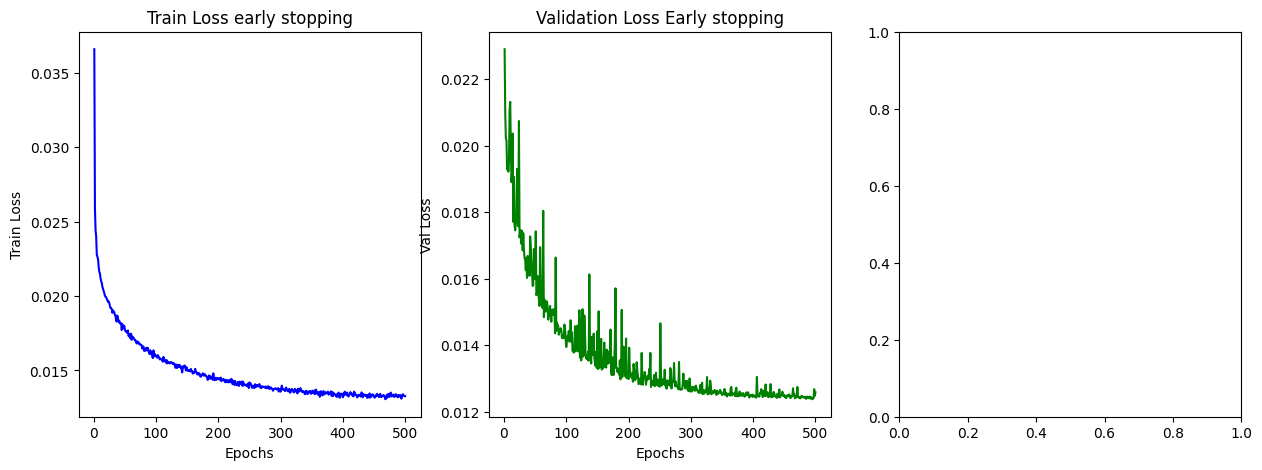

R2 score net dropout: 0.7874181711288628
MSE net dropout: 54215.953144512

R2 random forest 2: 0.8271114226764336
MSE random forest 2: 48893.05512538962


In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
epochs = range(1, 500 + 1)
#val_loss_smooth = pd.Series(val_losses_ref).rolling(10)

axes[0].plot(epochs, train_losses_early_stop, color='blue')
axes[0].set_title('Train Loss early stopping')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')

axes[1].plot(epochs, val_losses_early_stop, color='green')
axes[1].set_title('Validation Loss Early stopping')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Val Loss')

#axes[1].plot(epochs, val_loss_smooth, color='red')
#axes[1].set_title('Validation Loss')
#axes[1].set_xlabel('Epochs')
#axes[1].set_ylabel('Val Loss')

plt.show()

trained_model = CHNetworkDropout(number_of_features2, 1)
trained_model.load_state_dict(torch.load(os.path.join('./', 'snapshot_dropout')))
trained_model.eval()

r2_net, mse_net = get_metrics(trained_model, validation_loader)
print(f'R2 score net dropout: {r2_net}')
print(f'MSE net dropout: {mse_net}')
print()
print(f'R2 random forest 2: {r2_score(ytruev_rf, ypredv_rf)}')
print(f'MSE random forest 2: {mean_squared_error(ytruev_rf, ypredv_rf, squared=False)}')

In [80]:
#number of input features
number_of_features2 = X.values.shape[1]

#network
my_net_def2 = CHNetworkDropout(number_of_features2, 1)

#loss function
my_loss_fn2 = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_sgd = torch.optim.SGD

#scheduler
my_scheduler_fn2 = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params_sgd = {
    'lr': 0.01, 
    'momentum': 0.9
}

scheduler_params2 = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max2 = 500

early_stopping = EarlyStoppingCriterion(15, min_delta = 0.0001)

train_losses_early_stop, val_losses_early_stop, stop_epoch = training_early_stopping(my_net_def2, 
                                          my_optimizer_fn2, 
                                          optim_params2, 
                                          my_scheduler_fn2,
                                          scheduler_params2,
                                          my_loss_fn2, 
                                          train_loader, 
                                          validation_loader, 
                                          epochs_max2,
                                          early_stopping,
                                          "snapshot_dropout_and_early_stopping",
                                          apply_scheduler=True,
                                          snapshot_interval=500)

  0%|                                           | 1/500 [00:03<26:57,  3.24s/it]

Training loss:  0.03652814887383846
Validation loss:  0.02376722920957809


  0%|▏                                          | 2/500 [00:06<25:21,  3.06s/it]

Training loss:  0.025872508651377437
Validation loss:  0.021467251841042815


  1%|▎                                          | 3/500 [00:09<24:50,  3.00s/it]

Training loss:  0.02446435136365653
Validation loss:  0.02118332875500805


  1%|▎                                          | 4/500 [00:12<24:32,  2.97s/it]

Training loss:  0.023631821898292386
Validation loss:  0.020960719212729788


  1%|▍                                          | 5/500 [00:14<24:22,  2.95s/it]

Training loss:  0.02336404956270719
Validation loss:  0.019388824307595583


  1%|▌                                          | 6/500 [00:17<24:12,  2.94s/it]

Training loss:  0.02305571298115958
Validation loss:  0.01931636207317334


  1%|▌                                          | 7/500 [00:20<24:07,  2.94s/it]

Training loss:  0.022554575846068344
Validation loss:  0.01984637069352003


  2%|▋                                          | 8/500 [00:23<24:04,  2.94s/it]

Training loss:  0.022118649922162937
Validation loss:  0.018765866878350534


  2%|▊                                          | 9/500 [00:26<24:02,  2.94s/it]

Training loss:  0.022107758169564687
Validation loss:  0.0188909885413593


  2%|▊                                         | 10/500 [00:29<23:59,  2.94s/it]

Training loss:  0.021445691934661424
Validation loss:  0.018307506956176056


  2%|▉                                         | 11/500 [00:32<23:56,  2.94s/it]

Training loss:  0.021385167060476058
Validation loss:  0.01822454069817015


  2%|█                                         | 12/500 [00:35<23:52,  2.93s/it]

Training loss:  0.021306907001229163
Validation loss:  0.01819939509857558


  3%|█                                         | 13/500 [00:38<23:50,  2.94s/it]

Training loss:  0.021143824186885832
Validation loss:  0.018878834457996065


  3%|█▏                                        | 14/500 [00:41<23:44,  2.93s/it]

Training loss:  0.020881266490555297
Validation loss:  0.018115605793237816


  3%|█▎                                        | 15/500 [00:44<23:42,  2.93s/it]

Training loss:  0.020767712752827003
Validation loss:  0.019008662916376165


  3%|█▎                                        | 16/500 [00:47<23:40,  2.94s/it]

Training loss:  0.020670799741750047
Validation loss:  0.019739861264345217


  3%|█▍                                        | 17/500 [00:50<23:38,  2.94s/it]

Training loss:  0.020567842708565737
Validation loss:  0.01779234673839878


  4%|█▌                                        | 18/500 [00:53<23:34,  2.93s/it]

Training loss:  0.020513164396302533
Validation loss:  0.017577848117398858


  4%|█▌                                        | 19/500 [00:56<23:30,  2.93s/it]

Training loss:  0.020422549925812702
Validation loss:  0.01823337254406237


  4%|█▋                                        | 20/500 [00:58<23:26,  2.93s/it]

Training loss:  0.020222898728070846
Validation loss:  0.018145979929699407


  4%|█▊                                        | 21/500 [01:01<23:19,  2.92s/it]

Training loss:  0.020248781440306386
Validation loss:  0.017540088837742485


  4%|█▊                                        | 22/500 [01:04<23:15,  2.92s/it]

Training loss:  0.019897632717141886
Validation loss:  0.0180214087392879


  5%|█▉                                        | 23/500 [01:07<23:10,  2.92s/it]

Training loss:  0.019911901206550047
Validation loss:  0.017540561155188237


  5%|██                                        | 24/500 [01:10<23:09,  2.92s/it]

Training loss:  0.019606680735851468
Validation loss:  0.01768689316321692


  5%|██                                        | 25/500 [01:13<23:04,  2.92s/it]

Training loss:  0.019764099235519108
Validation loss:  0.01756801105667977


  5%|██▏                                       | 26/500 [01:16<23:09,  2.93s/it]

Training loss:  0.019610420020800424
Validation loss:  0.016828134038401648


  5%|██▎                                       | 27/500 [01:19<23:05,  2.93s/it]

Training loss:  0.01941995107317173
Validation loss:  0.01682431880652489


  6%|██▎                                       | 28/500 [01:22<23:00,  2.93s/it]

Training loss:  0.01967992812928426
Validation loss:  0.017113086049017283


  6%|██▍                                       | 29/500 [01:25<23:01,  2.93s/it]

Training loss:  0.019402014567798446
Validation loss:  0.019106719103270078


  6%|██▌                                       | 30/500 [01:28<23:08,  2.95s/it]

Training loss:  0.01933210434976552
Validation loss:  0.01695597792132218


  6%|██▌                                       | 31/500 [01:31<23:10,  2.97s/it]

Training loss:  0.01896110494306313
Validation loss:  0.01701715131801885


  6%|██▋                                       | 32/500 [01:34<23:13,  2.98s/it]

Training loss:  0.019303330133565822
Validation loss:  0.017647562695411335


  7%|██▊                                       | 33/500 [01:37<23:11,  2.98s/it]

Training loss:  0.01901873149578254
Validation loss:  0.016343203785953157


  7%|██▊                                       | 34/500 [01:40<23:12,  2.99s/it]

Training loss:  0.01885123548886876
Validation loss:  0.016534843571012432


  7%|██▉                                       | 35/500 [01:43<23:06,  2.98s/it]

Training loss:  0.018609275890261623
Validation loss:  0.01657626337008031


  7%|███                                       | 36/500 [01:46<23:01,  2.98s/it]

Training loss:  0.018710287070038165
Validation loss:  0.017335689617640662


  7%|███                                       | 37/500 [01:49<22:57,  2.98s/it]

Training loss:  0.018893384775678167
Validation loss:  0.017025688774044357


  8%|███▏                                      | 38/500 [01:52<22:53,  2.97s/it]

Training loss:  0.01867300699829887
Validation loss:  0.015950465506909997


  8%|███▎                                      | 39/500 [01:55<22:50,  2.97s/it]

Training loss:  0.018606414333230487
Validation loss:  0.017158497277799147


  8%|███▎                                      | 40/500 [01:58<22:56,  2.99s/it]

Training loss:  0.018551678223830154
Validation loss:  0.017888240476214835


  8%|███▍                                      | 41/500 [02:01<22:50,  2.99s/it]

Training loss:  0.018477028388173125
Validation loss:  0.015865397219378262


  8%|███▌                                      | 42/500 [02:04<22:50,  2.99s/it]

Training loss:  0.018270810629943922
Validation loss:  0.016298707190885053


  9%|███▌                                      | 43/500 [02:07<22:44,  2.99s/it]

Training loss:  0.01841182372155845
Validation loss:  0.015812147065973142


  9%|███▋                                      | 44/500 [02:10<22:43,  2.99s/it]

Training loss:  0.018049187516137974
Validation loss:  0.01637450746778207


  9%|███▊                                      | 45/500 [02:13<22:39,  2.99s/it]

Training loss:  0.018139559340505863
Validation loss:  0.015801930423354323


  9%|███▊                                      | 46/500 [02:16<22:35,  2.99s/it]

Training loss:  0.018219049588904444
Validation loss:  0.01577871545345838


  9%|███▉                                      | 47/500 [02:19<22:32,  2.99s/it]

Training loss:  0.018120712263307127
Validation loss:  0.01655606167139126


 10%|████                                      | 48/500 [02:21<22:27,  2.98s/it]

Training loss:  0.01787877791241389
Validation loss:  0.015905609228468377


 10%|████                                      | 49/500 [02:24<22:25,  2.98s/it]

Training loss:  0.01799417169718523
Validation loss:  0.01811648953742


 10%|████▏                                     | 50/500 [02:27<22:20,  2.98s/it]

Training loss:  0.017845360411078426
Validation loss:  0.016290374034256254


 10%|████▎                                     | 51/500 [02:30<22:19,  2.98s/it]

Training loss:  0.017837831574322734
Validation loss:  0.017310405265971572


 10%|████▎                                     | 52/500 [02:33<22:16,  2.98s/it]

Training loss:  0.017969389477157233
Validation loss:  0.015987241853532168


 11%|████▍                                     | 53/500 [02:36<22:14,  2.99s/it]

Training loss:  0.018036824753066873
Validation loss:  0.015247263840715453


 11%|████▌                                     | 54/500 [02:39<22:13,  2.99s/it]

Training loss:  0.01785079905772291
Validation loss:  0.015908220965743


 11%|████▌                                     | 55/500 [02:42<22:08,  2.98s/it]

Training loss:  0.01781257827624887
Validation loss:  0.01540178606034828


 11%|████▋                                     | 56/500 [02:45<22:02,  2.98s/it]

Training loss:  0.017959252208625685
Validation loss:  0.015672832036934505


 11%|████▊                                     | 57/500 [02:48<21:58,  2.98s/it]

Training loss:  0.01764523321000781
Validation loss:  0.016292299046041243


 12%|████▊                                     | 58/500 [02:51<21:54,  2.97s/it]

Training loss:  0.017462021490534923
Validation loss:  0.01510625248854828


 12%|████▉                                     | 59/500 [02:54<21:50,  2.97s/it]

Training loss:  0.01741377560023832
Validation loss:  0.015608361392589726


 12%|█████                                     | 60/500 [02:57<21:48,  2.97s/it]

Training loss:  0.01747782316371654
Validation loss:  0.015129028806510849


 12%|█████                                     | 61/500 [03:00<21:47,  2.98s/it]

Training loss:  0.017660135770942394
Validation loss:  0.01512330341204809


 12%|█████▏                                    | 62/500 [03:03<21:43,  2.98s/it]

Training loss:  0.017385381875174726
Validation loss:  0.015163574693524659


 13%|█████▎                                    | 63/500 [03:06<21:39,  2.97s/it]

Training loss:  0.017346852204879692
Validation loss:  0.014997975387142835


 13%|█████▍                                    | 64/500 [03:09<21:36,  2.97s/it]

Training loss:  0.01733261602053537
Validation loss:  0.016578695608918503


 13%|█████▍                                    | 65/500 [03:12<21:37,  2.98s/it]

Training loss:  0.017157723666023385
Validation loss:  0.016060550601217624


 13%|█████▌                                    | 66/500 [03:15<21:32,  2.98s/it]

Training loss:  0.01725223815731255
Validation loss:  0.015617476946118692


 13%|█████▋                                    | 67/500 [03:18<21:29,  2.98s/it]

Training loss:  0.017215250626374818
Validation loss:  0.015082734066377446


 14%|█████▋                                    | 68/500 [03:21<21:25,  2.98s/it]

Training loss:  0.017095145114534107
Validation loss:  0.014778019639047846


 14%|█████▊                                    | 69/500 [03:24<21:21,  2.97s/it]

Training loss:  0.017295934705502794
Validation loss:  0.015335854838398394


 14%|█████▉                                    | 70/500 [03:27<21:18,  2.97s/it]

Training loss:  0.017136013133559613
Validation loss:  0.015411695345532741


 14%|█████▉                                    | 71/500 [03:30<21:16,  2.98s/it]

Training loss:  0.016991696310950398
Validation loss:  0.014781734603357225


 14%|██████                                    | 72/500 [03:33<21:13,  2.98s/it]

Training loss:  0.017279911216647154
Validation loss:  0.014970769703012487


 15%|██████▏                                   | 73/500 [03:36<21:10,  2.97s/it]

Training loss:  0.017002198511566185
Validation loss:  0.0169731105873641


 15%|██████▏                                   | 74/500 [03:39<21:07,  2.97s/it]

Training loss:  0.017022683612117093
Validation loss:  0.014621952532634715


 15%|██████▎                                   | 75/500 [03:42<21:02,  2.97s/it]

Training loss:  0.01695673114096844
Validation loss:  0.014740932987635165


 15%|██████▍                                   | 76/500 [03:45<20:59,  2.97s/it]

Training loss:  0.016886598467415817
Validation loss:  0.015323571753868026


 15%|██████▍                                   | 77/500 [03:48<20:55,  2.97s/it]

Training loss:  0.016743324000280113
Validation loss:  0.016731652404709276


 16%|██████▌                                   | 78/500 [03:51<20:53,  2.97s/it]

Training loss:  0.016772084808291867
Validation loss:  0.014861726501852657


 16%|██████▋                                   | 79/500 [03:54<20:49,  2.97s/it]

Training loss:  0.016750308284505928
Validation loss:  0.015121509261077566


 16%|██████▋                                   | 80/500 [03:57<21:03,  3.01s/it]

Training loss:  0.016855658295406962
Validation loss:  0.014500732022505493


 16%|██████▊                                   | 81/500 [04:00<20:56,  3.00s/it]

Training loss:  0.016806582508977617
Validation loss:  0.014887707787585873


 16%|██████▉                                   | 82/500 [04:03<20:52,  3.00s/it]

Training loss:  0.016667994866308038
Validation loss:  0.014724717922148979


 17%|██████▉                                   | 83/500 [04:06<20:46,  2.99s/it]

Training loss:  0.016554616006448128
Validation loss:  0.014458602807952227


 17%|███████                                   | 84/500 [04:09<20:47,  3.00s/it]

Training loss:  0.016582689888873594
Validation loss:  0.016575209804422866


 17%|███████▏                                  | 85/500 [04:12<20:41,  2.99s/it]

Training loss:  0.01670319672380208
Validation loss:  0.014662136177856139


 17%|███████▏                                  | 86/500 [04:15<20:37,  2.99s/it]

Training loss:  0.016431181729431348
Validation loss:  0.014468528916899419


 17%|███████▎                                  | 87/500 [04:18<20:32,  2.98s/it]

Training loss:  0.01632448715965822
Validation loss:  0.014352675864089264


 18%|███████▍                                  | 88/500 [04:21<20:30,  2.99s/it]

Training loss:  0.016382187846256068
Validation loss:  0.014566379316478903


 18%|███████▍                                  | 89/500 [04:24<20:25,  2.98s/it]

Training loss:  0.01644107944029308
Validation loss:  0.014264076782786187


 18%|███████▌                                  | 90/500 [04:27<20:21,  2.98s/it]

Training loss:  0.016482978730399334
Validation loss:  0.014891842792865864


 18%|███████▋                                  | 91/500 [04:30<20:17,  2.98s/it]

Training loss:  0.016348378464130463
Validation loss:  0.015147848256619832


 18%|███████▋                                  | 92/500 [04:33<20:13,  2.97s/it]

Training loss:  0.016397799051941178
Validation loss:  0.015882349850873705


 19%|███████▊                                  | 93/500 [04:36<20:08,  2.97s/it]

Training loss:  0.016249119146226777
Validation loss:  0.014267101021515518


 19%|███████▉                                  | 94/500 [04:39<20:06,  2.97s/it]

Training loss:  0.016464921106224474
Validation loss:  0.015148348239941978


 19%|███████▉                                  | 95/500 [04:42<20:02,  2.97s/it]

Training loss:  0.016315590258411044
Validation loss:  0.014382179191959582


 19%|████████                                  | 96/500 [04:45<20:02,  2.98s/it]

Training loss:  0.016222862368880642
Validation loss:  0.01417938080344493


 19%|████████▏                                 | 97/500 [04:47<19:59,  2.98s/it]

Training loss:  0.016369223475117392
Validation loss:  0.014633759747303287


 20%|████████▏                                 | 98/500 [04:50<19:58,  2.98s/it]

Training loss:  0.01628823740386772
Validation loss:  0.01418710984849239


 20%|████████▎                                 | 99/500 [04:53<19:54,  2.98s/it]

Training loss:  0.016368087722475774
Validation loss:  0.014988095761696976


 20%|████████▏                                | 100/500 [04:56<19:53,  2.98s/it]

Training loss:  0.016156385914624073
Validation loss:  0.014409664321327063


 20%|████████▎                                | 101/500 [04:59<19:51,  2.99s/it]

Training loss:  0.01611410903336382
Validation loss:  0.013971673510568976


 20%|████████▎                                | 102/500 [05:03<20:19,  3.06s/it]

Training loss:  0.016094150064529127
Validation loss:  0.015847821012459087


 21%|████████▍                                | 103/500 [05:06<21:07,  3.19s/it]

Training loss:  0.01616147127723275
Validation loss:  0.013902156396924874


 21%|████████▌                                | 104/500 [05:09<21:18,  3.23s/it]

Training loss:  0.015907531480111415
Validation loss:  0.014116259288770255


 21%|████████▌                                | 105/500 [05:13<21:26,  3.26s/it]

Training loss:  0.016089153417162556
Validation loss:  0.01401882758264154


 21%|████████▋                                | 106/500 [05:16<20:51,  3.18s/it]

Training loss:  0.01592252094076046
Validation loss:  0.014197662758517035


 21%|████████▊                                | 107/500 [05:19<20:25,  3.12s/it]

Training loss:  0.015964336496045006
Validation loss:  0.014220389401612108


 22%|████████▊                                | 108/500 [05:22<20:02,  3.07s/it]

Training loss:  0.016015434923628898
Validation loss:  0.013941674377337546


 22%|████████▉                                | 109/500 [05:25<19:46,  3.04s/it]

Training loss:  0.01590495772205646
Validation loss:  0.013777748609657196


 22%|█████████                                | 110/500 [05:28<19:35,  3.01s/it]

Training loss:  0.01583934862886438
Validation loss:  0.01597090277774859


 22%|█████████                                | 111/500 [05:31<19:27,  3.00s/it]

Training loss:  0.015961360479569697
Validation loss:  0.014621615787576325


 22%|█████████▏                               | 112/500 [05:34<19:18,  2.99s/it]

Training loss:  0.01564053537783216
Validation loss:  0.014097578327926954


 23%|█████████▎                               | 113/500 [05:37<19:12,  2.98s/it]

Training loss:  0.01604448249929487
Validation loss:  0.01385791993514103


 23%|█████████▎                               | 114/500 [05:39<19:07,  2.97s/it]

Training loss:  0.01597266907270384
Validation loss:  0.01446582633470357


 23%|█████████▍                               | 115/500 [05:42<19:02,  2.97s/it]

Training loss:  0.015921990506940466
Validation loss:  0.01394970924793363


 23%|█████████▌                               | 116/500 [05:45<18:59,  2.97s/it]

Training loss:  0.015898608269252133
Validation loss:  0.014530148680917438


 23%|█████████▌                               | 117/500 [05:48<18:58,  2.97s/it]

Training loss:  0.015587908729978018
Validation loss:  0.01390825929679776


 24%|█████████▋                               | 118/500 [05:51<18:54,  2.97s/it]

Training loss:  0.015652259409756463
Validation loss:  0.01401840674225241


 24%|█████████▊                               | 119/500 [05:54<18:51,  2.97s/it]

Training loss:  0.015582646272847965
Validation loss:  0.014710783415330102


 24%|█████████▊                               | 120/500 [05:57<18:57,  2.99s/it]

Training loss:  0.01565143623288051
Validation loss:  0.013753764882939569


 24%|█████████▉                               | 121/500 [06:00<18:56,  3.00s/it]

Training loss:  0.015581526920105159
Validation loss:  0.013817904156316951


 24%|██████████                               | 122/500 [06:03<18:55,  3.00s/it]

Training loss:  0.015653869582904528
Validation loss:  0.014164521750622296


 25%|██████████                               | 123/500 [06:06<18:49,  2.99s/it]

Training loss:  0.015563304341810207
Validation loss:  0.013873974323000903


 25%|██████████▏                              | 124/500 [06:09<18:44,  2.99s/it]

Training loss:  0.01563267894259647
Validation loss:  0.013649487799001546


 25%|██████████▎                              | 125/500 [06:12<18:38,  2.98s/it]

Training loss:  0.015555197502605705
Validation loss:  0.013678883068471379


 25%|██████████▎                              | 126/500 [06:15<18:34,  2.98s/it]

Training loss:  0.015516737400553118
Validation loss:  0.013830778080082694


 25%|██████████▍                              | 127/500 [06:18<18:31,  2.98s/it]

Training loss:  0.015530020121857925
Validation loss:  0.013914386080298173


 26%|██████████▍                              | 128/500 [06:21<18:28,  2.98s/it]

Training loss:  0.015583753422909167
Validation loss:  0.013580001580385019


 26%|██████████▌                              | 129/500 [06:24<18:24,  2.98s/it]

Training loss:  0.01538096902870941
Validation loss:  0.013748560693362815


 26%|██████████▋                              | 130/500 [06:27<18:22,  2.98s/it]

Training loss:  0.015623026794380036
Validation loss:  0.014627263092839602


 26%|██████████▋                              | 131/500 [06:30<18:19,  2.98s/it]

Training loss:  0.015438884714356673
Validation loss:  0.013924832607703403


 26%|██████████▊                              | 132/500 [06:33<18:15,  2.98s/it]

Training loss:  0.015500912879642793
Validation loss:  0.013575513768229682


 27%|██████████▉                              | 133/500 [06:36<18:10,  2.97s/it]

Training loss:  0.015296651432150324
Validation loss:  0.013710704963862128


 27%|██████████▉                              | 134/500 [06:39<18:07,  2.97s/it]

Training loss:  0.015550968295115621
Validation loss:  0.013726498261134064


 27%|███████████                              | 135/500 [06:42<18:02,  2.97s/it]

Training loss:  0.015660081236433754
Validation loss:  0.01377211109926932


 27%|███████████▏                             | 136/500 [06:45<17:59,  2.96s/it]

Training loss:  0.015352144867705083
Validation loss:  0.013877045799870156


 27%|███████████▏                             | 137/500 [06:48<17:54,  2.96s/it]

Training loss:  0.015267013397721416
Validation loss:  0.013343142695293278


 28%|███████████▎                             | 138/500 [06:51<17:52,  2.96s/it]

Training loss:  0.015365565795174712
Validation loss:  0.013675410610267917


 28%|███████████▍                             | 139/500 [06:54<17:49,  2.96s/it]

Training loss:  0.015186305002703364
Validation loss:  0.014446638181781627


 28%|███████████▍                             | 140/500 [06:57<17:48,  2.97s/it]

Training loss:  0.015242030188457316
Validation loss:  0.014033660051800598


 28%|███████████▌                             | 141/500 [07:00<17:46,  2.97s/it]

Training loss:  0.015290377364093909
Validation loss:  0.013689421194249788


 28%|███████████▋                             | 142/500 [07:03<17:46,  2.98s/it]

Training loss:  0.015240780448047815
Validation loss:  0.013457482102099214


 29%|███████████▋                             | 143/500 [07:06<17:41,  2.97s/it]

Training loss:  0.015331215128669489
Validation loss:  0.013482398658295366


 29%|███████████▊                             | 144/500 [07:09<17:37,  2.97s/it]

Training loss:  0.015543600879168484
Validation loss:  0.0139938193391369


 29%|███████████▉                             | 145/500 [07:12<17:34,  2.97s/it]

Training loss:  0.01504210451822347
Validation loss:  0.013552810275295646


 29%|███████████▉                             | 146/500 [07:15<17:30,  2.97s/it]

Training loss:  0.015083660258569697
Validation loss:  0.013378283600502772


 29%|████████████                             | 147/500 [07:18<17:28,  2.97s/it]

Training loss:  0.015383472433564352
Validation loss:  0.014131202561333135


 30%|████████████▏                            | 148/500 [07:21<17:24,  2.97s/it]

Training loss:  0.015382749984137096
Validation loss:  0.013727192593090907


 30%|████████████▏                            | 149/500 [07:24<17:20,  2.97s/it]

Training loss:  0.015002829848514997
Validation loss:  0.013425193135446744


 30%|████████████▎                            | 150/500 [07:27<17:17,  2.96s/it]

Training loss:  0.015025796126614378
Validation loss:  0.013378669316940362


 30%|████████████▍                            | 151/500 [07:30<17:15,  2.97s/it]

Training loss:  0.014925371081316674
Validation loss:  0.013769276324727537


 30%|████████████▍                            | 152/500 [07:32<17:11,  2.97s/it]

Training loss:  0.015325953434441996
Validation loss:  0.01353560179140211


 31%|████████████▌                            | 153/500 [07:35<17:08,  2.96s/it]

Training loss:  0.01519207326611113
Validation loss:  0.013439394230854421


 31%|████████████▋                            | 154/500 [07:38<17:04,  2.96s/it]

Training loss:  0.015245679190504666
Validation loss:  0.013278446912709544


 31%|████████████▋                            | 155/500 [07:41<17:02,  2.96s/it]

Training loss:  0.015049919826895864
Validation loss:  0.013582688006457509


 31%|████████████▊                            | 156/500 [07:44<16:59,  2.96s/it]

Training loss:  0.014973434144169878
Validation loss:  0.013527061548403788


 31%|████████████▊                            | 157/500 [07:47<16:56,  2.96s/it]

Training loss:  0.014998306393968212
Validation loss:  0.014371176145854906


 32%|████████████▉                            | 158/500 [07:50<16:53,  2.96s/it]

Training loss:  0.01520844892597686
Validation loss:  0.01436713980131107


 32%|█████████████                            | 159/500 [07:53<16:49,  2.96s/it]

Training loss:  0.014960944595414869
Validation loss:  0.013213743845424555


 32%|█████████████                            | 160/500 [07:56<16:47,  2.96s/it]

Training loss:  0.01500270764801583
Validation loss:  0.013167579181676195


 32%|█████████████▏                           | 161/500 [07:59<17:08,  3.03s/it]

Training loss:  0.014909999719013904
Validation loss:  0.013533107389779881


 32%|█████████████▎                           | 162/500 [08:02<17:07,  3.04s/it]

Training loss:  0.014915568550569441
Validation loss:  0.013104101896282014
Training loss:  0.014851631995428863


 33%|█████████████▎                           | 163/500 [08:06<18:28,  3.29s/it]

Validation loss:  0.014097806013313166


 33%|█████████████▍                           | 164/500 [08:10<19:01,  3.40s/it]

Training loss:  0.014948607829175849
Validation loss:  0.01317638424504948


 33%|█████████████▌                           | 165/500 [08:13<18:30,  3.31s/it]

Training loss:  0.014896666427845671
Validation loss:  0.013103924733646567


 33%|█████████████▌                           | 166/500 [08:17<18:44,  3.37s/it]

Training loss:  0.014951442095899175
Validation loss:  0.013281527610871414


 33%|█████████████▋                           | 167/500 [08:20<18:38,  3.36s/it]

Training loss:  0.014885512473857667
Validation loss:  0.014066994302134657


 34%|█████████████▊                           | 168/500 [08:23<18:21,  3.32s/it]

Training loss:  0.014842367377402852
Validation loss:  0.013161812017595819


 34%|█████████████▊                           | 169/500 [08:26<17:50,  3.23s/it]

Training loss:  0.014871788386854998
Validation loss:  0.013590097792102863


 34%|█████████████▉                           | 170/500 [08:29<17:25,  3.17s/it]

Training loss:  0.014953919641264544
Validation loss:  0.015633634277599437


 34%|██████████████                           | 171/500 [08:32<17:26,  3.18s/it]

Training loss:  0.014834202876899981
Validation loss:  0.013134588759248604
Training loss:  0.014645293518896861


 34%|██████████████                           | 172/500 [08:36<17:45,  3.25s/it]

Validation loss:  0.013256055041108392


 35%|██████████████▏                          | 173/500 [08:39<17:40,  3.24s/it]

Training loss:  0.014639953295955889
Validation loss:  0.014658093945095275


 35%|██████████████▎                          | 174/500 [08:42<17:34,  3.23s/it]

Training loss:  0.01477568469183726
Validation loss:  0.013494922549917479


 35%|██████████████▎                          | 175/500 [08:45<17:23,  3.21s/it]

Training loss:  0.014913733187958647
Validation loss:  0.013136236453748631
Training loss:  0.014828630783710432


 35%|██████████████▍                          | 176/500 [08:48<17:07,  3.17s/it]

Validation loss:  0.013993466214992329


 35%|██████████████▌                          | 177/500 [08:52<16:55,  3.14s/it]

Training loss:  0.014512506566753267
Validation loss:  0.01333504054963173


 36%|██████████████▌                          | 178/500 [08:55<17:04,  3.18s/it]

Training loss:  0.014605836851815057
Validation loss:  0.013028046651343644


 36%|██████████████▋                          | 179/500 [08:58<16:49,  3.15s/it]

Training loss:  0.014667761785031343
Validation loss:  0.013189863784552468


 36%|██████████████▊                          | 180/500 [09:01<17:05,  3.20s/it]

Training loss:  0.01442448028029455
Validation loss:  0.014050800845930312
Training loss:  0.014775189433489455


 36%|██████████████▊                          | 181/500 [09:05<17:09,  3.23s/it]

Validation loss:  0.014061385379952294
Training loss:  0.01463363908629251


 36%|██████████████▉                          | 182/500 [09:09<18:34,  3.50s/it]

Validation loss:  0.012993331318081641
Training loss:  0.014602767174012871


 37%|███████████████                          | 183/500 [09:13<19:24,  3.67s/it]

Validation loss:  0.013206582809218841
Training loss:  0.014682270282482483


 37%|███████████████                          | 184/500 [09:16<19:18,  3.67s/it]

Validation loss:  0.01313349016734235


 37%|███████████████▏                         | 185/500 [09:20<19:21,  3.69s/it]

Training loss:  0.014743346515672023
Validation loss:  0.013219483811288369


 37%|███████████████▎                         | 186/500 [09:23<18:12,  3.48s/it]

Training loss:  0.014618163933026113
Validation loss:  0.012971650420332352


 37%|███████████████▎                         | 187/500 [09:26<17:18,  3.32s/it]

Training loss:  0.014539365347152009
Validation loss:  0.013458233573993611


 38%|███████████████▍                         | 188/500 [09:29<17:08,  3.30s/it]

Training loss:  0.014496619397983862
Validation loss:  0.012900933774703785


 38%|███████████████▍                         | 189/500 [09:33<16:56,  3.27s/it]

Training loss:  0.01450181545928297
Validation loss:  0.012957016306893316


 38%|███████████████▌                         | 190/500 [09:36<16:41,  3.23s/it]

Training loss:  0.014644670147805669
Validation loss:  0.013040047150920645


 38%|███████████████▋                         | 191/500 [09:39<16:34,  3.22s/it]

Training loss:  0.014597844310401587
Validation loss:  0.01348978565314329


 38%|███████████████▋                         | 192/500 [09:42<16:32,  3.22s/it]

Training loss:  0.01453088460850005
Validation loss:  0.013161147910653904


 39%|███████████████▊                         | 193/500 [09:45<16:40,  3.26s/it]

Training loss:  0.014604914496728972
Validation loss:  0.013163327689626346


 39%|███████████████▉                         | 194/500 [09:49<16:46,  3.29s/it]

Training loss:  0.01438161943922876
Validation loss:  0.013488818957298483


 39%|███████████████▉                         | 195/500 [09:52<16:40,  3.28s/it]

Training loss:  0.014655695779277143
Validation loss:  0.012967346981567502


 39%|████████████████                         | 196/500 [09:55<16:12,  3.20s/it]

Training loss:  0.014677931507497993
Validation loss:  0.013192995878080378


 39%|████████████████▏                        | 197/500 [09:58<15:49,  3.14s/it]

Training loss:  0.014526975258810904
Validation loss:  0.013025512144393228


 40%|████████████████▏                        | 198/500 [10:01<15:58,  3.18s/it]

Training loss:  0.014550752788671845
Validation loss:  0.012974621746049547


 40%|████████████████▎                        | 199/500 [10:05<16:25,  3.27s/it]

Training loss:  0.014651026827382452
Validation loss:  0.01323691519305046


 40%|████████████████▍                        | 200/500 [10:08<16:20,  3.27s/it]

Training loss:  0.014557035239508619
Validation loss:  0.013368748969802145
Training loss:  0.01455121786775723


 40%|████████████████▍                        | 201/500 [10:11<16:21,  3.28s/it]

Validation loss:  0.01280359700701875
Training loss:  0.014500857859928124


 40%|████████████████▌                        | 202/500 [10:15<16:27,  3.31s/it]

Validation loss:  0.013919841720474797


 41%|████████████████▋                        | 203/500 [10:18<16:10,  3.27s/it]

Training loss:  0.01453673249121607
Validation loss:  0.01367172274474742


 41%|████████████████▋                        | 204/500 [10:21<15:45,  3.19s/it]

Training loss:  0.014472872477708499
Validation loss:  0.013089251067977032


 41%|████████████████▊                        | 205/500 [10:24<15:25,  3.14s/it]

Training loss:  0.014403883635193767
Validation loss:  0.012933538441222497


 41%|████████████████▉                        | 206/500 [10:27<15:09,  3.09s/it]

Training loss:  0.01452222501806939
Validation loss:  0.012869748889464613


 41%|████████████████▉                        | 207/500 [10:30<14:57,  3.06s/it]

Training loss:  0.014320730009397934
Validation loss:  0.013000013795881152


 42%|█████████████████                        | 208/500 [10:33<14:50,  3.05s/it]

Training loss:  0.01434272614060084
Validation loss:  0.013007788173454642


 42%|█████████████████▏                       | 209/500 [10:36<14:42,  3.03s/it]

Training loss:  0.014483796536122459
Validation loss:  0.012856917565712474


 42%|█████████████████▏                       | 210/500 [10:39<14:37,  3.03s/it]

Training loss:  0.014579362102881459
Validation loss:  0.013246716346887497


 42%|█████████████████▎                       | 211/500 [10:42<14:33,  3.02s/it]

Training loss:  0.014292605391947153
Validation loss:  0.012872697566156256


 42%|█████████████████▍                       | 212/500 [10:45<14:28,  3.02s/it]

Training loss:  0.014379623938758884
Validation loss:  0.013548334636285806


 43%|█████████████████▍                       | 213/500 [10:48<14:22,  3.00s/it]

Training loss:  0.014270668119027713
Validation loss:  0.013253018759638711


 43%|█████████████████▌                       | 214/500 [10:51<14:18,  3.00s/it]

Training loss:  0.014477702905298626
Validation loss:  0.01301532891047359


 43%|█████████████████▋                       | 215/500 [10:54<14:14,  3.00s/it]

Training loss:  0.014366382359806749
Validation loss:  0.013546701648588344


 43%|█████████████████▋                       | 216/500 [10:57<14:09,  2.99s/it]

Training loss:  0.014412539460484753
Validation loss:  0.012836650638469362


 43%|█████████████████▊                       | 217/500 [11:00<14:07,  2.99s/it]

Training loss:  0.014227145249465134
Validation loss:  0.012868503843086408


 44%|█████████████████▉                       | 218/500 [11:03<14:04,  2.99s/it]

Training loss:  0.014308110907306921
Validation loss:  0.012927754549309611


 44%|█████████████████▉                       | 219/500 [11:06<14:02,  3.00s/it]

Training loss:  0.014367097478452167
Validation loss:  0.013105183231240627


 44%|██████████████████                       | 220/500 [11:09<14:00,  3.00s/it]

Training loss:  0.014422340440740297
Validation loss:  0.013466967337728826


 44%|██████████████████                       | 221/500 [11:12<13:57,  3.00s/it]

Training loss:  0.014240084477400546
Validation loss:  0.013272657165555642


 44%|██████████████████▏                      | 222/500 [11:15<13:55,  3.00s/it]

Training loss:  0.014323102219573615
Validation loss:  0.012938896188604377


 45%|██████████████████▎                      | 223/500 [11:18<13:51,  3.00s/it]

Training loss:  0.014383608486856242
Validation loss:  0.012868126812331026


 45%|██████████████████▎                      | 224/500 [11:21<13:47,  3.00s/it]

Training loss:  0.014228266016484926
Validation loss:  0.013244966223392269


 45%|██████████████████▍                      | 225/500 [11:24<13:43,  2.99s/it]

Training loss:  0.014060191590082306
Validation loss:  0.013132495075152475


 45%|██████████████████▌                      | 226/500 [11:27<13:42,  3.00s/it]

Training loss:  0.01409940204890876
Validation loss:  0.012827903616877648


 45%|██████████████████▌                      | 227/500 [11:30<13:40,  3.01s/it]

Training loss:  0.014213312836815036
Validation loss:  0.012815225870416464


 46%|██████████████████▋                      | 228/500 [11:33<13:37,  3.01s/it]

Training loss:  0.014139707570402322
Validation loss:  0.013535268130100656


 46%|██████████████████▊                      | 229/500 [11:36<13:33,  3.00s/it]

Training loss:  0.014196847881510277
Validation loss:  0.012695293427872683


 46%|██████████████████▊                      | 230/500 [11:39<13:29,  3.00s/it]

Training loss:  0.014377048700136624
Validation loss:  0.012933269323473356


 46%|██████████████████▉                      | 231/500 [11:42<13:35,  3.03s/it]

Training loss:  0.014182196356244866
Validation loss:  0.012800911550865761


 46%|███████████████████                      | 232/500 [11:45<13:29,  3.02s/it]

Training loss:  0.014157493733595435
Validation loss:  0.01285477365215225


 47%|███████████████████                      | 233/500 [11:48<13:23,  3.01s/it]

Training loss:  0.01417682490780733
Validation loss:  0.0131759826001979


 47%|███████████████████▏                     | 234/500 [11:51<13:19,  3.01s/it]

Training loss:  0.014288245363209088
Validation loss:  0.01277770389415036


 47%|███████████████████▎                     | 235/500 [11:54<13:15,  3.00s/it]

Training loss:  0.014263456214903037
Validation loss:  0.012920905783964329


 47%|███████████████████▎                     | 236/500 [11:57<13:11,  3.00s/it]

Training loss:  0.014272773631099528
Validation loss:  0.012856418456754332


 47%|███████████████████▍                     | 237/500 [12:00<13:10,  3.00s/it]

Training loss:  0.014224082607459136
Validation loss:  0.012699121620821818


 48%|███████████████████▌                     | 238/500 [12:03<13:07,  3.01s/it]

Training loss:  0.014142341405530215
Validation loss:  0.012836172980907905


 48%|███████████████████▌                     | 239/500 [12:06<13:03,  3.00s/it]

Training loss:  0.0142970915529897
Validation loss:  0.01327255065303072


 48%|███████████████████▋                     | 240/500 [12:09<13:01,  3.01s/it]

Training loss:  0.01421005473085213
Validation loss:  0.012914946130896587


 48%|███████████████████▊                     | 241/500 [12:12<12:56,  3.00s/it]

Training loss:  0.014138328132296806
Validation loss:  0.012743032159675472


 48%|███████████████████▊                     | 242/500 [12:15<12:52,  2.99s/it]

Training loss:  0.014046723251376377
Validation loss:  0.012844581291870945


 49%|███████████████████▉                     | 243/500 [12:18<12:49,  2.99s/it]

Training loss:  0.014302950325112217
Validation loss:  0.012862636682241675


 49%|████████████████████                     | 244/500 [12:21<12:47,  3.00s/it]

Training loss:  0.014050348067357414
Validation loss:  0.012850914289375423


 49%|████████████████████                     | 245/500 [12:24<12:44,  3.00s/it]

Training loss:  0.014129875212771452
Validation loss:  0.012739511239222479


 49%|████████████████████▏                    | 246/500 [12:27<12:41,  3.00s/it]

Training loss:  0.013957192777707145
Validation loss:  0.012810541631637917


 49%|████████████████████▎                    | 247/500 [12:30<12:39,  3.00s/it]

Training loss:  0.014082559488164371
Validation loss:  0.012856305688779497


 50%|████████████████████▎                    | 248/500 [12:33<12:37,  3.00s/it]

Training loss:  0.014143129303425839
Validation loss:  0.01263644681821773


 50%|████████████████████▍                    | 249/500 [12:36<12:34,  3.01s/it]

Training loss:  0.014105928267289125
Validation loss:  0.012626475682022457


 50%|████████████████████▌                    | 250/500 [12:39<12:30,  3.00s/it]

Training loss:  0.014006760188672127
Validation loss:  0.012723665829855837


 50%|████████████████████▌                    | 251/500 [12:42<12:28,  3.01s/it]

Training loss:  0.013994896323775995
Validation loss:  0.012707608917831991


 50%|████████████████████▋                    | 252/500 [12:45<12:24,  3.00s/it]

Training loss:  0.014149666386902076
Validation loss:  0.012847397123691286


 51%|████████████████████▋                    | 253/500 [12:48<12:20,  3.00s/it]

Training loss:  0.01393643540941255
Validation loss:  0.012574994513892884


 51%|████████████████████▊                    | 254/500 [12:51<12:17,  3.00s/it]

Training loss:  0.014025256808008096
Validation loss:  0.012722166429989263


 51%|████████████████████▉                    | 255/500 [12:54<12:14,  3.00s/it]

Training loss:  0.01409863375264658
Validation loss:  0.013129227653809307


 51%|████████████████████▉                    | 256/500 [12:57<12:15,  3.01s/it]

Training loss:  0.014031159854920098
Validation loss:  0.012788499956810646


 51%|█████████████████████                    | 257/500 [13:00<12:10,  3.00s/it]

Training loss:  0.013909876752600667
Validation loss:  0.01303594164618255


 52%|█████████████████████▏                   | 258/500 [13:03<12:07,  3.00s/it]

Training loss:  0.014031116913581032
Validation loss:  0.012846661133036145


 52%|█████████████████████▏                   | 259/500 [13:06<12:02,  3.00s/it]

Training loss:  0.013979603821888918
Validation loss:  0.01263874937288559


 52%|█████████████████████▎                   | 260/500 [13:09<11:58,  2.99s/it]

Training loss:  0.013986642400516584
Validation loss:  0.013022756486303721
Training loss:  0.013777533758620144


 52%|█████████████████████▍                   | 261/500 [13:12<11:58,  3.01s/it]

Validation loss:  0.012893055254881281


 52%|█████████████████████▍                   | 262/500 [13:15<11:56,  3.01s/it]

Training loss:  0.014000893390032717
Validation loss:  0.012790894660451189


 53%|█████████████████████▌                   | 263/500 [13:18<11:52,  3.01s/it]

Training loss:  0.014053863011585274
Validation loss:  0.01278569652646972


 53%|█████████████████████▋                   | 264/500 [13:21<11:49,  3.01s/it]

Training loss:  0.013918828159150647
Validation loss:  0.012702480632793799


 53%|█████████████████████▋                   | 265/500 [13:24<11:44,  3.00s/it]

Training loss:  0.013864590900181216
Validation loss:  0.012919726083554775


 53%|█████████████████████▊                   | 266/500 [13:27<11:40,  2.99s/it]

Training loss:  0.014047501578904985
Validation loss:  0.012815685271257494


 53%|█████████████████████▉                   | 267/500 [13:30<11:36,  2.99s/it]

Training loss:  0.013836244429086724
Validation loss:  0.012746269292549866


 54%|█████████████████████▉                   | 268/500 [13:33<11:34,  2.99s/it]

Training loss:  0.013932514867060632
Validation loss:  0.012877503139178703


 54%|██████████████████████                   | 269/500 [13:36<11:33,  3.00s/it]

Training loss:  0.014007244234056531
Validation loss:  0.012591003705127876


 54%|██████████████████████▏                  | 270/500 [13:39<11:29,  3.00s/it]

Training loss:  0.013764468657777147
Validation loss:  0.013532759506822976


 54%|██████████████████████▏                  | 271/500 [13:42<11:33,  3.03s/it]

Training loss:  0.01391116594890708
Validation loss:  0.01261396954573547


 54%|██████████████████████▎                  | 272/500 [13:45<11:31,  3.03s/it]

Training loss:  0.01387062178590346
Validation loss:  0.012754739921683918


 55%|██████████████████████▍                  | 273/500 [13:48<11:25,  3.02s/it]

Training loss:  0.013856245177362888
Validation loss:  0.012836246366029038


 55%|██████████████████████▍                  | 274/500 [13:51<11:20,  3.01s/it]

Training loss:  0.013917217118840012
Validation loss:  0.012622376982834142


 55%|██████████████████████▌                  | 275/500 [13:54<11:16,  3.01s/it]

Training loss:  0.013891042004523856
Validation loss:  0.01283226469022026


 55%|██████████████████████▋                  | 276/500 [13:57<11:11,  3.00s/it]

Training loss:  0.013911751058078958
Validation loss:  0.01268107500606788


 55%|██████████████████████▋                  | 277/500 [14:00<11:07,  2.99s/it]

Training loss:  0.013918950450501382
Validation loss:  0.012745391325165754


 56%|██████████████████████▊                  | 278/500 [14:03<11:04,  2.99s/it]

Training loss:  0.0139426448624541
Validation loss:  0.01269228562868556


 56%|██████████████████████▉                  | 279/500 [14:06<11:00,  2.99s/it]

Training loss:  0.013966057269379849
Validation loss:  0.012740898337774777


 56%|██████████████████████▉                  | 280/500 [14:09<10:56,  2.99s/it]

Training loss:  0.013995541110273903
Validation loss:  0.012650178492572878


 56%|███████████████████████                  | 281/500 [14:12<10:54,  2.99s/it]

Training loss:  0.013807062827555946
Validation loss:  0.012615891005604053


 56%|███████████████████████                  | 282/500 [14:15<10:51,  2.99s/it]

Training loss:  0.013751059994392249
Validation loss:  0.01262185901959023


 57%|███████████████████████▏                 | 283/500 [14:18<10:47,  2.99s/it]

Training loss:  0.013771692914206563
Validation loss:  0.012564146429072474


 57%|███████████████████████▎                 | 284/500 [14:21<10:45,  2.99s/it]

Training loss:  0.013892074589506273
Validation loss:  0.012587421007110645


 57%|███████████████████████▎                 | 285/500 [14:24<10:42,  2.99s/it]

Training loss:  0.013830959281369851
Validation loss:  0.012597219540853485


 57%|███████████████████████▍                 | 286/500 [14:27<10:38,  2.98s/it]

Training loss:  0.013832668474207726
Validation loss:  0.013004761091293567


 57%|███████████████████████▌                 | 287/500 [14:30<10:35,  2.98s/it]

Training loss:  0.013751035615971234
Validation loss:  0.01266152423091009


 58%|███████████████████████▌                 | 288/500 [14:33<10:33,  2.99s/it]

Training loss:  0.013732492415970281
Validation loss:  0.012849494891816774


 58%|███████████████████████▋                 | 289/500 [14:36<10:30,  2.99s/it]

Training loss:  0.013716633902287233
Validation loss:  0.012631280411658369


 58%|███████████████████████▊                 | 290/500 [14:39<10:27,  2.99s/it]

Training loss:  0.013635693420731213
Validation loss:  0.012585331820742958


 58%|███████████████████████▊                 | 291/500 [14:42<10:26,  3.00s/it]

Training loss:  0.013689504625186508
Validation loss:  0.01259260745759046


 58%|███████████████████████▉                 | 292/500 [14:45<10:22,  2.99s/it]

Training loss:  0.01371227683719003
Validation loss:  0.012788610505899455


 59%|████████████████████████                 | 293/500 [14:48<10:19,  2.99s/it]

Training loss:  0.013854839779392478
Validation loss:  0.012686193044309388


 59%|████████████████████████                 | 294/500 [14:51<10:16,  2.99s/it]

Training loss:  0.013814730760445908
Validation loss:  0.012625710350209488


 59%|████████████████████████▏                | 295/500 [14:54<10:15,  3.00s/it]

Training loss:  0.013706054328715246
Validation loss:  0.012578131483623942


 59%|████████████████████████▎                | 296/500 [14:57<10:11,  3.00s/it]

Training loss:  0.013939012354791197
Validation loss:  0.012672629362260003


 59%|████████████████████████▎                | 297/500 [15:00<10:09,  3.00s/it]

Training loss:  0.013768519718872645
Validation loss:  0.01271704844221105


 60%|████████████████████████▍                | 298/500 [15:03<10:06,  3.00s/it]

Training loss:  0.013570416434512617
Validation loss:  0.012544670384057474


 60%|████████████████████████▌                | 299/500 [15:06<10:03,  3.00s/it]

Training loss:  0.013725787352828712
Validation loss:  0.012602262304847973


 60%|████████████████████████▌                | 300/500 [15:09<10:03,  3.02s/it]

Training loss:  0.0136477700202797
Validation loss:  0.013059487345512525


 60%|████████████████████████▋                | 301/500 [15:12<10:00,  3.02s/it]

Training loss:  0.013648150384975487
Validation loss:  0.01257376817290875


 60%|████████████████████████▊                | 302/500 [15:15<09:57,  3.02s/it]

Training loss:  0.013547589053801863
Validation loss:  0.012600990781728418


 61%|████████████████████████▊                | 303/500 [15:18<10:18,  3.14s/it]

Training loss:  0.013713971629364875
Validation loss:  0.012617536481717689


 61%|████████████████████████▉                | 304/500 [15:22<10:35,  3.24s/it]

Training loss:  0.013597552424729816
Validation loss:  0.012803834562225851


 61%|█████████████████████████                | 305/500 [15:25<10:29,  3.23s/it]

Training loss:  0.013675193883282151
Validation loss:  0.012565352828062015


 61%|█████████████████████████                | 306/500 [15:28<10:31,  3.25s/it]

Training loss:  0.013676706933595874
Validation loss:  0.012780587992814766


 61%|█████████████████████████▏               | 307/500 [15:31<10:12,  3.18s/it]

Training loss:  0.013683479009607187
Validation loss:  0.012611577854903471


 62%|█████████████████████████▎               | 308/500 [15:34<09:58,  3.12s/it]

Training loss:  0.013608521541261763
Validation loss:  0.013236946415339993


 62%|█████████████████████████▎               | 309/500 [15:37<09:48,  3.08s/it]

Training loss:  0.01369537408433582
Validation loss:  0.012487949699796976


 62%|█████████████████████████▍               | 310/500 [15:40<09:40,  3.05s/it]

Training loss:  0.013757788103381604
Validation loss:  0.012767664982253773


 62%|█████████████████████████▌               | 311/500 [15:43<09:39,  3.06s/it]

Training loss:  0.01378157723505066
Validation loss:  0.01259123781783898


 62%|█████████████████████████▌               | 312/500 [15:46<09:32,  3.05s/it]

Training loss:  0.013855140312876556
Validation loss:  0.012671042124784747


 63%|█████████████████████████▋               | 313/500 [15:49<09:26,  3.03s/it]

Training loss:  0.013638332127633558
Validation loss:  0.012575890734000332


 63%|█████████████████████████▋               | 314/500 [15:52<09:21,  3.02s/it]

Training loss:  0.013720540781064305
Validation loss:  0.012727513707486728


 63%|█████████████████████████▊               | 315/500 [15:55<09:16,  3.01s/it]

Training loss:  0.01365449058746095
Validation loss:  0.01250781558400076


 63%|█████████████████████████▉               | 316/500 [15:58<09:15,  3.02s/it]

Training loss:  0.013709138530738596
Validation loss:  0.012522795580351494


 63%|█████████████████████████▉               | 317/500 [16:01<09:10,  3.01s/it]

Training loss:  0.013757638891144336
Validation loss:  0.012601076478894016


 64%|██████████████████████████               | 318/500 [16:04<09:06,  3.00s/it]

Training loss:  0.013717422083639755
Validation loss:  0.012696351790041242


 64%|██████████████████████████▏              | 319/500 [16:07<09:01,  2.99s/it]

Training loss:  0.013643434453170157
Validation loss:  0.012715883105353737


 64%|██████████████████████████▏              | 320/500 [16:10<08:58,  2.99s/it]

Training loss:  0.01387639012888467
Validation loss:  0.012596374284675896


 64%|██████████████████████████▎              | 321/500 [16:13<08:55,  2.99s/it]

Training loss:  0.01372586500184837
Validation loss:  0.012560391326958529


 64%|██████████████████████████▍              | 322/500 [16:16<08:51,  2.99s/it]

Training loss:  0.013772135090676364
Validation loss:  0.012537923205819765


 65%|██████████████████████████▍              | 323/500 [16:19<08:48,  2.99s/it]

Training loss:  0.013765922343544863
Validation loss:  0.01260785770136863


 65%|██████████████████████████▌              | 324/500 [16:22<08:45,  2.99s/it]

Training loss:  0.013582109364122553
Validation loss:  0.012684785340245126


 65%|██████████████████████████▋              | 325/500 [16:25<08:42,  2.98s/it]

Training loss:  0.013772206795246484
Validation loss:  0.01261635880933299


 65%|██████████████████████████▋              | 326/500 [16:28<08:39,  2.98s/it]

Training loss:  0.013685582664672916
Validation loss:  0.012547662189628033


 65%|██████████████████████████▊              | 327/500 [16:31<08:35,  2.98s/it]

Training loss:  0.013523053781623653
Validation loss:  0.01255021529405102


 66%|██████████████████████████▉              | 328/500 [16:34<08:33,  2.98s/it]

Training loss:  0.013594270634953137
Validation loss:  0.012568675725053309


 66%|██████████████████████████▉              | 329/500 [16:37<08:30,  2.98s/it]

Training loss:  0.013600144138187772
Validation loss:  0.012748714933139891


 66%|███████████████████████████              | 330/500 [16:40<08:27,  2.99s/it]

Training loss:  0.013712513798008702
Validation loss:  0.012703169753291353


 66%|███████████████████████████▏             | 331/500 [16:43<08:24,  2.99s/it]

Training loss:  0.013491863650004144
Validation loss:  0.012636010576031559


 66%|███████████████████████████▏             | 332/500 [16:46<08:21,  2.99s/it]

Training loss:  0.013694189378111527
Validation loss:  0.012552865750911793


 67%|███████████████████████████▎             | 333/500 [16:49<08:19,  2.99s/it]

Training loss:  0.013636886817879326
Validation loss:  0.012553817693487833


 67%|███████████████████████████▍             | 334/500 [16:52<08:15,  2.99s/it]

Training loss:  0.013632202718960295
Validation loss:  0.012624379461271441


 67%|███████████████████████████▍             | 335/500 [16:55<08:14,  3.00s/it]

Training loss:  0.013503741358799821
Validation loss:  0.01247905064654005


 67%|███████████████████████████▌             | 336/500 [16:58<08:10,  2.99s/it]

Training loss:  0.013601693033267803
Validation loss:  0.013027438056023688


 67%|███████████████████████████▋             | 337/500 [17:01<08:07,  2.99s/it]

Training loss:  0.013610853958199255
Validation loss:  0.012577707025866013


 68%|███████████████████████████▋             | 338/500 [17:04<08:04,  2.99s/it]

Training loss:  0.013543337942938148
Validation loss:  0.012874741293090224


 68%|███████████████████████████▊             | 339/500 [17:07<08:02,  2.99s/it]

Training loss:  0.013511169413846504
Validation loss:  0.012495079784766


 68%|███████████████████████████▉             | 340/500 [17:10<07:58,  2.99s/it]

Training loss:  0.013585077879015072
Validation loss:  0.012558430768029821


 68%|███████████████████████████▉             | 341/500 [17:13<07:56,  2.99s/it]

Training loss:  0.013781643333890956
Validation loss:  0.012618743808532349


 68%|████████████████████████████             | 342/500 [17:16<07:52,  2.99s/it]

Training loss:  0.013579954770649307
Validation loss:  0.01251255351772268


 69%|████████████████████████████▏            | 343/500 [17:19<07:49,  2.99s/it]

Training loss:  0.013559210705280152
Validation loss:  0.012574205190405977


 69%|████████████████████████████▏            | 344/500 [17:22<07:46,  2.99s/it]

Training loss:  0.01373931455946717
Validation loss:  0.012602723967044139


 69%|████████████████████████████▎            | 345/500 [17:25<07:43,  2.99s/it]

Training loss:  0.013545729693093521
Validation loss:  0.012539556323922372


 69%|████████████████████████████▎            | 346/500 [17:28<07:39,  2.99s/it]

Training loss:  0.013676297226098673
Validation loss:  0.012474024694317017


 69%|████████████████████████████▍            | 347/500 [17:31<07:36,  2.99s/it]

Training loss:  0.013537756969226952
Validation loss:  0.012526157528937439


 70%|████████████████████████████▌            | 348/500 [17:34<07:33,  2.98s/it]

Training loss:  0.013695044259804395
Validation loss:  0.012601278437493377


 70%|████████████████████████████▌            | 349/500 [17:37<07:30,  2.98s/it]

Training loss:  0.013515363489222523
Validation loss:  0.01258517272646495


 70%|████████████████████████████▋            | 350/500 [17:40<07:27,  2.98s/it]

Training loss:  0.013665636388867676
Validation loss:  0.012495702555275207


 70%|████████████████████████████▊            | 351/500 [17:43<07:29,  3.01s/it]

Training loss:  0.013655090723106531
Validation loss:  0.012637056476264681


 70%|████████████████████████████▊            | 352/500 [17:46<07:24,  3.00s/it]

Training loss:  0.013572946974789108
Validation loss:  0.01270604264011103


 71%|████████████████████████████▉            | 353/500 [17:49<07:22,  3.01s/it]

Training loss:  0.013597699446003158
Validation loss:  0.012590497632235161


 71%|█████████████████████████████            | 354/500 [17:52<07:18,  3.00s/it]

Training loss:  0.01348892697614324
Validation loss:  0.012657679165233839


 71%|█████████████████████████████            | 355/500 [17:55<07:14,  3.00s/it]

Training loss:  0.013457700589609576
Validation loss:  0.012507683585513815


 71%|█████████████████████████████▏           | 356/500 [17:58<07:10,  2.99s/it]

Training loss:  0.01336618328484054
Validation loss:  0.012621330152277718


 71%|█████████████████████████████▎           | 357/500 [18:01<07:07,  2.99s/it]

Training loss:  0.013538450480361576
Validation loss:  0.012487811809845364


 72%|█████████████████████████████▎           | 358/500 [18:04<07:04,  2.99s/it]

Training loss:  0.013537034047496845
Validation loss:  0.012452749235159818


 72%|█████████████████████████████▍           | 359/500 [18:07<07:00,  2.98s/it]

Training loss:  0.013547197325141104
Validation loss:  0.012619554243538162


 72%|█████████████████████████████▌           | 360/500 [18:10<06:56,  2.98s/it]

Training loss:  0.013594440582526127
Validation loss:  0.012589505244078427


 72%|█████████████████████████████▌           | 361/500 [18:13<06:54,  2.98s/it]

Training loss:  0.013491392045645735
Validation loss:  0.012691830813509008


 72%|█████████████████████████████▋           | 362/500 [18:16<06:51,  2.98s/it]

Training loss:  0.013378046766781641
Validation loss:  0.012458960838464005


 73%|█████████████████████████████▊           | 363/500 [18:19<06:48,  2.98s/it]

Training loss:  0.013475557988954646
Validation loss:  0.01243485290209399


 73%|█████████████████████████████▊           | 364/500 [18:22<06:44,  2.98s/it]

Training loss:  0.013383212067994848
Validation loss:  0.012426516250507355


 73%|█████████████████████████████▉           | 365/500 [18:25<06:41,  2.98s/it]

Training loss:  0.013336527040749547
Validation loss:  0.012532347757289338


 73%|██████████████████████████████           | 366/500 [18:28<06:38,  2.98s/it]

Training loss:  0.01335097063358861
Validation loss:  0.01247781121907476


 73%|██████████████████████████████           | 367/500 [18:31<06:36,  2.98s/it]

Training loss:  0.013491559979572002
Validation loss:  0.012712044105765133


 74%|██████████████████████████████▏          | 368/500 [18:34<06:33,  2.98s/it]

Training loss:  0.01345822212373511
Validation loss:  0.012638607962744495


 74%|██████████████████████████████▎          | 369/500 [18:37<06:30,  2.98s/it]

Training loss:  0.013378947451951301
Validation loss:  0.012759130532041895


 74%|██████████████████████████████▎          | 370/500 [18:40<06:27,  2.98s/it]

Training loss:  0.013453321503344983
Validation loss:  0.012616586101005581


 74%|██████████████████████████████▍          | 371/500 [18:43<06:25,  2.99s/it]

Training loss:  0.013363815741553358
Validation loss:  0.012704417652094761


 74%|██████████████████████████████▌          | 372/500 [18:46<06:22,  2.99s/it]

Training loss:  0.013547291159900497
Validation loss:  0.012515529181284615


 75%|██████████████████████████████▌          | 373/500 [18:49<06:19,  2.98s/it]

Training loss:  0.013479885351102281
Validation loss:  0.012432475962032575


 75%|██████████████████████████████▋          | 374/500 [18:52<06:16,  2.98s/it]

Training loss:  0.013522254397082108
Validation loss:  0.012455099906328699


 75%|██████████████████████████████▊          | 375/500 [18:55<06:13,  2.99s/it]

Training loss:  0.013714841671991768
Validation loss:  0.012592233653488077


 75%|██████████████████████████████▊          | 376/500 [18:58<06:10,  2.98s/it]

Training loss:  0.013453363110105816
Validation loss:  0.012494004486416478


 75%|██████████████████████████████▉          | 377/500 [19:01<06:07,  2.98s/it]

Training loss:  0.01352249422254476
Validation loss:  0.012457549649934273


 76%|██████████████████████████████▉          | 378/500 [19:04<06:05,  2.99s/it]

Training loss:  0.013401958972628683
Validation loss:  0.012519197570471804


 76%|███████████████████████████████          | 379/500 [19:07<06:02,  3.00s/it]

Training loss:  0.013482856437908756
Validation loss:  0.012529463869971204


 76%|███████████████████████████████▏         | 380/500 [19:10<05:59,  2.99s/it]

Training loss:  0.013380611267500227
Validation loss:  0.012459653746956248


 76%|███████████████████████████████▏         | 381/500 [19:13<05:55,  2.99s/it]

Training loss:  0.013357551638473054
Validation loss:  0.012604833378200718


 76%|███████████████████████████████▎         | 382/500 [19:16<05:52,  2.99s/it]

Training loss:  0.013283199318398924
Validation loss:  0.01243473047814272


 77%|███████████████████████████████▍         | 383/500 [19:19<05:49,  2.99s/it]

Training loss:  0.013536379174845629
Validation loss:  0.012672664324828931


 77%|███████████████████████████████▍         | 384/500 [19:22<05:46,  2.99s/it]

Training loss:  0.013446799728044974
Validation loss:  0.012494160629341243


 77%|███████████████████████████████▌         | 385/500 [19:25<05:43,  2.99s/it]

Training loss:  0.013487971023269462
Validation loss:  0.012511718991740164


 77%|███████████████████████████████▋         | 386/500 [19:28<05:39,  2.98s/it]

Training loss:  0.013377667295438737
Validation loss:  0.0125500273370172


 77%|███████████████████████████████▋         | 387/500 [19:31<05:37,  2.99s/it]

Training loss:  0.013527120561043224
Validation loss:  0.012433622615729646


 78%|███████████████████████████████▊         | 388/500 [19:34<05:34,  2.99s/it]

Training loss:  0.013436278579425793
Validation loss:  0.01246263517632425


 78%|███████████████████████████████▉         | 389/500 [19:37<05:31,  2.99s/it]

Training loss:  0.013509460451082398
Validation loss:  0.012499725174677434


 78%|███████████████████████████████▉         | 390/500 [19:40<05:29,  2.99s/it]

Training loss:  0.013416537148096028
Validation loss:  0.012475405600623431


 78%|████████████████████████████████         | 391/500 [19:43<05:26,  2.99s/it]

Training loss:  0.013353393357738339
Validation loss:  0.012425075982629357


 78%|████████████████████████████████▏        | 392/500 [19:46<05:26,  3.02s/it]

Training loss:  0.0133823096780738
Validation loss:  0.012444801617597626


 79%|████████████████████████████████▏        | 393/500 [19:49<05:21,  3.01s/it]

Training loss:  0.013464155249283584
Validation loss:  0.01263967540031179


 79%|████████████████████████████████▎        | 394/500 [19:52<05:19,  3.01s/it]

Training loss:  0.013416309803634063
Validation loss:  0.012401706281781612


 79%|████████████████████████████████▍        | 395/500 [19:55<05:15,  3.00s/it]

Training loss:  0.013496909953455318
Validation loss:  0.012549952042285081


 79%|████████████████████████████████▍        | 396/500 [19:58<05:11,  2.99s/it]

Training loss:  0.013357773574823022
Validation loss:  0.012458063937851543


 79%|████████████████████████████████▌        | 397/500 [20:01<05:07,  2.99s/it]

Training loss:  0.01332566763018233
Validation loss:  0.012503048083285277


 80%|████████████████████████████████▋        | 398/500 [20:04<05:05,  2.99s/it]

Training loss:  0.013234616028429666
Validation loss:  0.01240706325372753


 80%|████████████████████████████████▋        | 399/500 [20:07<05:02,  2.99s/it]

Training loss:  0.013520515781493438
Validation loss:  0.01246391362790418


 80%|████████████████████████████████▊        | 400/500 [20:10<04:58,  2.99s/it]

Training loss:  0.01347071005896624
Validation loss:  0.01254243722791052


 80%|████████████████████████████████▉        | 401/500 [20:13<04:55,  2.99s/it]

Training loss:  0.01337690039215042
Validation loss:  0.012602920281249118


 80%|████████████████████████████████▉        | 402/500 [20:16<04:52,  2.99s/it]

Training loss:  0.01336476531338881
Validation loss:  0.012479021888957739


 81%|█████████████████████████████████        | 403/500 [20:19<04:49,  2.99s/it]

Training loss:  0.013490636633639901
Validation loss:  0.012474643971866931


 81%|█████████████████████████████████▏       | 404/500 [20:21<04:46,  2.99s/it]

Training loss:  0.013349991024344502
Validation loss:  0.01247476908586152


 81%|█████████████████████████████████▏       | 405/500 [20:24<04:43,  2.99s/it]

Training loss:  0.013337868981216748
Validation loss:  0.012557813472538195


 81%|█████████████████████████████████▎       | 406/500 [20:27<04:41,  2.99s/it]

Training loss:  0.013456312092161457
Validation loss:  0.012482193294640774


 81%|█████████████████████████████████▎       | 407/500 [20:30<04:37,  2.99s/it]

Training loss:  0.013300137837197877
Validation loss:  0.0125148639746426


 82%|█████████████████████████████████▍       | 408/500 [20:33<04:35,  2.99s/it]

Training loss:  0.013527556531536278
Validation loss:  0.01242270992365326


 82%|█████████████████████████████████▌       | 409/500 [20:36<04:32,  2.99s/it]

Training loss:  0.01347421806514167
Validation loss:  0.012467875995757178


 82%|█████████████████████████████████▌       | 410/500 [20:39<04:28,  2.99s/it]

Training loss:  0.013332474945700529
Validation loss:  0.012514199032308333


 82%|█████████████████████████████████▋       | 411/500 [20:42<04:26,  2.99s/it]

Training loss:  0.013490537920965742
Validation loss:  0.012430615616210861


 82%|█████████████████████████████████▊       | 412/500 [20:45<04:23,  2.99s/it]

Training loss:  0.013310361728753866
Validation loss:  0.012393662432216651


 83%|█████████████████████████████████▊       | 413/500 [20:48<04:20,  2.99s/it]

Training loss:  0.013379300166191122
Validation loss:  0.012481490093135462


 83%|█████████████████████████████████▉       | 414/500 [20:51<04:18,  3.00s/it]

Training loss:  0.013399283414825885
Validation loss:  0.012462391258245374


 83%|██████████████████████████████████       | 415/500 [20:54<04:15,  3.00s/it]

Training loss:  0.013459582294415646
Validation loss:  0.012456606933147579


 83%|██████████████████████████████████       | 416/500 [20:57<04:11,  2.99s/it]

Training loss:  0.013552189048477905
Validation loss:  0.01242582640079022


 83%|██████████████████████████████████▏      | 417/500 [21:00<04:08,  2.99s/it]

Training loss:  0.013428414278323848
Validation loss:  0.01247305485076179


 83%|██████████████████████████████████▏      | 417/500 [21:03<04:11,  3.03s/it]

Training loss:  0.013496386323102115


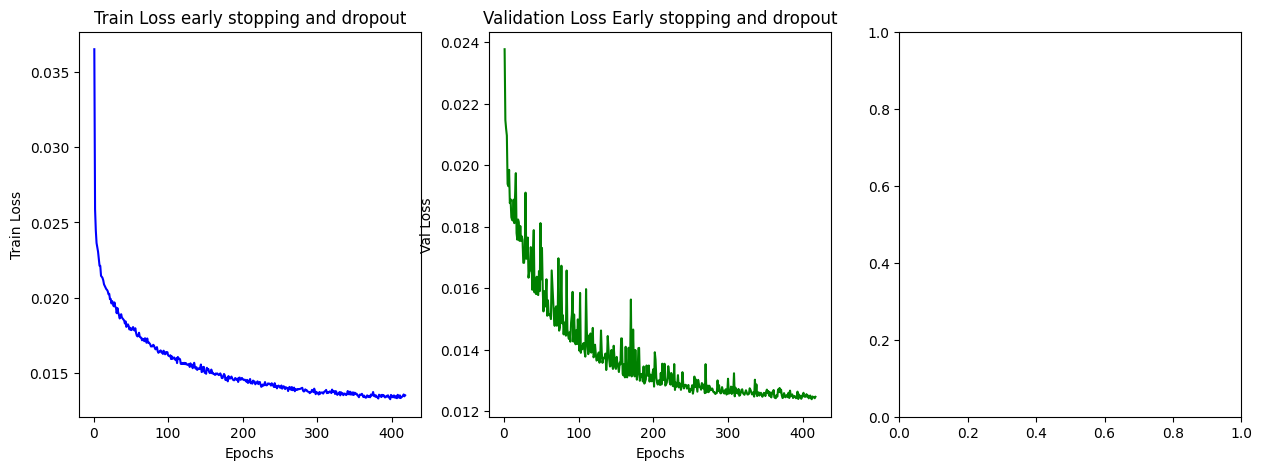

R2 score net dropout and early stopping: 0.7877495325251074
MSE net dropout and early stopping: 54173.682174685426

R2 random forest 2: 0.8271114226764336
MSE random forest 2: 48893.05512538962


In [81]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
epochs_train = range(1, stop_epoch + 2)
epochs_val = range(1, stop_epoch + 1)
#val_loss_smooth = pd.Series(val_losses_ref).rolling(10)

axes[0].plot(epochs_train, train_losses_early_stop, color='blue')
axes[0].set_title('Train Loss early stopping and dropout')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')

axes[1].plot(epochs_val, val_losses_early_stop, color='green')
axes[1].set_title('Validation Loss Early stopping and dropout')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Val Loss')

#axes[1].plot(epochs, val_loss_smooth, color='red')
#axes[1].set_title('Validation Loss')
#axes[1].set_xlabel('Epochs')
#axes[1].set_ylabel('Val Loss')

plt.show()

trained_model = CHNetworkDropout(number_of_features2, 1)
trained_model.load_state_dict(torch.load(os.path.join('./', 'snapshot_dropout_and_early_stopping')))
trained_model.eval()

r2_net, mse_net = get_metrics(trained_model, validation_loader)

print(f'R2 score net dropout and early stopping: {r2_net}')
print(f'MSE net dropout and early stopping: {mse_net}')
print()
print(f'R2 random forest 2: {r2_score(ytruev_rf, ypredv_rf)}')
print(f'MSE random forest 2: {mean_squared_error(ytruev_rf, ypredv_rf, squared=False)}')